# Capstone - Smart Surveillance system

For our smart surveillance system we aim to feature the system with a real-time face-recognition that automaticaly identifies the people who entered our property. 

## Face Recognition

With the advancements in Convolutions Neural Networks, its pretty common nowadays to use supervised learning algorythm such as [FaceNet](https://arxiv.org/pdf/1503.03832.pdf), [DeepFace](https://research.fb.com/wp-content/uploads/2016/11/deepface-closing-the-gap-to-human-level-performance-in-face-verification.pdf) or [YOLO]() for fast and real-time face-recognition task. 

In our project we have used [FaceNet](https://arxiv.org/pdf/1503.03832.pdf) to recognize faces.

Face recognition problems commonly fall into one of two categories: 

**Face Verification** "Is this the claimed person?" For example, at some airports, you can pass through customs by letting a system scan your passport and then verifying that you (the person carrying the passport) are the correct person. A mobile phone that unlocks using your face is also using face verification. This is a 1:1 matching problem.

**Face Recognition** "Who is this person?" For example, the video lecture showed a [face recognition video](https://www.youtube.com/watch?v=wr4rx0Spihs) of Baidu employees entering the office without needing to otherwise identify themselves. This is a 1:K matching problem.

FaceNet learns a neural network that encodes a face image into a vector of 128 numbers. By comparing two such vectors, you can then determine if two pictures are of the same person.

## Overcoming a cold start 

In this notebook we try to overcome a problem which is called cold-start. As we have learned a face recognition system is comparing the detected and encoded faces to a database of faces. Thereby, the model will have a hard time to identify any detected face when there is little or no data in the database to which it could compare the identidfied face. In order to train such a supervised model, by pre-filling the database we need to get datasets of our target labels which is still a tedious task. Therefore, we need an efficient and automated solution for the dataset generation with minimal labeling effort
by user intervention.

### Goal 
Our idea is to implement a dataset generation pipeline which takes as input a folder of mixed pictures (eg last vacations, birthday, hiking, wedding or any other pictures that show you and any potential person that might visit you in the future) and  extracts all the faces from the images and clusters them to limited and accurate sets of images representing the different people in these pictures. Thereby each set can easily be labeled by human input with ease

### Technicaly

- We are going to use [MTCNN]() to detect and crop the faces in these pictures 
- We will align the faces for feature extraction and use the google pretrained FaceNet model to encode the faces.
- We will cluster the encodings ()last layer of the FaceNet using DBSCAN clustering provided by scikit-learn.
- For the solution, we will crop out all the faces, create labels and group them in folders for users to adapt them as a dataset for their training use-cases.


### Challenges in implementation

For a larger audience, we plan to implement the solution for execution in CPU but will also give the option to use a GPU >= RTX 3070. Using an NVIDIA GPU may increase the efficiency of the pipeline.
CPU implementation of facial embedding extraction is very slow (???+ sec per images). To cope up
with the problem, we implement them with parallel pipeline executions (resulting in ~???sec per
image) and later merge their results for further clustering tasks.
We introduce tqdm along with PyPiper for progress updates.

check which enviroment Im in with which interpreter - we need capstone env and python 3.7

In [ ]:
import sys
print(sys.executable)

The next lines are intended for explorational purposes

First we need to detect faces of the provided pictures
First attemp use cascaseclassifier of cv2 package

In [ ]:
# example of face detection with opencv cascade classifier
# plot photo with detected faces using opencv cascade classifier
import os
import cv2
from cv2 import imread
from cv2 import imshow
from cv2 import waitKey
from cv2 import destroyAllWindows
from cv2 import CascadeClassifier
from cv2 import rectangle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

path = "/mnt/golem/frodo/"
pictures = os.listdir(path)[1:]


for pics in pictures:
    # load the photograph
    pixels = imread(path + pics)
    # load the pre-trained model
    classifier = CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml') 

    # perform face detection
    bboxes = classifier.detectMultiScale(pixels)

    for box in bboxes:
        # extract
        x, y, width, height = box
        x2, y2 = x + width, y + height
        # draw a rectangle over the pixels
        rectangle(pixels, (x, y), (x2, y2), (0,0,255), 10)



    #Show the image with matplotlib
    plt.imshow(cv2.cvtColor(pixels, cv2.COLOR_BGR2RGB))
    plt.show()
    # imshow('face detection', np.array(pixels, dtype = np.uint8))
    # # keep the window open until we press a key
    # waitKey(0)
    # # close the window
    # destroyAllWindows()

Next we use a more sophisticated model a neural network called MTCNN to detect faces

In [ ]:
# confirm mtcnn was installed correctly
import mtcnn
import os
import tensorflow as tf
# print version
print(mtcnn.__version__)
print(tf.__version__)

# face detection with mtcnn on a photograph
from matplotlib import pyplot
from mtcnn.mtcnn import MTCNN


# load image from file
path = "/mnt/golem/frodo/"
pictures = os.listdir(path)[1:]

# load the photograph
filename = path + pictures[0]
pixels = pyplot.imread(filename)
# create the detector, using default weights
detector = MTCNN()
# detect faces in the image
faces = detector.detect_faces(pixels)
for face in faces:
    print(face)


In [ ]:
face

helper functions

In [ ]:
# face detection with mtcnn on a photograph
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from matplotlib.patches import Circle
from mtcnn.mtcnn import MTCNN
import numpy as np
 
# draw an image with detected objects
def draw_image_with_boxes(filename, result_list):
    # load the image
    data = pyplot.imread(filename)
    # plot the image
    pyplot.imshow(data)
    # get the context for drawing boxes
    ax = pyplot.gca()
    # plot each box
    for result in result_list:
        # get coordinates
        x, y, width, height = result['box']
        # create the shape
        rect = Rectangle((x, y), width, height, fill=False, color='red')
        # draw the box
        ax.add_patch(rect)
    # show the plot
    pyplot.show()
    
# draw each face separately
def crop_faces(filename, result_list):
    # load the image
    data = pyplot.imread(filename)
    # plot each face as a subplot
    for i in range(len(result_list)):
        # get coordinates
        x1, y1, width, height = result_list[i]['box']
        x2, y2 = x1 + width, y1 + height
        # define subplot
        pyplot.subplot(1, len(result_list), i+1)
        pyplot.axis('off')
        # plot face
        pyplot.imshow(data[y1:y2, x1:x2])
    # show the plot
    pyplot.show()
    
    
# draw an image with detected objects
def draw_image_with_boxes_circles(filename, result_list):
    # load the image
    data = pyplot.imread(filename)
    # plot the image
    pyplot.imshow(data)
    # get the context for drawing boxes
    ax = pyplot.gca()
    # plot each box
    for result in result_list:
        # get coordinates
        x, y, width, height = result['box']
        # create the shape
        rect = Rectangle((x, y), width, height, fill=False, color='red')
        # draw the box
        ax.add_patch(rect)
        # draw the dots
        for key, value in result['keypoints'].items():
            # create and draw dot
            dot = Circle(value, radius=10, color='red')
            ax.add_patch(dot)
    # show the plot
    pyplot.show()
    
    
# draw an image with detected objects
def draw_image_with_boxes_center(filename, result_list):
    # load the image
    data = pyplot.imread(filename)
    # plot the image
    pyplot.imshow(data)
    # get the context for drawing boxes
    ax = pyplot.gca()
    # plot each box
    for result in result_list:
        # get coordinates
        x, y, width, height = result['box']
        # create the shape
        rect = Rectangle((x, y), width, height, fill=False, color='red')
        # draw the box
        ax.add_patch(rect)
        
        # draw the dots
        circles = result['keypoints'].values()
        center = (sum(k[0] for k in circles)/len(circles), sum(k[1] for k in circles)/len(circles))
        dot = Circle(center, radius=10, color='red')
        ax.add_patch(dot)
        
        
        # target size 160x160
        trg = 160
        rect_new = Rectangle((center[0]-trg/2, center[1]-trg/2), trg, trg, fill=False, color='green')
        ax.add_patch(rect_new)

        MAX = int(np.max([width, height]))
                
        rect_new2 = Rectangle((center[0]-MAX/2, center[1]-MAX/2), MAX, MAX, fill=False, color='blue')
        ax.add_patch(rect_new2)
        
#         show the plot
    pyplot.show()
       
#         for key, value in result['keypoints'].items():
#             # create and draw dot
#             dot = Circle(value, radius=10, color='red')
#             ax.add_patch(dot)
#     show the plot
#     pyplot.show()
 

    
# draw each face separately
def crop_faces_centered_boxes(filename, result_list, thr= 0.85):
    # load the image
    data = pyplot.imread(filename)
    # plot each face as a subplot
    dim = data.shape
    for i in range(len(result_list)):
        # get coordinates
        
        if result_list[i]['confidence'] > thr:
            x1, y1, width, height = result_list[i]['box']
            x2, y2 = x1 + width, y1 + height

            # draw the dots
            circles = result_list[i]['keypoints'].values()
            center = (sum(k[0] for k in circles)/len(circles), sum(k[1] for k in circles)/len(circles))

            MAX = int(np.max([width, height]))

            x1, x2, y1, y2 = (int(center[0]-MAX/2), int(center[0]+MAX/2), int(center[1]-MAX/2), int(center[1]+MAX/2))

            if x1 < 0:                
                x2 += x1*-1
                x1 = 0
                
            if x2 > dim[1]:
                x1 -= x2-dim[1]
                x2 = dim[1]
                
            if y1 < 0:                
                y2 += y1*-1
                y1 = 0
                
            if y2 > dim[1]:
                y1 -= y2-dim[0]
                y2 = dim[0]
            
            
            crop = data[y1:y2, x1:x2]
            output_dir = "/mnt/golem/frodo/cropped_faces/" + filename.split("/")[-1].split(".")[0] + "cropped_face" + str(i) + ".png"
            cv2.imwrite(output_dir, cv2.cvtColor(crop, cv2.COLOR_RGB2BGR))
    
            # define subplot
            pyplot.subplot(1, len(result_list), i+1)
            pyplot.axis('off')
            # plot face
            pyplot.imshow(crop)
    

#             if SAVE:
                
#                 filename = repository + "cropped_face_nr" + str(i) + ".png"
                
# #                 pyplot.savefig(filename)
#                 status = cv2.imwrite(filename, crop)
#                 pyplot.savefig(filename)
#                 print(filename)
#                 cv2.imwrite(filename, crop)


                
        else:
            print(result_list[i]['confidence'])
        
    # show the plot
    pyplot.show()
    
    
# draw each face separately
def crop_faces_centered_boxes_for_encoding(faces, path=filename, thr= 0.85, model=FaceNet):
    from tqdm import tqdm
    
    ID = uuid.uuid4().int
    # input dimension
    dim = faces.shape
    
    for i in tqdm(range(len(faces))):
        
        # get coordinates only if confident in face detection
        if faces[i]['confidence'] > thr:
            x1, y1, width, height = faces[i]['box']
            x2, y2 = x1 + width, y1 + height

            # recenter the detected rectangle around the face
            circles = faces[i]['keypoints'].values()
            center = (sum(k[0] for k in circles)/len(circles), sum(k[1] for k in circles)/len(circles))
            
            # adjust the ratio of the rectangle towards the onger side of height and width
            # remember input for FaceNet is 160x160 as we don t want to deform the face by resizing it
            # we recenter the rectangle and keep same side size
            MAX = int(np.max([width, height]))
            x1, x2, y1, y2 = (int(center[0]-MAX/2), int(center[0]+MAX/2), int(center[1]-MAX/2), int(center[1]+MAX/2))
            
            # check for the cases that we go out of limit with the rectangle
            if x1 < 0:                
                x2 += x1*-1
                x1 = 0
                
            if x2 > dim[1]:
                x1 -= x2-dim[1]
                x2 = dim[1]
                
            if y1 < 0:                
                y2 += y1*-1
                y1 = 0
                
            if y2 > dim[1]:
                y1 -= y2-dim[0]
                y2 = dim[0]
            
            
            # crop the face out of the image 
            crop = data[y1:y2, x1:x2]
            
            
            
            output_dir = "/mnt/golem/frodo/cropped_faces/" + str(ID) + "_cropped_face.png"
            cv2.imwrite(output_dir, cv2.cvtColor(crop, cv2.COLOR_RGB2BGR))
    
#             # define subplot
#             pyplot.subplot(1, len(result_list), i+1)
#             pyplot.axis('off')
#             # plot face
#             pyplot.imshow(crop)
    

#             if SAVE:
                
#                 filename = repository + "cropped_face_nr" + str(i) + ".png"
                
# #                 pyplot.savefig(filename)
#                 status = cv2.imwrite(filename, crop)
#                 pyplot.savefig(filename)
#                 print(filename)
#                 cv2.imwrite(filename, crop)


                
        else:
            print(result_list[i]['confidence'])
        
    # show the plot
#     pyplot.show()
    
    
def import_FaceNet(model_path='../dat/models/keras-facenet-h5/model.json', 
                   weight_path = '../dat/models/keras-facenet-h5/model.h5'):
    
    from tensorflow.keras.models import model_from_json
    json_file = open(model_path, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    FaceNet = model_from_json(loaded_model_json)
    FaceNet.load_weights(weight_path)
    
#tf.keras.backend.set_image_data_format('channels_last')
def img_to_encoding(image_path, model):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(160, 160))
    img = np.around(np.array(img) / 255.0, decimals=12)
    x_train = np.expand_dims(img, axis=0)
    embedding = model.predict_on_batch(x_train)
    return embedding / np.linalg.norm(embedding, ord=2)

In [ ]:
import re
r = re.compile(".*jpg")
newlist = list(filter(r.match, pictures))


In [1]:

class GenerateFaces: 
        
    # The init method or constructor
    def __init__(self, file_path , output="/mnt/golem/frodo/cropped_faces/", thr=0.95, plot=True):
        import os
        import json

        if os.path.isfile("/mnt/golem/frodo/Database/FaceDB.json"):
            self.DB = json.loads(open("/mnt/golem/frodo/Database/FaceDB.json").read())
            self.n = len(self.DB) 
        else:
            self.DB = None
            self.n = 0
        
        self.path = file_path
        self.output_dir = output
        self.thr = thr
        self.plot = plot
        self.container = {}
        self.import_FaceNet()
#         self.DB = self.get_existingDB(self, path=None)
        
    def run(self, archive = True):
        from tqdm import tqdm 
        import matplotlib.pyplot as plt
        from mtcnn.mtcnn import MTCNN
        from PIL import Image
        from pillow_heif import register_heif_opener

                        
        for pics in tqdm(self.path):
            # load the photograph
            self.filename = pics
#             print(self.filename)

            # load image from file
            if ("HEIC" == self.filename.split(".")[-1]) | ("heic"== self.filename.split(".")[-1]):

                register_heif_opener()

                image = Image.open(self.filename)
                self.pixels = image.__array__()
                
            elif ("PNG" == self.filename.split(".")[-1]) | ("png"== self.filename.split(".")[-1]):
                
                # png have 4 channels R,G,B and alpha for transparency --> here we get rid of it
                image = Image.open(self.filename).convert('RGBA')
                background = Image.new('RGBA', image.size, (255,255,255))
                alpha_composite = Image.alpha_composite(background, image)
                alpha_composite_3 = alpha_composite.convert('RGB')
                
                self.pixels = np.asarray(alpha_composite_3)

            else:
                self.pixels = plt.imread(self.filename)
                
                
            # create the detector, using default weights
            detector = MTCNN()
            # detect faces in the image
            self.faces = detector.detect_faces(self.pixels)
            # display faces on the original image
            self.crop_faces_centered_boxes_for_encoding()
            
#         self.get_database()
#         self.get_existingDB()
            
        if archive:
            self.archive_database()
        else:
            print("DB was not archived")
        
    # draw each face separately
    def crop_faces_centered_boxes_for_encoding(self):
        import cv2
        import matplotlib.pyplot as plt
#         import uuid
        import numpy as np
        import os
        
        # input dimension
        dim = self.pixels.shape

        for i in range(len(self.faces)):
            
            # if confident in face detection
            if self.faces[i]['confidence'] > self.thr:
                
                # generate unique id for detected face
#                 ID = uuid.uuid4().int
                self.n += 1
                ID = self.n
                
#                 while True:
#                     if ID in self.container.keys():
#                         ID = uuid.uuid4().int
#                     else:
#                         break
                    
                
                # get coordinates only
                x1, y1, width, height = self.faces[i]['box']
                x2, y2 = x1 + width, y1 + height

                # recenter the detected rectangle around the face
                circles = self.faces[i]['keypoints'].values()
                center = (sum(k[0] for k in circles)/len(circles), sum(k[1] for k in circles)/len(circles))

                # adjust the ratio of the rectangle towards the onger side of height and width
                # remember input for FaceNet is 160x160 as we don t want to deform the face by resizing it
                # we recenter the rectangle and keep same side size
                MAX = int(np.max([width, height]))
                x1, x2, y1, y2 = (int(center[0]-MAX/2), int(center[0]+MAX/2), int(center[1]-MAX/2), int(center[1]+MAX/2))

                # check for the cases that we go out of limit with the rectangle
                if x1 < 0:                
                    x2 += x1*-1
                    x1 = 0

                if x2 > dim[1]:
                    x1 -= x2-dim[1]
                    x2 = dim[1]

                if y1 < 0:                
                    y2 += y1*-1
                    y1 = 0

                if y2 > dim[1]:
                    y1 -= y2-dim[0]
                    y2 = dim[0]


                # crop the face out of the image 
                crop = self.pixels[y1:y2, x1:x2]

                output_dir = self.output_dir + str(ID) + "_cropped_face.png"
                cv2.imwrite(output_dir, cv2.cvtColor(crop, cv2.COLOR_RGB2BGR))
                
                self.encodings = self.img_to_encoding(output_dir)
                
                if self.DB != None:
                    match = [k for k,v in self.DB.items() if v["encodings"] == self.encodings.tolist()]
                    if len(match) > 0:
                        print("This face alredy exist in the database {}".format(match[0]))
                        os.remove(output_dir)
                    else:
                        self.container[ID] = {"path_pic_orig": self.filename,
                                              "path_croped_pic": output_dir,
                                     "encodings": self.encodings.tolist(),
                                     "recentered_rectangle": [x1, x2, y1, y2],
                                     "detector": self.faces[i]}
                
                else:                
                    self.container[ID] = {"path_pic_orig": self.filename,
                                          "path_croped_pic": output_dir,
                                     "encodings": self.encodings.tolist(),
                                     "recentered_rectangle": [x1, x2, y1, y2],
                                     "detector": self.faces[i]}
                
                if self.plot:
                    # define subplot
                    plt.subplot(1, len(self.faces), i+1)
                    plt.axis('off')
                    # plot face
                    plt.imshow(crop)
                
            else:
                x1, y1, width, height = self.faces[i]['box']
                x2, y2 = x1 + width, y1 + height
                output_dir = self.output_dir + "less_confident_faces/" + str(self.faces[i]['confidence']) + "_cropped_face.png"
                cv2.imwrite(output_dir, cv2.cvtColor(self.pixels[y1:y2, x1:x2], cv2.COLOR_RGB2BGR))
                
                print("This face did not had high confidence {}".format(self.faces[i]['confidence']))
                
                
    def import_FaceNet(self, model_path='../dat/models/keras-facenet-h5/model.json', 
                       weight_path = '../dat/models/keras-facenet-h5/model.h5'):

        from tensorflow.keras.models import model_from_json
        json_file = open(model_path, 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        self.FaceNet = model_from_json(loaded_model_json)
        self.FaceNet.load_weights(weight_path)

    #tf.keras.backend.set_image_data_format('channels_last')
    def img_to_encoding(self, image_path):
        import tensorflow as tf  
        import numpy as np
        img = tf.keras.preprocessing.image.load_img(image_path, target_size=(160, 160))
        img = np.around(np.array(img) / 255.0, decimals=12)
        x_train = np.expand_dims(img, axis=0)
        embedding = self.FaceNet.predict_on_batch(x_train)
        return embedding / np.linalg.norm(embedding, ord=2)
    
#     def combine_dicts(self, *dicts):
#         from functools import reduce
#         return reduce(lambda dict1, dict2: dict(zip(dict1.keys() + dict2.keys(), dict1.values() + dict2.values())), dicts)

    def get_existingDB(self):    
        if self.DB == None:
            print("There is no pre-existing FaceDB.")            
        return self.container       
    
    def archive_database(self):
        import json
        DB = self.get_database()        
        with open('/mnt/golem/frodo/Database/FaceDB.json', 'w') as fp:
            json.dump(DB, fp)
            
    def get_database(self):
        if self.DB != None:
            self.container.update(self.DB)            
        return self.container
    
    def is_already_processed(self):
        return self.path
                



In [2]:
class FaceCluster:
     
    def __init__(self, file_path="/mnt/golem/frodo/Database/FaceDB.json", IDs = None):
        import json
               
        if not (os.path.isfile(file_path) and os.access(path, os.R_OK)):
            print('The input encoding file, ' + str(path) + ' does not exists or unreadable')
            exit()
            
        self.DB = json.loads(open(file_path).read())
        if IDs != None:
            self.DB = {k: v for k,v in self.DB.items() if k in IDs}
        
        self.encodings = np.vstack([np.array(v["encodings"]) for k,v in self.DB.items()]) 
     
    def Cluster(self):
        from sklearn.cluster import DBSCAN
        import hdbscan
 
        NumberOfParallelJobs = -1
 
        # cluster the embeddings
        print("[INFO] Clustering")
        clt = hdbscan.HDBSCAN(min_cluster_size=10)
#         clt = DBSCAN(eps=0.75, min_samples=10,
#                       n_jobs = NumberOfParallelJobs)
                       
#         clt.fit(self.encodings)

        (labelIDs, labelIDs_freq) = np.unique(clt.fit_predict(self.encodings), return_counts=True)
        # determine the total number of
        # unique faces found in the dataset
#         (labelIDs, labelIDs_freq) = np.unique(clt.labels_, return_counts=True)
        numUniqueFaces = len(np.where(labelIDs > -1)[0])
        print("[INFO] # unique faces: {}\n".format(numUniqueFaces))
 
        return clt.labels_

In [3]:
class FaceImageGenerator:
    
    def GenerateImages(self, labels, OutputFolderName = "ClusteredFaces", 
                                            MontageOutputFolder = "Montage",
                       file_path= "/mnt/golem/frodo/Database/FaceDB.json",
                       IDs = None
                      ):
        import shutil
        import os
        import time
        import json
        import numpy as np
        import cv2
        from imutils import build_montages
        
        OutputFolder = "/mnt/golem/frodo/" + OutputFolderName
 
        if not os.path.exists(OutputFolder):
            os.makedirs(OutputFolder)
        else:
            shutil.rmtree(OutputFolder)
            time.sleep(0.5)
            os.makedirs(OutputFolder)
 
        MontageFolderPath = os.path.join(OutputFolder, MontageOutputFolder)
        os.makedirs(MontageFolderPath)
        
        if not (os.path.isfile(file_path) and os.access(file_path, os.R_OK)):
            print('The input encoding file, ' + str(file_path) + ' does not exists or unreadable')
            exit()
            
        self.DB = json.loads(open(file_path).read())
        
        if IDs != None:
            self.DB = {k: v for k,v in self.DB.items() if k in IDs}
                
        self.IDs = list(self.DB.keys())
        self.encodings = np.vstack([np.array(v["encodings"]) for k,v in self.DB.items()]) 
 
        
        
        
        (labelIDs, labelIDs_freq) = np.unique(labels, return_counts=True)
         
        # loop over the unique face integers
        for labelID, labelID_freq in zip(labelIDs, labelIDs_freq):
            # find all indexes into the `data` array
            # that belong to the current label ID, then
            # randomly sample a maximum of 25 indexes
            # from the set
             
            print("[INFO] There are {} faces for FaceCluster ID: {}".format(labelID_freq, labelID))
 
            FaceFolder = os.path.join(OutputFolder, "Face_" + str(labelID))
            os.makedirs(FaceFolder)
 
            idxs = np.where(labels == labelID)[0]
            
            ID = np.array(self.IDs)[idxs].tolist()
 
            # initialize the list of faces to
            # include in the montage
            portraits = []
 
            # loop over the sampled indexes
            for i in ID:
                 
                # load the input image and extract the face ROI
                image = cv2.imread(self.DB[i]["path_croped_pic"])
 
                portrait = image
 
                if len(portraits) < 25:
                    portraits.append(portrait)
 
                FaceFilename = "face_" + str(i) + ".png"
 
                FaceImagePath = os.path.join(FaceFolder, FaceFilename)
                cv2.imwrite(FaceImagePath, portrait)

            montage = build_montages(portraits, (96, 120), (5, 5))[0]
             
            MontageFilenamePath = os.path.join(
               MontageFolderPath, "FaceCluster_" + str(labelID) + ".jpg")
                
            cv2.imwrite(MontageFilenamePath, montage)

In [ ]:
# 8911/8939

In [4]:
import re
import os
path = "/mnt/golem/Photos/Sandro_externe_Festplatte/"
pictures = [os.path.join(root, name)
             for root, dirs, files in os.walk(path)
             for name in files
             if name.endswith((".jpg", ".heic" ,".PNG", ".JPG", ".HEIC"))]

pictures = [i for i in pictures if "@" not in i]
# pictures = [path + IMG  for IMG in os.listdir(path)]

# r = re.compile(".*(jpg|heic|PNG|JPG|HEIC)")
r = re.compile(".*(heic|PNG|JPG|HEIC)")
pictures = list(filter(r.match, pictures))

pictures[8911:8939]
# pictures
DB = GenerateFaces(pictures[8911:8939], plot=False)
# DB.run(archive=True)


2022-02-19 14:17:28.925416: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-19 14:17:28.925436: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-02-19 14:17:30.201068: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-19 14:17:30.201088: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-19 14:17:30.201107: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (frodo): /proc/driver/nvidia/version does not exist
2022-02-19 14:17:30.201223: I tensorflow/core/platform/cpu_feature_guar

In [149]:
path = "/mnt/golem/Photos/Caren_externe_Festplatte/"
pictures = [os.path.join(root, name)
             for root, dirs, files in os.walk(path)
             for name in files
             if name.endswith((tuple(i for i in args.prefix.split("|"))))]

pictures = [i for i in pictures if "@" not in i]

('.jpg', '.JPG')

In [139]:
import re
import os
def flatten(t):
    return [item for sublist in t for item in sublist]

path = "/mnt/golem/Photos/Samsung Galaxy/"
folders = {path + w: os.listdir(path + w) for w in os.listdir(path) if (len(w.split(".")) == 1) and ("@" not in w)}
pictures = [k +"/" + v for k in folders.keys() for v in folders[k]]
r = re.compile(".*(jpg|heic|PNG|JPG|HEIC)")
pictures = list(filter(r.match, pictures ))
print(len(pictures))

DB = GenerateFaces(pictures, plot=False)
DB.run(archive=True)

1986


  0%|                                                                                                                               | 0/1986 [00:00<?, ?it/s]

  0%|                                                                                                                     | 1/1986 [00:01<1:00:59,  1.84s/it]

This face did not had high confidence 0.7330206036567688


  0%|                                                                                                                       | 2/1986 [00:03<47:51,  1.45s/it]

This face did not had high confidence 0.7426037192344666


  0%|▎                                                                                                                      | 5/1986 [00:06<39:17,  1.19s/it]

This face did not had high confidence 0.8462429046630859


  0%|▍                                                                                                                      | 8/1986 [00:09<35:55,  1.09s/it]

This face did not had high confidence 0.928252637386322


  1%|▊                                                                                                                     | 13/1986 [00:15<42:23,  1.29s/it]

This face did not had high confidence 0.7922593951225281


  1%|▉                                                                                                                     | 16/1986 [00:19<38:29,  1.17s/it]

This face did not had high confidence 0.8574113845825195


  1%|█▏                                                                                                                    | 20/1986 [00:22<33:28,  1.02s/it]

This face did not had high confidence 0.8792757391929626


  1%|█▎                                                                                                                    | 23/1986 [00:26<37:19,  1.14s/it]

This face did not had high confidence 0.9245207905769348
This face did not had high confidence 0.8456107378005981


  1%|█▌                                                                                                                    | 26/1986 [00:29<37:24,  1.15s/it]

This face did not had high confidence 0.715979278087616


  1%|█▋                                                                                                                    | 28/1986 [00:34<56:40,  1.74s/it]

This face did not had high confidence 0.892839252948761


  1%|█▋                                                                                                                  | 29/1986 [00:36<1:06:32,  2.04s/it]

This face did not had high confidence 0.9304023385047913
This face did not had high confidence 0.8996484279632568


  2%|█▊                                                                                                                  | 30/1986 [00:39<1:13:51,  2.27s/it]

This face did not had high confidence 0.8151631355285645


  2%|█▉                                                                                                                  | 33/1986 [00:48<1:24:38,  2.60s/it]

This face did not had high confidence 0.9164314866065979
This face did not had high confidence 0.8630757927894592
This face did not had high confidence 0.8483238816261292
This face did not had high confidence 0.8103851675987244
This face did not had high confidence 0.7697769999504089


  2%|█▉                                                                                                                  | 34/1986 [00:50<1:24:10,  2.59s/it]

This face did not had high confidence 0.8947404623031616
This face did not had high confidence 0.8563851714134216


  2%|██                                                                                                                  | 35/1986 [00:53<1:24:36,  2.60s/it]

This face did not had high confidence 0.9444794058799744
This face did not had high confidence 0.7311534881591797


  2%|██                                                                                                                  | 36/1986 [00:56<1:25:45,  2.64s/it]

This face did not had high confidence 0.8199619054794312
This face did not had high confidence 0.7610312700271606
This face did not had high confidence 0.7424805164337158
This face did not had high confidence 0.7135496139526367
This face did not had high confidence 0.7043471336364746


  2%|██▏                                                                                                                 | 37/1986 [00:58<1:26:09,  2.65s/it]

This face did not had high confidence 0.8180391788482666


  2%|██▏                                                                                                                 | 38/1986 [01:01<1:27:06,  2.68s/it]

This face did not had high confidence 0.781218945980072
This face did not had high confidence 0.7570779919624329
This face did not had high confidence 0.7462037801742554
This face did not had high confidence 0.7155658006668091


  2%|██▎                                                                                                                 | 39/1986 [01:04<1:25:52,  2.65s/it]

This face did not had high confidence 0.8725184798240662
This face did not had high confidence 0.8379741311073303


  2%|██▎                                                                                                                 | 40/1986 [01:06<1:24:50,  2.62s/it]

This face did not had high confidence 0.7562897801399231
This face did not had high confidence 0.7044086456298828


  2%|██▍                                                                                                                 | 41/1986 [01:09<1:23:04,  2.56s/it]

This face did not had high confidence 0.8158443570137024


  3%|███▏                                                                                                                  | 53/1986 [01:22<35:28,  1.10s/it]

This face did not had high confidence 0.845466673374176
This face did not had high confidence 0.754088819026947


  3%|███▎                                                                                                                  | 56/1986 [01:25<36:49,  1.14s/it]

This face did not had high confidence 0.8713948726654053
This face did not had high confidence 0.7548555135726929


  3%|███▋                                                                                                                  | 62/1986 [01:32<36:52,  1.15s/it]

This face did not had high confidence 0.7352050542831421


  3%|███▋                                                                                                                  | 63/1986 [01:33<36:24,  1.14s/it]

This face did not had high confidence 0.8023005127906799


  3%|███▊                                                                                                                  | 65/1986 [01:35<34:51,  1.09s/it]

This face did not had high confidence 0.8362330198287964


  3%|███▉                                                                                                                  | 67/1986 [01:37<34:47,  1.09s/it]

This face did not had high confidence 0.8331956267356873


  4%|████▏                                                                                                                 | 71/1986 [01:42<34:49,  1.09s/it]

This face did not had high confidence 0.8462440371513367
This face did not had high confidence 0.7700761556625366
This face did not had high confidence 0.7142035961151123


  4%|████▎                                                                                                                 | 72/1986 [01:43<35:44,  1.12s/it]

This face did not had high confidence 0.7771511077880859


  4%|████▋                                                                                                                 | 78/1986 [01:50<36:32,  1.15s/it]

This face did not had high confidence 0.8799638152122498


  4%|████▊                                                                                                                 | 81/1986 [01:54<38:17,  1.21s/it]

This face did not had high confidence 0.9298170804977417
This face did not had high confidence 0.8282642364501953


  4%|████▊                                                                                                                 | 82/1986 [01:55<38:40,  1.22s/it]

This face did not had high confidence 0.9156752228736877


  4%|████▉                                                                                                                 | 83/1986 [01:56<39:07,  1.23s/it]

This face did not had high confidence 0.8943936824798584
This face did not had high confidence 0.7251163125038147


  4%|█████▏                                                                                                                | 87/1986 [02:03<56:27,  1.78s/it]

This face did not had high confidence 0.8669341206550598
This face did not had high confidence 0.8201475143432617


  4%|█████▏                                                                                                              | 89/1986 [02:08<1:06:49,  2.11s/it]

This face did not had high confidence 0.9040297865867615


  5%|█████▎                                                                                                              | 90/1986 [02:11<1:12:38,  2.30s/it]

This face did not had high confidence 0.8354416489601135
This face did not had high confidence 0.7054338455200195


  5%|█████▍                                                                                                              | 93/1986 [02:19<1:22:40,  2.62s/it]

This face did not had high confidence 0.8101376891136169
This face did not had high confidence 0.7274077534675598


  5%|█████▍                                                                                                              | 94/1986 [02:22<1:29:12,  2.83s/it]

This face did not had high confidence 0.7883318662643433
This face did not had high confidence 0.741577684879303
This face did not had high confidence 0.7057662010192871


  5%|█████▌                                                                                                              | 95/1986 [02:25<1:31:57,  2.92s/it]

This face did not had high confidence 0.8831856846809387
This face did not had high confidence 0.7440921068191528


  5%|█████▌                                                                                                              | 96/1986 [02:28<1:26:48,  2.76s/it]

This face did not had high confidence 0.9019924998283386
This face did not had high confidence 0.7965818047523499


  5%|█████▋                                                                                                              | 97/1986 [02:30<1:23:02,  2.64s/it]

This face did not had high confidence 0.9480019807815552
This face did not had high confidence 0.8731920719146729


  5%|█████▋                                                                                                              | 98/1986 [02:33<1:22:52,  2.63s/it]

This face did not had high confidence 0.7557978630065918


  5%|█████▊                                                                                                             | 100/1986 [02:38<1:23:46,  2.67s/it]

This face did not had high confidence 0.8872143626213074
This face did not had high confidence 0.8542622923851013
This face did not had high confidence 0.8467580080032349
This face did not had high confidence 0.8015613555908203


  5%|█████▊                                                                                                             | 101/1986 [02:41<1:25:59,  2.74s/it]

This face did not had high confidence 0.8757880330085754
This face did not had high confidence 0.7860084772109985


  5%|██████                                                                                                             | 105/1986 [02:53<1:30:27,  2.89s/it]

This face did not had high confidence 0.7999919056892395


  5%|██████▏                                                                                                            | 106/1986 [02:56<1:31:10,  2.91s/it]

This face did not had high confidence 0.794670581817627


  5%|██████▏                                                                                                            | 107/1986 [02:58<1:28:51,  2.84s/it]

This face did not had high confidence 0.8923726677894592
This face did not had high confidence 0.8061755299568176


  6%|██████▍                                                                                                            | 111/1986 [03:08<1:20:49,  2.59s/it]

This face did not had high confidence 0.8872591853141785
This face did not had high confidence 0.7378661632537842
This face did not had high confidence 0.7222471237182617


  6%|██████▍                                                                                                            | 112/1986 [03:11<1:19:58,  2.56s/it]

This face did not had high confidence 0.7824909090995789


  6%|██████▌                                                                                                            | 113/1986 [03:14<1:26:31,  2.77s/it]

This face did not had high confidence 0.7332590222358704
This face did not had high confidence 0.7054361701011658


  6%|██████▋                                                                                                            | 115/1986 [03:20<1:28:19,  2.83s/it]

This face did not had high confidence 0.9475177526473999
This face did not had high confidence 0.8739978075027466
This face did not had high confidence 0.8389302492141724
This face did not had high confidence 0.8076265454292297


  6%|██████▋                                                                                                            | 116/1986 [03:23<1:31:26,  2.93s/it]

This face did not had high confidence 0.9481896162033081
This face did not had high confidence 0.7819241881370544
This face did not had high confidence 0.7460981607437134


  6%|██████▊                                                                                                            | 117/1986 [03:26<1:33:03,  2.99s/it]

This face did not had high confidence 0.8867502808570862
This face did not had high confidence 0.7433896660804749
This face did not had high confidence 0.7399770021438599


  6%|██████▊                                                                                                            | 118/1986 [03:29<1:31:21,  2.93s/it]

This face did not had high confidence 0.7751383185386658
This face did not had high confidence 0.7235104441642761


  6%|██████▉                                                                                                            | 119/1986 [03:32<1:27:20,  2.81s/it]

This face did not had high confidence 0.8846753835678101
This face did not had high confidence 0.8395159840583801
This face did not had high confidence 0.7479554414749146
This face did not had high confidence 0.7158387899398804
This face did not had high confidence 0.7133313417434692


  6%|██████▉                                                                                                            | 120/1986 [03:34<1:27:29,  2.81s/it]

This face did not had high confidence 0.9362698197364807
This face did not had high confidence 0.8766665458679199
This face did not had high confidence 0.8514935374259949
This face did not had high confidence 0.7110900282859802


  6%|███████                                                                                                            | 122/1986 [03:40<1:23:40,  2.69s/it]

This face did not had high confidence 0.8632999658584595
This face did not had high confidence 0.7373042106628418


  6%|███████                                                                                                            | 123/1986 [03:42<1:20:45,  2.60s/it]

This face did not had high confidence 0.9098014831542969


  6%|███████▏                                                                                                           | 124/1986 [03:44<1:18:01,  2.51s/it]

This face did not had high confidence 0.9385029673576355
This face did not had high confidence 0.7660214900970459


  6%|███████▏                                                                                                           | 125/1986 [03:47<1:15:53,  2.45s/it]

This face did not had high confidence 0.7406155467033386


  6%|███████▎                                                                                                           | 126/1986 [03:50<1:20:22,  2.59s/it]

This face did not had high confidence 0.8819008469581604
This face did not had high confidence 0.8610826134681702
This face did not had high confidence 0.8375372290611267
This face did not had high confidence 0.8104338645935059


  6%|███████▎                                                                                                           | 127/1986 [03:53<1:24:10,  2.72s/it]

This face did not had high confidence 0.8743209838867188
This face did not had high confidence 0.8470024466514587
This face did not had high confidence 0.797933042049408
This face did not had high confidence 0.7857391834259033


  6%|███████▍                                                                                                           | 128/1986 [03:55<1:23:44,  2.70s/it]

This face did not had high confidence 0.912217915058136
This face did not had high confidence 0.824912428855896
This face did not had high confidence 0.7605250477790833


  6%|███████▍                                                                                                           | 129/1986 [03:58<1:24:25,  2.73s/it]

This face did not had high confidence 0.9272602200508118
This face did not had high confidence 0.8664152026176453


  7%|███████▌                                                                                                           | 130/1986 [04:01<1:25:02,  2.75s/it]

This face did not had high confidence 0.8713956475257874
This face did not had high confidence 0.8699127435684204
This face did not had high confidence 0.8126989603042603


  7%|███████▌                                                                                                           | 131/1986 [04:04<1:26:40,  2.80s/it]

This face did not had high confidence 0.8390446305274963
This face did not had high confidence 0.7504422664642334


  7%|███████▋                                                                                                           | 132/1986 [04:07<1:27:21,  2.83s/it]

This face did not had high confidence 0.8919169306755066
This face did not had high confidence 0.7782742977142334


  7%|███████▋                                                                                                           | 133/1986 [04:09<1:26:36,  2.80s/it]

This face did not had high confidence 0.7465192079544067
This face did not had high confidence 0.7194008231163025


  7%|███████▊                                                                                                           | 134/1986 [04:12<1:26:01,  2.79s/it]

This face did not had high confidence 0.9165319204330444
This face did not had high confidence 0.7675027847290039


  7%|███████▉                                                                                                           | 137/1986 [04:19<1:12:26,  2.35s/it]

This face did not had high confidence 0.9252052903175354


  7%|████████                                                                                                           | 140/1986 [04:26<1:13:09,  2.38s/it]

This face did not had high confidence 0.8569530248641968
This face did not had high confidence 0.8552743792533875
This face did not had high confidence 0.8474597930908203


  7%|████████▏                                                                                                          | 141/1986 [04:28<1:16:01,  2.47s/it]

This face did not had high confidence 0.9027811288833618
This face did not had high confidence 0.8251804709434509


  7%|████████▏                                                                                                          | 142/1986 [04:31<1:19:05,  2.57s/it]

This face did not had high confidence 0.881198525428772


  7%|████████▎                                                                                                          | 143/1986 [04:34<1:22:42,  2.69s/it]

This face did not had high confidence 0.7355450987815857


  7%|████████▎                                                                                                          | 144/1986 [04:37<1:20:49,  2.63s/it]

This face did not had high confidence 0.7599870562553406


  7%|████████▍                                                                                                          | 145/1986 [04:39<1:19:28,  2.59s/it]

This face did not had high confidence 0.8219488859176636
This face did not had high confidence 0.7536220550537109


  7%|████████▍                                                                                                          | 146/1986 [04:42<1:18:20,  2.55s/it]

This face did not had high confidence 0.7506502866744995


  7%|████████▌                                                                                                          | 147/1986 [04:44<1:17:02,  2.51s/it]

This face did not had high confidence 0.9259043335914612
This face did not had high confidence 0.7070983648300171


  7%|████████▌                                                                                                          | 148/1986 [04:47<1:16:25,  2.49s/it]

This face did not had high confidence 0.9126113057136536


  8%|████████▋                                                                                                          | 151/1986 [04:54<1:18:10,  2.56s/it]

This face did not had high confidence 0.9053623676300049
This face did not had high confidence 0.8180505633354187


  8%|████████▊                                                                                                          | 152/1986 [04:57<1:16:17,  2.50s/it]

This face did not had high confidence 0.8028845191001892
This face did not had high confidence 0.7807265520095825
This face did not had high confidence 0.7361375689506531


  8%|████████▊                                                                                                          | 153/1986 [04:59<1:15:16,  2.46s/it]

This face did not had high confidence 0.7875568866729736
This face did not had high confidence 0.7790119647979736


  8%|████████▉                                                                                                          | 154/1986 [05:02<1:17:23,  2.53s/it]

This face did not had high confidence 0.7412064671516418
This face did not had high confidence 0.7093000411987305


  8%|████████▉                                                                                                          | 155/1986 [05:04<1:17:33,  2.54s/it]

This face did not had high confidence 0.8018339276313782
This face did not had high confidence 0.7582507133483887
This face did not had high confidence 0.7214354872703552


  8%|█████████                                                                                                          | 156/1986 [05:07<1:16:02,  2.49s/it]

This face did not had high confidence 0.9295826554298401


  8%|█████████▏                                                                                                         | 158/1986 [05:12<1:17:25,  2.54s/it]

This face did not had high confidence 0.8934638500213623
This face did not had high confidence 0.8323571085929871
This face did not had high confidence 0.8098140358924866
This face did not had high confidence 0.7907153367996216


  8%|█████████▏                                                                                                         | 159/1986 [05:15<1:19:02,  2.60s/it]

This face did not had high confidence 0.834073543548584
This face did not had high confidence 0.7709571123123169
This face did not had high confidence 0.7180193066596985


  8%|█████████▎                                                                                                         | 161/1986 [05:20<1:18:29,  2.58s/it]

This face did not had high confidence 0.9236761331558228
This face did not had high confidence 0.8362926840782166
This face did not had high confidence 0.8270309567451477
This face did not had high confidence 0.8026646971702576
This face did not had high confidence 0.7842535972595215
This face did not had high confidence 0.7654642462730408


  8%|█████████▍                                                                                                         | 162/1986 [05:23<1:20:08,  2.64s/it]

This face did not had high confidence 0.9009952545166016
This face did not had high confidence 0.7985973358154297
This face did not had high confidence 0.7814961671829224


  8%|█████████▍                                                                                                         | 163/1986 [05:25<1:21:04,  2.67s/it]

This face did not had high confidence 0.832313060760498
This face did not had high confidence 0.7041914463043213


  8%|█████████▍                                                                                                         | 164/1986 [05:28<1:21:30,  2.68s/it]

This face did not had high confidence 0.9188805222511292
This face did not had high confidence 0.8047396540641785


  8%|█████████▌                                                                                                         | 165/1986 [05:31<1:22:16,  2.71s/it]

This face did not had high confidence 0.7165916562080383


  8%|█████████▌                                                                                                         | 166/1986 [05:33<1:21:19,  2.68s/it]

This face did not had high confidence 0.8668561577796936
This face did not had high confidence 0.8057920336723328
This face did not had high confidence 0.7835581302642822


  8%|█████████▋                                                                                                         | 167/1986 [05:36<1:17:50,  2.57s/it]

This face did not had high confidence 0.8213024139404297
This face did not had high confidence 0.792891263961792
This face did not had high confidence 0.773993194103241


  9%|█████████▊                                                                                                         | 169/1986 [05:40<1:14:18,  2.45s/it]

This face did not had high confidence 0.8338790535926819


  9%|█████████▉                                                                                                         | 171/1986 [05:45<1:13:07,  2.42s/it]

This face did not had high confidence 0.8519589900970459
This face did not had high confidence 0.7430763840675354


  9%|█████████▉                                                                                                         | 172/1986 [05:48<1:13:13,  2.42s/it]

This face did not had high confidence 0.889348566532135
This face did not had high confidence 0.8384486436843872


  9%|██████████                                                                                                         | 173/1986 [05:50<1:13:51,  2.44s/it]

This face did not had high confidence 0.8650956153869629


  9%|██████████                                                                                                         | 174/1986 [05:52<1:11:53,  2.38s/it]

This face did not had high confidence 0.8347064852714539
This face did not had high confidence 0.7215967178344727


  9%|██████████▏                                                                                                        | 176/1986 [05:57<1:10:27,  2.34s/it]

This face did not had high confidence 0.7289296388626099


  9%|██████████▏                                                                                                        | 177/1986 [05:59<1:09:08,  2.29s/it]

This face did not had high confidence 0.8194791078567505


  9%|██████████▎                                                                                                        | 179/1986 [06:04<1:07:51,  2.25s/it]

This face did not had high confidence 0.8625439405441284


  9%|██████████▍                                                                                                        | 181/1986 [06:08<1:10:37,  2.35s/it]

This face did not had high confidence 0.7651274800300598
This face did not had high confidence 0.7441710233688354


  9%|██████████▌                                                                                                        | 182/1986 [06:11<1:12:41,  2.42s/it]

This face did not had high confidence 0.8009786009788513


  9%|██████████▌                                                                                                        | 183/1986 [06:14<1:13:38,  2.45s/it]

This face did not had high confidence 0.883639395236969
This face did not had high confidence 0.8597908616065979
This face did not had high confidence 0.7551712989807129


  9%|██████████▋                                                                                                        | 184/1986 [06:16<1:12:53,  2.43s/it]

This face did not had high confidence 0.7110599875450134


  9%|██████████▋                                                                                                        | 185/1986 [06:18<1:11:09,  2.37s/it]

This face did not had high confidence 0.8175493478775024
This face did not had high confidence 0.757779061794281


  9%|██████████▊                                                                                                        | 187/1986 [06:23<1:11:58,  2.40s/it]

This face did not had high confidence 0.8888677954673767


 10%|██████████▉                                                                                                        | 189/1986 [06:28<1:12:47,  2.43s/it]

This face did not had high confidence 0.7556136846542358


 10%|███████████                                                                                                        | 190/1986 [06:30<1:11:35,  2.39s/it]

This face did not had high confidence 0.8460079431533813


 10%|███████████                                                                                                        | 191/1986 [06:33<1:11:07,  2.38s/it]

This face did not had high confidence 0.8509916663169861
This face did not had high confidence 0.7028432488441467


 10%|███████████▍                                                                                                       | 197/1986 [06:46<1:07:02,  2.25s/it]

This face did not had high confidence 0.902485191822052
This face did not had high confidence 0.782357394695282


 10%|███████████▌                                                                                                       | 199/1986 [06:51<1:10:47,  2.38s/it]

This face did not had high confidence 0.9106429815292358


 10%|███████████▌                                                                                                       | 200/1986 [06:54<1:16:45,  2.58s/it]

This face did not had high confidence 0.9374339580535889
This face did not had high confidence 0.924536406993866
This face did not had high confidence 0.9231119155883789
This face did not had high confidence 0.9117024540901184
This face did not had high confidence 0.8877081871032715
This face did not had high confidence 0.7985933423042297
This face did not had high confidence 0.7138285636901855


 10%|███████████▋                                                                                                       | 201/1986 [06:57<1:19:43,  2.68s/it]

This face did not had high confidence 0.893646776676178
This face did not had high confidence 0.8230341672897339


 10%|███████████▋                                                                                                       | 202/1986 [07:01<1:29:21,  3.01s/it]

This face did not had high confidence 0.94189453125
This face did not had high confidence 0.9289840459823608
This face did not had high confidence 0.8330346345901489
This face did not had high confidence 0.8124791979789734


 10%|███████████▊                                                                                                       | 203/1986 [07:04<1:31:07,  3.07s/it]

This face did not had high confidence 0.8970054984092712
This face did not had high confidence 0.837512731552124
This face did not had high confidence 0.7527959942817688


 10%|███████████▊                                                                                                       | 204/1986 [07:06<1:22:45,  2.79s/it]

This face did not had high confidence 0.7500032782554626


 10%|███████████▊                                                                                                       | 205/1986 [07:08<1:15:47,  2.55s/it]

This face did not had high confidence 0.7888945937156677


 10%|███████████▉                                                                                                       | 206/1986 [07:10<1:10:42,  2.38s/it]

This face did not had high confidence 0.8450566530227661
This face did not had high confidence 0.7357333302497864


 10%|███████████▉                                                                                                       | 207/1986 [07:12<1:06:35,  2.25s/it]

This face did not had high confidence 0.8561860918998718
This face did not had high confidence 0.8395178914070129


 10%|████████████                                                                                                       | 208/1986 [07:14<1:03:49,  2.15s/it]

This face did not had high confidence 0.9267746210098267
This face did not had high confidence 0.8864827156066895
This face did not had high confidence 0.7367445230484009
This face did not had high confidence 0.7085767388343811


 11%|████████████                                                                                                       | 209/1986 [07:16<1:01:33,  2.08s/it]

This face did not had high confidence 0.8843443989753723
This face did not had high confidence 0.8027463555335999


 11%|████████████▏                                                                                                      | 210/1986 [07:18<1:03:37,  2.15s/it]

This face did not had high confidence 0.9124367833137512
This face did not had high confidence 0.8649494051933289


 11%|████████████▌                                                                                                        | 213/1986 [07:24<58:00,  1.96s/it]

This face did not had high confidence 0.8182051181793213
This face did not had high confidence 0.742453396320343


 11%|████████████▍                                                                                                      | 214/1986 [07:27<1:06:47,  2.26s/it]

This face did not had high confidence 0.7492974996566772


 11%|████████████▍                                                                                                      | 215/1986 [07:29<1:05:04,  2.20s/it]

This face did not had high confidence 0.8436286449432373
This face did not had high confidence 0.7939924001693726


 11%|████████████▌                                                                                                      | 217/1986 [07:33<1:01:34,  2.09s/it]

This face did not had high confidence 0.850418746471405


 11%|████████████▌                                                                                                      | 218/1986 [07:35<1:01:03,  2.07s/it]

This face did not had high confidence 0.9157930016517639


 11%|████████████▉                                                                                                        | 219/1986 [07:37<59:47,  2.03s/it]

This face did not had high confidence 0.8621304631233215
This face did not had high confidence 0.7581643462181091


 11%|████████████▉                                                                                                      | 224/1986 [07:50<1:10:21,  2.40s/it]

This face did not had high confidence 0.8303706645965576
This face did not had high confidence 0.7727295160293579
This face did not had high confidence 0.7254875302314758


 11%|█████████████                                                                                                      | 226/1986 [07:55<1:13:14,  2.50s/it]

This face did not had high confidence 0.8355899453163147


 11%|█████████████▏                                                                                                     | 227/1986 [07:57<1:11:11,  2.43s/it]

This face did not had high confidence 0.9291857481002808
This face did not had high confidence 0.7163222432136536


 11%|█████████████▏                                                                                                     | 228/1986 [07:59<1:09:37,  2.38s/it]

This face did not had high confidence 0.8650376796722412


 12%|█████████████▎                                                                                                     | 229/1986 [08:02<1:12:19,  2.47s/it]

This face did not had high confidence 0.8789730668067932


 12%|█████████████▍                                                                                                     | 231/1986 [08:07<1:13:28,  2.51s/it]

This face did not had high confidence 0.9071866273880005


 12%|█████████████▍                                                                                                     | 232/1986 [08:09<1:07:50,  2.32s/it]

This face did not had high confidence 0.9439611434936523
This face did not had high confidence 0.890586793422699
This face did not had high confidence 0.8205630779266357


 12%|█████████████▍                                                                                                     | 233/1986 [08:11<1:03:51,  2.19s/it]

This face did not had high confidence 0.8497002720832825
This face did not had high confidence 0.7634906768798828
This face did not had high confidence 0.7052633762359619


 12%|█████████████▌                                                                                                     | 234/1986 [08:13<1:00:04,  2.06s/it]

This face did not had high confidence 0.8872655034065247


 12%|█████████████▉                                                                                                       | 236/1986 [08:16<56:12,  1.93s/it]

This face did not had high confidence 0.8297722935676575


 12%|█████████████▊                                                                                                     | 238/1986 [08:21<1:02:43,  2.15s/it]

This face did not had high confidence 0.7888636589050293
This face did not had high confidence 0.7383644580841064


 12%|█████████████▊                                                                                                     | 239/1986 [08:23<1:01:26,  2.11s/it]

This face did not had high confidence 0.715297520160675


 12%|█████████████▉                                                                                                     | 240/1986 [08:25<1:06:28,  2.28s/it]

This face did not had high confidence 0.8448981642723083
This face did not had high confidence 0.7315281629562378


 12%|█████████████▉                                                                                                     | 241/1986 [08:32<1:43:12,  3.55s/it]

This face did not had high confidence 0.9203944206237793
This face did not had high confidence 0.7240861654281616


 12%|██████████████                                                                                                     | 242/1986 [08:34<1:30:46,  3.12s/it]

This face did not had high confidence 0.7664386630058289
This face did not had high confidence 0.7041856050491333


 12%|██████████████▏                                                                                                    | 244/1986 [08:39<1:20:12,  2.76s/it]

This face did not had high confidence 0.8824004530906677


 12%|██████████████▎                                                                                                    | 247/1986 [08:47<1:13:02,  2.52s/it]

This face did not had high confidence 0.9415854215621948
This face did not had high confidence 0.9039560556411743
This face did not had high confidence 0.8291741609573364


 12%|██████████████▎                                                                                                    | 248/1986 [08:49<1:11:39,  2.47s/it]

This face did not had high confidence 0.9223316311836243
This face did not had high confidence 0.8714358806610107
This face did not had high confidence 0.7643061280250549
This face did not had high confidence 0.7429269552230835
This face did not had high confidence 0.7421164512634277
This face did not had high confidence 0.7187021374702454
This face did not had high confidence 0.7034345865249634


 13%|██████████████▍                                                                                                    | 249/1986 [08:51<1:11:30,  2.47s/it]

This face did not had high confidence 0.864788830280304
This face did not had high confidence 0.8300971984863281
This face did not had high confidence 0.7428834438323975
This face did not had high confidence 0.7068914175033569


 13%|██████████████▍                                                                                                    | 250/1986 [08:54<1:11:19,  2.47s/it]

This face did not had high confidence 0.9292613863945007
This face did not had high confidence 0.7956259846687317


 13%|██████████████▌                                                                                                    | 251/1986 [08:57<1:12:37,  2.51s/it]

This face did not had high confidence 0.8960009217262268
This face did not had high confidence 0.870171844959259
This face did not had high confidence 0.8318930864334106
This face did not had high confidence 0.8295875191688538
This face did not had high confidence 0.799308717250824


 13%|██████████████▌                                                                                                    | 252/1986 [08:59<1:08:13,  2.36s/it]

This face did not had high confidence 0.8079063296318054
This face did not had high confidence 0.7306206226348877


 13%|██████████████▋                                                                                                    | 253/1986 [09:01<1:08:27,  2.37s/it]

This face did not had high confidence 0.9031047821044922


 13%|██████████████▋                                                                                                    | 254/1986 [09:03<1:08:34,  2.38s/it]

This face did not had high confidence 0.715528666973114


 13%|██████████████▊                                                                                                    | 255/1986 [09:06<1:07:21,  2.33s/it]

This face did not had high confidence 0.7906920909881592
This face did not had high confidence 0.7776935696601868
This face did not had high confidence 0.767765462398529


 13%|██████████████▊                                                                                                    | 256/1986 [09:08<1:07:36,  2.34s/it]

This face did not had high confidence 0.9200136661529541
This face did not had high confidence 0.8250617980957031


 13%|██████████████▉                                                                                                    | 257/1986 [09:10<1:04:55,  2.25s/it]

This face did not had high confidence 0.7965946197509766
This face did not had high confidence 0.7212024331092834


 13%|██████████████▉                                                                                                    | 258/1986 [09:12<1:03:17,  2.20s/it]

This face did not had high confidence 0.8783637881278992
This face did not had high confidence 0.7755280137062073
This face did not had high confidence 0.744021475315094


 13%|██████████████▉                                                                                                    | 259/1986 [09:14<1:02:55,  2.19s/it]

This face did not had high confidence 0.9144126772880554
This face did not had high confidence 0.8386576175689697
This face did not had high confidence 0.8195769786834717
This face did not had high confidence 0.7004166841506958


 13%|███████████████                                                                                                    | 260/1986 [09:18<1:17:59,  2.71s/it]

This face did not had high confidence 0.9402713179588318
This face did not had high confidence 0.9249559640884399
This face did not had high confidence 0.8744447827339172
This face did not had high confidence 0.7146153450012207


 13%|███████████████                                                                                                    | 261/1986 [09:21<1:21:15,  2.83s/it]

This face did not had high confidence 0.9155616164207458
This face did not had high confidence 0.7974492311477661
This face did not had high confidence 0.7861348986625671


 13%|███████████████▏                                                                                                   | 262/1986 [09:25<1:29:05,  3.10s/it]

This face did not had high confidence 0.8658865094184875


 13%|███████████████▏                                                                                                   | 263/1986 [09:28<1:25:13,  2.97s/it]

This face did not had high confidence 0.9491808414459229


 13%|███████████████▎                                                                                                   | 264/1986 [09:30<1:17:21,  2.70s/it]

This face did not had high confidence 0.9020164012908936


 13%|███████████████▎                                                                                                   | 265/1986 [09:32<1:14:12,  2.59s/it]

This face did not had high confidence 0.9431544542312622
This face did not had high confidence 0.8656953573226929
This face did not had high confidence 0.7537891864776611


 13%|███████████████▍                                                                                                   | 266/1986 [09:34<1:10:13,  2.45s/it]

This face did not had high confidence 0.9442034959793091
This face did not had high confidence 0.7326823472976685


 13%|███████████████▌                                                                                                   | 268/1986 [09:39<1:07:44,  2.37s/it]

This face did not had high confidence 0.9351536631584167


 14%|███████████████▌                                                                                                   | 269/1986 [09:41<1:02:35,  2.19s/it]

This face did not had high confidence 0.7200130224227905


 14%|███████████████▊                                                                                                   | 272/1986 [09:47<1:05:12,  2.28s/it]

This face did not had high confidence 0.7342621684074402


 14%|███████████████▊                                                                                                   | 273/1986 [09:50<1:04:42,  2.27s/it]

This face did not had high confidence 0.7892431616783142
This face did not had high confidence 0.7468774914741516
This face did not had high confidence 0.7030158042907715


 14%|███████████████▊                                                                                                   | 274/1986 [09:52<1:08:28,  2.40s/it]

This face did not had high confidence 0.7870867252349854


 14%|███████████████▉                                                                                                   | 275/1986 [09:54<1:06:00,  2.31s/it]

This face did not had high confidence 0.7714009881019592


 14%|████████████████                                                                                                   | 277/1986 [09:59<1:01:55,  2.17s/it]

This face did not had high confidence 0.8290994763374329
This face did not had high confidence 0.7079948782920837


 14%|████████████████▍                                                                                                    | 278/1986 [10:00<59:35,  2.09s/it]

This face did not had high confidence 0.902579665184021


 14%|████████████████▌                                                                                                    | 281/1986 [10:06<55:59,  1.97s/it]

This face did not had high confidence 0.8031927943229675


 14%|████████████████▋                                                                                                    | 284/1986 [10:12<51:56,  1.83s/it]

This face did not had high confidence 0.8237777352333069
This face did not had high confidence 0.7760834097862244


 14%|████████████████▌                                                                                                  | 285/1986 [10:15<1:03:03,  2.22s/it]

This face did not had high confidence 0.9068778157234192
This face did not had high confidence 0.8720592856407166
This face did not had high confidence 0.8054255843162537


 14%|████████████████▌                                                                                                  | 286/1986 [10:18<1:08:51,  2.43s/it]

This face did not had high confidence 0.7492696642875671


 14%|████████████████▌                                                                                                  | 287/1986 [10:21<1:16:36,  2.71s/it]

This face did not had high confidence 0.949766993522644
This face did not had high confidence 0.936819314956665
This face did not had high confidence 0.89143967628479
This face did not had high confidence 0.8130500912666321
This face did not had high confidence 0.7513498663902283
This face did not had high confidence 0.7086170315742493


 15%|████████████████▋                                                                                                  | 288/1986 [10:24<1:15:26,  2.67s/it]

This face did not had high confidence 0.9376815557479858
This face did not had high confidence 0.857125997543335
This face did not had high confidence 0.7960522174835205


 15%|████████████████▋                                                                                                  | 289/1986 [10:25<1:09:14,  2.45s/it]

This face did not had high confidence 0.8686596751213074
This face did not had high confidence 0.7918500900268555


 15%|████████████████▊                                                                                                  | 291/1986 [10:30<1:03:32,  2.25s/it]

This face did not had high confidence 0.7657092213630676


 15%|████████████████▉                                                                                                  | 292/1986 [10:32<1:02:05,  2.20s/it]

This face did not had high confidence 0.920322597026825


 15%|█████████████████▎                                                                                                   | 293/1986 [10:34<59:33,  2.11s/it]

This face did not had high confidence 0.9309856295585632
This face did not had high confidence 0.7735046744346619


 15%|█████████████████▎                                                                                                   | 294/1986 [10:36<59:45,  2.12s/it]

This face did not had high confidence 0.932532787322998
This face did not had high confidence 0.8948296904563904
This face did not had high confidence 0.7062805891036987
This face did not had high confidence 0.7059879899024963


 15%|█████████████████                                                                                                  | 295/1986 [10:38<1:00:08,  2.13s/it]

This face did not had high confidence 0.7758122682571411


 15%|█████████████████▏                                                                                                 | 296/1986 [10:42<1:14:46,  2.65s/it]

This face did not had high confidence 0.8512117266654968
This face did not had high confidence 0.8254971504211426


 15%|█████████████████▏                                                                                                 | 297/1986 [10:44<1:11:29,  2.54s/it]

This face did not had high confidence 0.9492631554603577


 15%|█████████████████▎                                                                                                 | 298/1986 [10:51<1:50:51,  3.94s/it]

This face did not had high confidence 0.9385228157043457
This face did not had high confidence 0.7299818992614746


 15%|█████████████████▎                                                                                                 | 299/1986 [10:58<2:10:41,  4.65s/it]

This face did not had high confidence 0.8132792711257935
This face did not had high confidence 0.7732363343238831
This face did not had high confidence 0.7576436996459961
This face did not had high confidence 0.7106961011886597


 15%|█████████████████▎                                                                                                 | 300/1986 [11:02<2:10:28,  4.64s/it]

This face did not had high confidence 0.84209805727005


 15%|█████████████████▍                                                                                                 | 302/1986 [11:16<2:46:30,  5.93s/it]

This face did not had high confidence 0.9244147539138794
This face did not had high confidence 0.8125221729278564


 15%|█████████████████▌                                                                                                 | 303/1986 [11:28<3:40:08,  7.85s/it]

This face did not had high confidence 0.8414452075958252
This face did not had high confidence 0.8097317814826965
This face did not had high confidence 0.8058950901031494
This face did not had high confidence 0.7425185441970825
This face did not had high confidence 0.7333219051361084


 15%|█████████████████▌                                                                                                 | 304/1986 [11:45<5:00:37, 10.72s/it]

This face did not had high confidence 0.9432308077812195
This face did not had high confidence 0.9326168894767761
This face did not had high confidence 0.929560661315918
This face did not had high confidence 0.8577520847320557
This face did not had high confidence 0.8354915976524353
This face did not had high confidence 0.7635487914085388
This face did not had high confidence 0.731842577457428
This face did not had high confidence 0.7133449912071228
This face did not had high confidence 0.7098990082740784


 15%|█████████████████▋                                                                                                 | 305/1986 [11:47<3:46:33,  8.09s/it]

This face did not had high confidence 0.7604066133499146


 16%|█████████████████▊                                                                                                 | 308/1986 [11:53<1:52:55,  4.04s/it]

This face did not had high confidence 0.9406684041023254
This face did not had high confidence 0.8710775971412659
This face did not had high confidence 0.774111270904541
This face did not had high confidence 0.7121601104736328


 16%|█████████████████▉                                                                                                 | 310/1986 [11:57<1:22:03,  2.94s/it]

This face did not had high confidence 0.7501969933509827


 16%|██████████████████                                                                                                 | 312/1986 [12:01<1:11:37,  2.57s/it]

This face did not had high confidence 0.9415580630302429
This face did not had high confidence 0.931235671043396
This face did not had high confidence 0.8735553622245789
This face did not had high confidence 0.782287061214447
This face did not had high confidence 0.7190017700195312


 16%|██████████████████                                                                                                 | 313/1986 [12:03<1:06:58,  2.40s/it]

This face did not had high confidence 0.9253841042518616
This face did not had high confidence 0.9198901653289795
This face did not had high confidence 0.7906612157821655


 16%|██████████████████▏                                                                                                | 314/1986 [12:05<1:04:58,  2.33s/it]

This face did not had high confidence 0.8968122601509094
This face did not had high confidence 0.7931225299835205


 16%|██████████████████▏                                                                                                | 315/1986 [12:08<1:09:06,  2.48s/it]

This face did not had high confidence 0.9156511425971985
This face did not had high confidence 0.9091786742210388
This face did not had high confidence 0.8372818827629089
This face did not had high confidence 0.8084022998809814
This face did not had high confidence 0.759693443775177
This face did not had high confidence 0.7337589263916016


 16%|██████████████████▎                                                                                                | 316/1986 [12:11<1:11:47,  2.58s/it]

This face did not had high confidence 0.7220385670661926


 16%|██████████████████▎                                                                                                | 317/1986 [12:13<1:06:23,  2.39s/it]

This face did not had high confidence 0.7489867210388184


 16%|██████████████████▍                                                                                                | 319/1986 [12:18<1:04:48,  2.33s/it]

This face did not had high confidence 0.9409009218215942
This face did not had high confidence 0.9009729623794556
This face did not had high confidence 0.7993339896202087


 16%|██████████████████▌                                                                                                | 320/1986 [12:20<1:07:09,  2.42s/it]

This face did not had high confidence 0.7425693273544312
This face did not had high confidence 0.7298495769500732


 16%|██████████████████▌                                                                                                | 321/1986 [12:23<1:11:52,  2.59s/it]

This face did not had high confidence 0.9092186093330383
This face did not had high confidence 0.8931795954704285


 16%|██████████████████▋                                                                                                | 323/1986 [12:28<1:08:42,  2.48s/it]

This face did not had high confidence 0.8764565587043762
This face did not had high confidence 0.8443781137466431
This face did not had high confidence 0.820991575717926
This face did not had high confidence 0.71792072057724


 16%|██████████████████▉                                                                                                | 326/1986 [12:34<1:02:30,  2.26s/it]

This face did not had high confidence 0.9128007888793945
This face did not had high confidence 0.8891773819923401
This face did not had high confidence 0.8681355714797974
This face did not had high confidence 0.7683477997779846
This face did not had high confidence 0.7247081995010376


 16%|███████████████████▎                                                                                                 | 327/1986 [12:36<59:05,  2.14s/it]

This face did not had high confidence 0.912438690662384
This face did not had high confidence 0.8990366458892822
This face did not had high confidence 0.8939794898033142
This face did not had high confidence 0.825413167476654
This face did not had high confidence 0.7269335389137268


 17%|███████████████████▎                                                                                                 | 328/1986 [12:38<57:09,  2.07s/it]

This face did not had high confidence 0.9495639204978943


 17%|███████████████████▏                                                                                               | 331/1986 [12:46<1:10:30,  2.56s/it]

This face did not had high confidence 0.7835527062416077


 17%|███████████████████▍                                                                                               | 335/1986 [12:55<1:05:50,  2.39s/it]

This face did not had high confidence 0.7450291514396667


 17%|███████████████████▍                                                                                               | 336/1986 [12:58<1:05:29,  2.38s/it]

This face did not had high confidence 0.8092831373214722
This face did not had high confidence 0.711122453212738


 17%|███████████████████▌                                                                                               | 337/1986 [13:00<1:04:46,  2.36s/it]

This face did not had high confidence 0.9358358383178711
This face did not had high confidence 0.8217284083366394


 17%|███████████████████▋                                                                                               | 339/1986 [13:04<1:02:33,  2.28s/it]

This face did not had high confidence 0.9184517860412598
This face did not had high confidence 0.7249616980552673


 17%|███████████████████▋                                                                                               | 340/1986 [13:07<1:03:14,  2.31s/it]

This face did not had high confidence 0.9368094801902771
This face did not had high confidence 0.7186963558197021


 17%|███████████████████▋                                                                                               | 341/1986 [13:09<1:03:11,  2.30s/it]

This face did not had high confidence 0.9096566438674927
This face did not had high confidence 0.8076167106628418


 17%|███████████████████▊                                                                                               | 342/1986 [13:11<1:03:17,  2.31s/it]

This face did not had high confidence 0.7362530827522278
This face did not had high confidence 0.707172691822052


 17%|███████████████████▊                                                                                               | 343/1986 [13:15<1:12:58,  2.67s/it]

This face did not had high confidence 0.8459292054176331
This face did not had high confidence 0.733189046382904


 17%|███████████████████▉                                                                                               | 344/1986 [13:18<1:13:27,  2.68s/it]

This face did not had high confidence 0.93588787317276
This face did not had high confidence 0.7769982218742371


 17%|███████████████████▉                                                                                               | 345/1986 [13:19<1:05:11,  2.38s/it]

This face did not had high confidence 0.9073704481124878


 17%|████████████████████                                                                                               | 346/1986 [13:22<1:09:29,  2.54s/it]

This face did not had high confidence 0.7611632347106934


 18%|████████████████████▏                                                                                              | 348/1986 [13:26<1:03:50,  2.34s/it]

This face did not had high confidence 0.8503940105438232
This face did not had high confidence 0.7824300527572632


 18%|████████████████████▏                                                                                              | 349/1986 [13:29<1:02:20,  2.28s/it]

This face did not had high confidence 0.8072047829627991


 18%|████████████████████▍                                                                                              | 353/1986 [13:40<1:16:27,  2.81s/it]

This face did not had high confidence 0.796993613243103


 18%|████████████████████▌                                                                                              | 355/1986 [13:44<1:06:07,  2.43s/it]

This face did not had high confidence 0.9481439590454102
This face did not had high confidence 0.7861511707305908


 18%|████████████████████▌                                                                                              | 356/1986 [13:46<1:03:27,  2.34s/it]

This face did not had high confidence 0.8490225672721863
This face did not had high confidence 0.8301371335983276


 18%|████████████████████▋                                                                                              | 357/1986 [13:49<1:08:37,  2.53s/it]

This face did not had high confidence 0.9184325337409973
This face did not had high confidence 0.9114139080047607


 18%|████████████████████▋                                                                                              | 358/1986 [13:52<1:10:23,  2.59s/it]

This face did not had high confidence 0.9420557618141174
This face did not had high confidence 0.9066764116287231
This face did not had high confidence 0.827242374420166
This face did not had high confidence 0.7840585708618164
This face did not had high confidence 0.7306991815567017
This face did not had high confidence 0.7247726321220398
This face did not had high confidence 0.7214602828025818


 18%|████████████████████▊                                                                                              | 359/1986 [13:54<1:06:29,  2.45s/it]

This face did not had high confidence 0.7249171733856201


 18%|████████████████████▊                                                                                              | 360/1986 [13:59<1:30:00,  3.32s/it]

This face did not had high confidence 0.7256270051002502
This face did not had high confidence 0.7159271240234375


 18%|████████████████████▉                                                                                              | 361/1986 [14:05<1:47:26,  3.97s/it]

This face did not had high confidence 0.8247691988945007
This face did not had high confidence 0.715751051902771
This face did not had high confidence 0.7124048471450806


 18%|█████████████████████                                                                                              | 363/1986 [14:12<1:43:12,  3.82s/it]

This face did not had high confidence 0.7496533989906311


 18%|█████████████████████                                                                                              | 364/1986 [14:17<1:55:40,  4.28s/it]

This face did not had high confidence 0.7017473578453064


 18%|█████████████████████▏                                                                                             | 365/1986 [14:20<1:44:42,  3.88s/it]

This face did not had high confidence 0.8211124539375305
This face did not had high confidence 0.755949854850769
This face did not had high confidence 0.7382234334945679


 18%|█████████████████████▏                                                                                             | 366/1986 [14:23<1:34:14,  3.49s/it]

This face did not had high confidence 0.8944761157035828
This face did not had high confidence 0.8859835863113403
This face did not had high confidence 0.8678451776504517


 18%|█████████████████████▎                                                                                             | 367/1986 [14:26<1:26:52,  3.22s/it]

This face did not had high confidence 0.8242687582969666
This face did not had high confidence 0.7781702280044556
This face did not had high confidence 0.7226618528366089
This face did not had high confidence 0.7016935348510742


 19%|█████████████████████▎                                                                                             | 368/1986 [14:28<1:22:39,  3.07s/it]

This face did not had high confidence 0.8038673996925354


 19%|█████████████████████▎                                                                                             | 369/1986 [14:31<1:20:30,  2.99s/it]

This face did not had high confidence 0.7988786101341248


 19%|█████████████████████▍                                                                                             | 370/1986 [14:34<1:19:19,  2.95s/it]

This face did not had high confidence 0.8599464297294617


 19%|█████████████████████▍                                                                                             | 371/1986 [14:36<1:14:27,  2.77s/it]

This face did not had high confidence 0.8314144015312195
This face did not had high confidence 0.7251027226448059
This face did not had high confidence 0.7097989320755005


 19%|█████████████████████▌                                                                                             | 372/1986 [14:39<1:13:37,  2.74s/it]

This face did not had high confidence 0.9147367477416992
This face did not had high confidence 0.9024874567985535
This face did not had high confidence 0.8084151744842529
This face did not had high confidence 0.7303709983825684


 19%|█████████████████████▌                                                                                             | 373/1986 [14:42<1:16:10,  2.83s/it]

This face did not had high confidence 0.717214822769165
This face did not had high confidence 0.7063631415367126


 19%|█████████████████████▋                                                                                             | 374/1986 [14:44<1:12:14,  2.69s/it]

This face did not had high confidence 0.9198211431503296
This face did not had high confidence 0.9095264673233032


 19%|█████████████████████▋                                                                                             | 375/1986 [14:48<1:18:59,  2.94s/it]

This face did not had high confidence 0.9339842796325684
This face did not had high confidence 0.8538327813148499
This face did not had high confidence 0.8169096112251282
This face did not had high confidence 0.7607566118240356
This face did not had high confidence 0.7403863072395325


 19%|█████████████████████▊                                                                                             | 376/1986 [14:51<1:16:52,  2.86s/it]

This face did not had high confidence 0.8192260265350342
This face did not had high confidence 0.794815182685852


 19%|█████████████████████▊                                                                                             | 377/1986 [14:53<1:12:54,  2.72s/it]

This face did not had high confidence 0.7850704193115234


 19%|█████████████████████▉                                                                                             | 378/1986 [14:55<1:06:39,  2.49s/it]

This face did not had high confidence 0.8089160919189453


 19%|██████████████████████                                                                                             | 380/1986 [14:59<1:02:30,  2.34s/it]

This face did not had high confidence 0.9290686249732971


 19%|██████████████████████▍                                                                                              | 381/1986 [15:01<57:47,  2.16s/it]

This face did not had high confidence 0.7873800992965698


 19%|██████████████████████▌                                                                                              | 384/1986 [15:07<52:54,  1.98s/it]

This face did not had high confidence 0.8313656449317932


 19%|██████████████████████▋                                                                                              | 385/1986 [15:09<52:48,  1.98s/it]

This face did not had high confidence 0.8323436379432678
This face did not had high confidence 0.768688976764679


 19%|██████████████████████▊                                                                                              | 387/1986 [15:12<52:16,  1.96s/it]

This face did not had high confidence 0.8511032462120056


 20%|██████████████████████▊                                                                                              | 388/1986 [15:15<56:15,  2.11s/it]

This face did not had high confidence 0.9404091835021973
This face did not had high confidence 0.7135749459266663


 20%|███████████████████████▌                                                                                           | 406/1986 [15:46<1:01:16,  2.33s/it]

This face did not had high confidence 0.8972020149230957
This face did not had high confidence 0.893803596496582
This face did not had high confidence 0.8415358066558838
This face did not had high confidence 0.8050563335418701
This face did not had high confidence 0.7332901358604431


 20%|███████████████████████▌                                                                                           | 407/1986 [15:49<1:08:59,  2.62s/it]

This face did not had high confidence 0.7049041986465454


 21%|███████████████████████▋                                                                                           | 408/1986 [16:02<2:30:49,  5.73s/it]

This face did not had high confidence 0.9274157285690308
This face did not had high confidence 0.8952836394309998
This face did not had high confidence 0.8533682227134705
This face did not had high confidence 0.8219219446182251


 21%|███████████████████████▋                                                                                           | 409/1986 [16:07<2:19:58,  5.33s/it]

This face did not had high confidence 0.757485568523407


 21%|███████████████████████▋                                                                                           | 410/1986 [16:12<2:20:53,  5.36s/it]

This face did not had high confidence 0.9103444814682007
This face did not had high confidence 0.8093304634094238
This face did not had high confidence 0.7270407676696777
This face did not had high confidence 0.7253811955451965


 21%|███████████████████████▊                                                                                           | 412/1986 [16:15<1:31:29,  3.49s/it]

This face did not had high confidence 0.7150070071220398


 21%|███████████████████████▉                                                                                           | 413/1986 [16:18<1:28:12,  3.36s/it]

This face did not had high confidence 0.9469098448753357


 21%|███████████████████████▉                                                                                           | 414/1986 [16:21<1:26:14,  3.29s/it]

This face did not had high confidence 0.8470858335494995
This face did not had high confidence 0.7369855642318726


 21%|████████████████████████                                                                                           | 415/1986 [16:25<1:27:16,  3.33s/it]

This face did not had high confidence 0.9296231865882874
This face did not had high confidence 0.9041723608970642


 21%|████████████████████████                                                                                           | 416/1986 [16:27<1:17:15,  2.95s/it]

This face did not had high confidence 0.8686351180076599
This face did not had high confidence 0.7763916254043579


 21%|████████████████████████▏                                                                                          | 417/1986 [16:29<1:13:01,  2.79s/it]

This face did not had high confidence 0.824329137802124
This face did not had high confidence 0.7318709492683411


 21%|████████████████████████▎                                                                                          | 419/1986 [16:35<1:12:56,  2.79s/it]

This face did not had high confidence 0.8394165635108948
This face did not had high confidence 0.7241376638412476


 21%|████████████████████████▎                                                                                          | 420/1986 [16:44<2:03:47,  4.74s/it]

This face did not had high confidence 0.8296464085578918
This face did not had high confidence 0.7212195992469788


 21%|████████████████████████▌                                                                                          | 425/1986 [16:54<1:09:12,  2.66s/it]

This face did not had high confidence 0.9400281310081482


 21%|████████████████████████▋                                                                                          | 426/1986 [16:57<1:07:18,  2.59s/it]

This face did not had high confidence 0.8328694701194763


 22%|████████████████████████▊                                                                                          | 428/1986 [17:02<1:04:34,  2.49s/it]

This face did not had high confidence 0.9175201654434204


 22%|████████████████████████▊                                                                                          | 429/1986 [17:04<1:02:29,  2.41s/it]

This face did not had high confidence 0.9382643699645996


 22%|████████████████████████▉                                                                                          | 430/1986 [17:10<1:32:51,  3.58s/it]

This face did not had high confidence 0.8391912579536438
This face did not had high confidence 0.8219051361083984
This face did not had high confidence 0.7843761444091797
This face did not had high confidence 0.7843023538589478
This face did not had high confidence 0.7656018733978271
This face did not had high confidence 0.743594765663147
This face did not had high confidence 0.7102786898612976


 22%|████████████████████████▉                                                                                          | 431/1986 [17:16<1:49:04,  4.21s/it]

This face did not had high confidence 0.8552749156951904
This face did not had high confidence 0.7571620941162109


 22%|█████████████████████████                                                                                          | 432/1986 [17:21<1:59:11,  4.60s/it]

This face did not had high confidence 0.8296720385551453
This face did not had high confidence 0.7743910551071167
This face did not had high confidence 0.760298490524292
This face did not had high confidence 0.7547426819801331
This face did not had high confidence 0.7496088743209839
This face did not had high confidence 0.7400434017181396
This face did not had high confidence 0.7179031372070312
This face did not had high confidence 0.7159579992294312
This face did not had high confidence 0.7049193978309631


 22%|█████████████████████████                                                                                          | 433/1986 [17:26<1:55:50,  4.48s/it]

This face did not had high confidence 0.8750153183937073
This face did not had high confidence 0.7384275794029236


 22%|█████████████████████████▏                                                                                         | 434/1986 [17:30<1:53:48,  4.40s/it]

This face did not had high confidence 0.8661519289016724
This face did not had high confidence 0.8519682288169861
This face did not had high confidence 0.8105523586273193
This face did not had high confidence 0.7416596412658691


 22%|█████████████████████████▏                                                                                         | 435/1986 [17:35<2:01:56,  4.72s/it]

This face did not had high confidence 0.7912703156471252


 22%|█████████████████████████▏                                                                                         | 436/1986 [17:41<2:08:06,  4.96s/it]

This face did not had high confidence 0.8721262216567993
This face did not had high confidence 0.7972204089164734
This face did not had high confidence 0.7882020473480225


 22%|█████████████████████████▎                                                                                         | 437/1986 [17:45<2:03:16,  4.77s/it]

This face did not had high confidence 0.7091528177261353


 22%|█████████████████████████▎                                                                                         | 438/1986 [17:50<2:03:35,  4.79s/it]

This face did not had high confidence 0.9072257280349731
This face did not had high confidence 0.8025473952293396
This face did not had high confidence 0.7773299813270569


 22%|█████████████████████████▌                                                                                         | 441/1986 [17:56<1:11:44,  2.79s/it]

This face did not had high confidence 0.8397013545036316


 22%|█████████████████████████▋                                                                                         | 444/1986 [18:02<1:04:37,  2.51s/it]

This face did not had high confidence 0.7041832804679871


 22%|█████████████████████████▊                                                                                         | 445/1986 [18:07<1:26:05,  3.35s/it]

This face did not had high confidence 0.9218853116035461
This face did not had high confidence 0.7544605135917664


 23%|█████████████████████████▉                                                                                         | 447/1986 [18:14<1:27:30,  3.41s/it]

This face did not had high confidence 0.884870171546936
This face did not had high confidence 0.8844981789588928
This face did not had high confidence 0.8246076107025146
This face did not had high confidence 0.7563226819038391
This face did not had high confidence 0.7048036456108093


 23%|█████████████████████████▉                                                                                         | 448/1986 [18:17<1:26:06,  3.36s/it]

This face did not had high confidence 0.8600507974624634
This face did not had high confidence 0.8303107023239136
This face did not had high confidence 0.7267184257507324


 23%|██████████████████████████                                                                                         | 450/1986 [18:27<1:41:32,  3.97s/it]

This face did not had high confidence 0.7525635361671448
This face did not had high confidence 0.7446048259735107


 23%|██████████████████████████                                                                                         | 451/1986 [18:30<1:32:48,  3.63s/it]

This face did not had high confidence 0.8621259331703186


 23%|██████████████████████████▏                                                                                        | 452/1986 [18:37<2:01:23,  4.75s/it]

This face did not had high confidence 0.874182939529419
This face did not had high confidence 0.8131986260414124
This face did not had high confidence 0.8090847730636597
This face did not had high confidence 0.7140971422195435


 23%|██████████████████████████▏                                                                                        | 453/1986 [18:42<2:03:21,  4.83s/it]

This face did not had high confidence 0.9477714896202087


 23%|██████████████████████████▎                                                                                        | 454/1986 [18:47<2:03:33,  4.84s/it]

This face did not had high confidence 0.8210190534591675
This face did not had high confidence 0.8016138076782227


 23%|██████████████████████████▎                                                                                        | 455/1986 [18:53<2:14:35,  5.27s/it]

This face did not had high confidence 0.8627052903175354
This face did not had high confidence 0.7250494956970215


 23%|██████████████████████████▍                                                                                        | 456/1986 [18:56<1:59:19,  4.68s/it]

This face did not had high confidence 0.7836850881576538
This face did not had high confidence 0.7406349182128906


 23%|██████████████████████████▌                                                                                        | 459/1986 [19:15<2:32:45,  6.00s/it]

This face did not had high confidence 0.7738350033760071


 23%|██████████████████████████▋                                                                                        | 460/1986 [19:21<2:32:27,  5.99s/it]

This face did not had high confidence 0.9020827412605286
This face did not had high confidence 0.7273176312446594


 23%|██████████████████████████▊                                                                                        | 462/1986 [19:32<2:31:24,  5.96s/it]

This face did not had high confidence 0.8250172734260559
This face did not had high confidence 0.7299631834030151


 23%|██████████████████████████▊                                                                                        | 463/1986 [19:37<2:24:09,  5.68s/it]

This face did not had high confidence 0.8098738789558411
This face did not had high confidence 0.8038709759712219


 23%|██████████████████████████▊                                                                                        | 464/1986 [19:39<1:59:17,  4.70s/it]

This face did not had high confidence 0.8845859169960022
This face did not had high confidence 0.861345112323761
This face did not had high confidence 0.7427250146865845
This face did not had high confidence 0.7397575378417969


 23%|██████████████████████████▉                                                                                        | 465/1986 [19:44<1:54:17,  4.51s/it]

This face did not had high confidence 0.7571317553520203


 23%|██████████████████████████▉                                                                                        | 466/1986 [19:53<2:31:50,  5.99s/it]

This face did not had high confidence 0.9438834190368652
This face did not had high confidence 0.8193882703781128
This face did not had high confidence 0.7939854860305786
This face did not had high confidence 0.7169078588485718


 24%|███████████████████████████                                                                                        | 467/1986 [20:06<3:25:58,  8.14s/it]

This face did not had high confidence 0.8657099008560181
This face did not had high confidence 0.8511885404586792
This face did not had high confidence 0.8323485255241394
This face did not had high confidence 0.8063043355941772
This face did not had high confidence 0.7044443488121033


 24%|███████████████████████████                                                                                        | 468/1986 [20:11<3:00:58,  7.15s/it]

This face did not had high confidence 0.932296872138977
This face did not had high confidence 0.929385781288147
This face did not had high confidence 0.9130445718765259
This face did not had high confidence 0.894931972026825
This face did not had high confidence 0.8788065910339355
This face did not had high confidence 0.8279656767845154
This face did not had high confidence 0.8021751642227173
This face did not had high confidence 0.7691259980201721
This face did not had high confidence 0.7590782642364502
This face did not had high confidence 0.7262845039367676


 24%|███████████████████████████▏                                                                                       | 469/1986 [20:24<3:45:01,  8.90s/it]

This face did not had high confidence 0.8252096772193909
This face did not had high confidence 0.8044135570526123
This face did not had high confidence 0.7943322062492371
This face did not had high confidence 0.7904824018478394
This face did not had high confidence 0.7643805742263794
This face did not had high confidence 0.7519340515136719
This face did not had high confidence 0.7152820229530334


 24%|███████████████████████████▎                                                                                       | 471/1986 [20:29<2:21:21,  5.60s/it]

This face did not had high confidence 0.8943581581115723


 24%|███████████████████████████▎                                                                                       | 472/1986 [20:32<2:05:20,  4.97s/it]

This face did not had high confidence 0.8766643404960632
This face did not had high confidence 0.8526690006256104
This face did not had high confidence 0.8024665117263794


 24%|███████████████████████████▍                                                                                       | 474/1986 [20:43<2:13:05,  5.28s/it]

This face did not had high confidence 0.9331712126731873
This face did not had high confidence 0.8554925918579102
This face did not had high confidence 0.739661455154419
This face did not had high confidence 0.7297290563583374


 24%|███████████████████████████▌                                                                                       | 475/1986 [20:46<1:59:34,  4.75s/it]

This face did not had high confidence 0.7415152192115784


 24%|███████████████████████████▌                                                                                       | 477/1986 [20:54<1:47:57,  4.29s/it]

This face did not had high confidence 0.8395783305168152
This face did not had high confidence 0.8125200271606445


 24%|███████████████████████████▋                                                                                       | 478/1986 [21:04<2:34:24,  6.14s/it]

This face did not had high confidence 0.8508855104446411
This face did not had high confidence 0.8471104502677917
This face did not had high confidence 0.7745724320411682
This face did not had high confidence 0.7150662541389465


 24%|███████████████████████████▋                                                                                       | 479/1986 [21:15<3:09:19,  7.54s/it]

This face did not had high confidence 0.7491894960403442
This face did not had high confidence 0.7062199711799622


 24%|███████████████████████████▊                                                                                       | 480/1986 [21:20<2:51:20,  6.83s/it]

This face did not had high confidence 0.8902426958084106
This face did not had high confidence 0.8602298498153687
This face did not had high confidence 0.8542543053627014
This face did not had high confidence 0.7175962328910828
This face did not had high confidence 0.7134084105491638


 24%|███████████████████████████▊                                                                                       | 481/1986 [21:27<2:50:02,  6.78s/it]

This face did not had high confidence 0.8008923530578613
This face did not had high confidence 0.7955378890037537
This face did not had high confidence 0.7478898763656616
This face did not had high confidence 0.7377026677131653


 24%|███████████████████████████▉                                                                                       | 482/1986 [21:33<2:42:07,  6.47s/it]

This face did not had high confidence 0.8856453895568848
This face did not had high confidence 0.7832457423210144
This face did not had high confidence 0.7388908863067627


 24%|███████████████████████████▉                                                                                       | 483/1986 [21:40<2:49:31,  6.77s/it]

This face did not had high confidence 0.9455816149711609
This face did not had high confidence 0.8982468843460083
This face did not had high confidence 0.8057626485824585
This face did not had high confidence 0.7463540434837341
This face did not had high confidence 0.7006068825721741
This face did not had high confidence 0.7003545165061951


 24%|████████████████████████████                                                                                       | 484/1986 [21:49<3:02:25,  7.29s/it]

This face did not had high confidence 0.877517580986023
This face did not had high confidence 0.814895749092102
This face did not had high confidence 0.7296377420425415


 24%|████████████████████████████                                                                                       | 485/1986 [21:56<3:03:42,  7.34s/it]

This face did not had high confidence 0.9166163802146912
This face did not had high confidence 0.8660380244255066
This face did not had high confidence 0.8207575678825378
This face did not had high confidence 0.7253363132476807


 24%|████████████████████████████▏                                                                                      | 486/1986 [22:01<2:40:42,  6.43s/it]

This face did not had high confidence 0.8960286974906921
This face did not had high confidence 0.7730574607849121


 25%|████████████████████████████▏                                                                                      | 487/1986 [22:03<2:12:25,  5.30s/it]

This face did not had high confidence 0.9178058505058289
This face did not had high confidence 0.8659299612045288
This face did not had high confidence 0.8443926572799683
This face did not had high confidence 0.8335532546043396
This face did not had high confidence 0.8320690393447876
This face did not had high confidence 0.8034061789512634


 25%|████████████████████████████▎                                                                                      | 488/1986 [22:10<2:23:57,  5.77s/it]

This face did not had high confidence 0.8765691518783569
This face did not had high confidence 0.8488200306892395
This face did not had high confidence 0.7896056175231934
This face did not had high confidence 0.7836008071899414
This face did not had high confidence 0.720530092716217


 25%|████████████████████████████▎                                                                                      | 489/1986 [22:13<2:02:13,  4.90s/it]

This face did not had high confidence 0.8722181916236877
This face did not had high confidence 0.7778797745704651


 25%|████████████████████████████▎                                                                                      | 490/1986 [22:16<1:46:38,  4.28s/it]

This face did not had high confidence 0.8156736493110657


 25%|████████████████████████████▍                                                                                      | 491/1986 [22:19<1:39:40,  4.00s/it]

This face did not had high confidence 0.8598936200141907


 25%|████████████████████████████▌                                                                                      | 494/1986 [22:33<1:53:16,  4.55s/it]

This face did not had high confidence 0.8201926946640015


 25%|████████████████████████████▋                                                                                      | 495/1986 [22:36<1:40:15,  4.03s/it]

This face did not had high confidence 0.9405468106269836
This face did not had high confidence 0.8534173965454102
This face did not had high confidence 0.7839158773422241
This face did not had high confidence 0.7653135657310486


 25%|████████████████████████████▋                                                                                      | 496/1986 [22:57<3:42:56,  8.98s/it]

This face did not had high confidence 0.9192913174629211
This face did not had high confidence 0.8942962288856506
This face did not had high confidence 0.8767814040184021
This face did not had high confidence 0.8414691090583801
This face did not had high confidence 0.8022476434707642
This face did not had high confidence 0.7542030215263367
This face did not had high confidence 0.7359559535980225
This face did not had high confidence 0.7203329801559448
This face did not had high confidence 0.7036187052726746
This face did not had high confidence 0.7026038765907288


 25%|████████████████████████████▊                                                                                      | 497/1986 [23:17<5:08:20, 12.42s/it]

This face did not had high confidence 0.9483272433280945
This face did not had high confidence 0.8374843001365662
This face did not had high confidence 0.8107756972312927
This face did not had high confidence 0.792181134223938
This face did not had high confidence 0.7814461588859558
This face did not had high confidence 0.7687085270881653
This face did not had high confidence 0.7489328384399414
This face did not had high confidence 0.725274920463562


 25%|████████████████████████████▊                                                                                      | 498/1986 [23:40<6:27:02, 15.61s/it]

This face did not had high confidence 0.9156383872032166
This face did not had high confidence 0.9146791100502014
This face did not had high confidence 0.8926799297332764
This face did not had high confidence 0.8918330073356628
This face did not had high confidence 0.8911747336387634
This face did not had high confidence 0.8806809186935425
This face did not had high confidence 0.7957907915115356
This face did not had high confidence 0.7873759269714355
This face did not had high confidence 0.7597070932388306
This face did not had high confidence 0.7262091040611267
This face did not had high confidence 0.7045279145240784


 25%|████████████████████████████▉                                                                                      | 499/1986 [23:43<4:53:05, 11.83s/it]

This face did not had high confidence 0.9373973608016968
This face did not had high confidence 0.8700578808784485
This face did not had high confidence 0.7818837761878967
This face did not had high confidence 0.7785735130310059
This face did not had high confidence 0.7577512860298157
This face did not had high confidence 0.754313588142395
This face did not had high confidence 0.7261056900024414
This face did not had high confidence 0.7158287167549133


 25%|████████████████████████████▉                                                                                      | 500/1986 [23:50<4:12:01, 10.18s/it]

This face did not had high confidence 0.8842992782592773
This face did not had high confidence 0.8440079092979431
This face did not had high confidence 0.8434942960739136
This face did not had high confidence 0.8194295763969421
This face did not had high confidence 0.8073846697807312
This face did not had high confidence 0.7994104623794556
This face did not had high confidence 0.7713931798934937


 25%|█████████████████████████████                                                                                      | 501/1986 [23:58<3:59:43,  9.69s/it]

This face did not had high confidence 0.8924718499183655
This face did not had high confidence 0.8867892026901245
This face did not had high confidence 0.8703823089599609
This face did not had high confidence 0.8592857718467712
This face did not had high confidence 0.7847618460655212
This face did not had high confidence 0.7508367300033569
This face did not had high confidence 0.7190889120101929
This face did not had high confidence 0.7013775706291199


 25%|█████████████████████████████                                                                                      | 502/1986 [24:05<3:40:11,  8.90s/it]

This face did not had high confidence 0.7289242744445801
This face did not had high confidence 0.7121869325637817
This face did not had high confidence 0.7117956280708313


 25%|█████████████████████████████▏                                                                                     | 503/1986 [24:11<3:19:48,  8.08s/it]

This face did not had high confidence 0.7144710421562195


 25%|█████████████████████████████▏                                                                                     | 504/1986 [24:19<3:16:36,  7.96s/it]

This face did not had high confidence 0.771507978439331


 25%|█████████████████████████████▏                                                                                     | 505/1986 [24:24<2:55:28,  7.11s/it]

This face did not had high confidence 0.8665192127227783
This face did not had high confidence 0.7930322885513306
This face did not had high confidence 0.7537173628807068


 25%|█████████████████████████████▎                                                                                     | 506/1986 [24:30<2:49:00,  6.85s/it]

This face did not had high confidence 0.880836546421051
This face did not had high confidence 0.7836783528327942
This face did not had high confidence 0.7170966267585754


 26%|█████████████████████████████▎                                                                                     | 507/1986 [24:36<2:36:06,  6.33s/it]

This face did not had high confidence 0.9453303217887878
This face did not had high confidence 0.8262591361999512
This face did not had high confidence 0.7701550126075745
This face did not had high confidence 0.7382875680923462
This face did not had high confidence 0.7342865467071533


 26%|█████████████████████████████▍                                                                                     | 509/1986 [24:55<3:23:47,  8.28s/it]

This face did not had high confidence 0.9481483697891235
This face did not had high confidence 0.9198479652404785
This face did not had high confidence 0.8902612924575806
This face did not had high confidence 0.8802936673164368
This face did not had high confidence 0.864888608455658
This face did not had high confidence 0.8422060608863831
This face did not had high confidence 0.8228790760040283
This face did not had high confidence 0.818752110004425
This face did not had high confidence 0.785560667514801
This face did not had high confidence 0.7667425274848938
This face did not had high confidence 0.7540708780288696
This face did not had high confidence 0.7423225045204163


 26%|█████████████████████████████▌                                                                                     | 510/1986 [25:04<3:30:29,  8.56s/it]

This face did not had high confidence 0.7430984973907471
This face did not had high confidence 0.71050626039505


 26%|█████████████████████████████▌                                                                                     | 511/1986 [25:14<3:42:08,  9.04s/it]

This face did not had high confidence 0.7628658413887024
This face did not had high confidence 0.7397005558013916
This face did not had high confidence 0.7235125303268433
This face did not had high confidence 0.7045113444328308


 26%|█████████████████████████████▋                                                                                     | 512/1986 [25:21<3:25:47,  8.38s/it]

This face did not had high confidence 0.7938339710235596


 26%|█████████████████████████████▋                                                                                     | 513/1986 [25:30<3:27:21,  8.45s/it]

This face did not had high confidence 0.8257259726524353
This face did not had high confidence 0.7523596882820129
This face did not had high confidence 0.7371892929077148
This face did not had high confidence 0.7346450090408325
This face did not had high confidence 0.7091688513755798


 26%|█████████████████████████████▊                                                                                     | 514/1986 [25:37<3:18:03,  8.07s/it]

This face did not had high confidence 0.8329155445098877
This face did not had high confidence 0.7382493019104004
This face did not had high confidence 0.7187187075614929


 26%|█████████████████████████████▊                                                                                     | 515/1986 [25:48<3:38:42,  8.92s/it]

This face did not had high confidence 0.8908058404922485
This face did not had high confidence 0.7653561234474182


 26%|█████████████████████████████▉                                                                                     | 516/1986 [25:56<3:37:50,  8.89s/it]

This face did not had high confidence 0.9222380518913269
This face did not had high confidence 0.879604697227478
This face did not had high confidence 0.8384802937507629
This face did not had high confidence 0.815774142742157
This face did not had high confidence 0.8077982068061829
This face did not had high confidence 0.7897807359695435
This face did not had high confidence 0.7310569882392883
This face did not had high confidence 0.7309075593948364
This face did not had high confidence 0.7187368869781494


 26%|█████████████████████████████▉                                                                                     | 517/1986 [26:00<3:00:02,  7.35s/it]

This face did not had high confidence 0.8759549260139465
This face did not had high confidence 0.8141710758209229


 26%|█████████████████████████████▉                                                                                     | 518/1986 [26:04<2:31:27,  6.19s/it]

This face did not had high confidence 0.931464672088623
This face did not had high confidence 0.886253833770752
This face did not had high confidence 0.876248836517334
This face did not had high confidence 0.8373485207557678
This face did not had high confidence 0.8089713454246521


 26%|██████████████████████████████                                                                                     | 519/1986 [26:09<2:28:03,  6.06s/it]

This face did not had high confidence 0.9486499428749084
This face did not had high confidence 0.876624584197998
This face did not had high confidence 0.8605822324752808


 26%|██████████████████████████████                                                                                     | 520/1986 [26:23<3:20:50,  8.22s/it]

This face did not had high confidence 0.8872828483581543
This face did not had high confidence 0.844240665435791
This face did not had high confidence 0.8134764432907104
This face did not had high confidence 0.7792066335678101
This face did not had high confidence 0.7674753069877625
This face did not had high confidence 0.7505903244018555
This face did not had high confidence 0.7396539449691772


 26%|██████████████████████████████▏                                                                                    | 521/1986 [26:40<4:29:41, 11.05s/it]

This face did not had high confidence 0.8628509640693665
This face did not had high confidence 0.83617103099823
This face did not had high confidence 0.8145406246185303
This face did not had high confidence 0.769997239112854
This face did not had high confidence 0.731979250907898
This face did not had high confidence 0.7184605002403259


 26%|██████████████████████████████▏                                                                                    | 522/1986 [26:53<4:42:57, 11.60s/it]

This face did not had high confidence 0.9337720274925232
This face did not had high confidence 0.9237775802612305
This face did not had high confidence 0.9205310344696045
This face did not had high confidence 0.9055275321006775
This face did not had high confidence 0.811821460723877
This face did not had high confidence 0.7972073554992676
This face did not had high confidence 0.7589302659034729


 26%|██████████████████████████████▎                                                                                    | 523/1986 [26:56<3:35:58,  8.86s/it]

This face did not had high confidence 0.9296391606330872
This face did not had high confidence 0.8973538279533386


 26%|██████████████████████████████▎                                                                                    | 524/1986 [27:00<3:04:44,  7.58s/it]

This face did not had high confidence 0.9323161840438843
This face did not had high confidence 0.9084082841873169
This face did not had high confidence 0.7655884623527527
This face did not had high confidence 0.7476269602775574
This face did not had high confidence 0.7441990375518799


 26%|██████████████████████████████▍                                                                                    | 525/1986 [27:07<2:56:08,  7.23s/it]

This face did not had high confidence 0.9439619183540344
This face did not had high confidence 0.8630679845809937
This face did not had high confidence 0.8565112948417664
This face did not had high confidence 0.8193050622940063
This face did not had high confidence 0.7903996109962463
This face did not had high confidence 0.7046610116958618


 26%|██████████████████████████████▍                                                                                    | 526/1986 [27:12<2:42:12,  6.67s/it]

This face did not had high confidence 0.8649410009384155
This face did not had high confidence 0.848841667175293
This face did not had high confidence 0.7518610954284668


 27%|██████████████████████████████▌                                                                                    | 528/1986 [27:20<2:14:42,  5.54s/it]

This face did not had high confidence 0.9484691023826599
This face did not had high confidence 0.9366090893745422
This face did not had high confidence 0.8451472520828247
This face did not had high confidence 0.76035475730896


 27%|██████████████████████████████▋                                                                                    | 529/1986 [27:29<2:34:46,  6.37s/it]

This face did not had high confidence 0.908844530582428
This face did not had high confidence 0.8767994046211243
This face did not had high confidence 0.8226455450057983
This face did not had high confidence 0.7809342741966248
This face did not had high confidence 0.7140377163887024


 27%|██████████████████████████████▋                                                                                    | 530/1986 [27:36<2:37:36,  6.50s/it]

This face did not had high confidence 0.8520561456680298
This face did not had high confidence 0.7542040944099426


 27%|██████████████████████████████▋                                                                                    | 531/1986 [27:47<3:10:47,  7.87s/it]

This face did not had high confidence 0.8671199679374695
This face did not had high confidence 0.8201190233230591
This face did not had high confidence 0.8139424324035645
This face did not had high confidence 0.8071088194847107
This face did not had high confidence 0.7992255091667175


 27%|██████████████████████████████▊                                                                                    | 533/1986 [27:57<2:35:46,  6.43s/it]

This face did not had high confidence 0.8922647833824158
This face did not had high confidence 0.8378056883811951
This face did not had high confidence 0.702161967754364


 27%|██████████████████████████████▉                                                                                    | 535/1986 [28:05<2:08:34,  5.32s/it]

This face did not had high confidence 0.9447579383850098
This face did not had high confidence 0.8954179883003235
This face did not had high confidence 0.839604914188385
This face did not had high confidence 0.7813896536827087
This face did not had high confidence 0.7680314183235168
This face did not had high confidence 0.7667456269264221
This face did not had high confidence 0.7261533737182617


 27%|███████████████████████████████                                                                                    | 536/1986 [28:10<2:11:58,  5.46s/it]

This face did not had high confidence 0.7079794406890869


 27%|███████████████████████████████                                                                                    | 537/1986 [28:16<2:11:55,  5.46s/it]

This face did not had high confidence 0.8917874097824097
This face did not had high confidence 0.8347105383872986
This face did not had high confidence 0.7141366004943848


 27%|███████████████████████████████▏                                                                                   | 538/1986 [28:18<1:49:10,  4.52s/it]

This face did not had high confidence 0.7206799983978271


 27%|███████████████████████████████▏                                                                                   | 539/1986 [28:25<2:03:05,  5.10s/it]

This face did not had high confidence 0.9486969709396362
This face did not had high confidence 0.752344012260437
This face did not had high confidence 0.7395793795585632
This face did not had high confidence 0.7176966667175293


 27%|███████████████████████████████▎                                                                                   | 540/1986 [28:27<1:44:49,  4.35s/it]

This face did not had high confidence 0.8226197957992554
This face did not had high confidence 0.7460511326789856
This face did not had high confidence 0.7249389290809631


 27%|███████████████████████████████▍                                                                                   | 542/1986 [28:36<1:45:42,  4.39s/it]

This face did not had high confidence 0.8989294171333313
This face did not had high confidence 0.8422808647155762
This face did not had high confidence 0.8355134725570679
This face did not had high confidence 0.7945737242698669


 27%|███████████████████████████████▍                                                                                   | 543/1986 [28:40<1:47:58,  4.49s/it]

This face did not had high confidence 0.9445492625236511
This face did not had high confidence 0.8044641613960266
This face did not had high confidence 0.7408981919288635


 27%|███████████████████████████████▌                                                                                   | 544/1986 [28:43<1:34:33,  3.93s/it]

This face did not had high confidence 0.9035179018974304


 27%|███████████████████████████████▌                                                                                   | 545/1986 [28:46<1:27:10,  3.63s/it]

This face did not had high confidence 0.9057410955429077
This face did not had high confidence 0.8001095652580261


 27%|███████████████████████████████▌                                                                                   | 546/1986 [28:49<1:24:30,  3.52s/it]

This face did not had high confidence 0.8386117219924927
This face did not had high confidence 0.7364130020141602


 28%|███████████████████████████████▋                                                                                   | 547/1986 [28:51<1:13:52,  3.08s/it]

This face did not had high confidence 0.9388328790664673
This face did not had high confidence 0.916515588760376


 28%|███████████████████████████████▋                                                                                   | 548/1986 [28:53<1:06:47,  2.79s/it]

This face did not had high confidence 0.9362435936927795
This face did not had high confidence 0.9291630983352661
This face did not had high confidence 0.8851978778839111
This face did not had high confidence 0.802347719669342
This face did not had high confidence 0.7335478067398071


 28%|███████████████████████████████▊                                                                                   | 549/1986 [28:55<1:02:19,  2.60s/it]

This face did not had high confidence 0.8671666979789734
This face did not had high confidence 0.7320661544799805
This face did not had high confidence 0.7049272656440735


 28%|███████████████████████████████▊                                                                                   | 550/1986 [28:59<1:08:54,  2.88s/it]

This face did not had high confidence 0.9048454761505127
This face did not had high confidence 0.8940416574478149
This face did not had high confidence 0.8301003575325012


 28%|███████████████████████████████▉                                                                                   | 552/1986 [29:07<1:24:40,  3.54s/it]

This face did not had high confidence 0.897042989730835
This face did not had high confidence 0.757754385471344
This face did not had high confidence 0.724811315536499


 28%|████████████████████████████████                                                                                   | 553/1986 [29:10<1:19:58,  3.35s/it]

This face did not had high confidence 0.7121155858039856


 28%|████████████████████████████████▏                                                                                  | 555/1986 [29:16<1:14:05,  3.11s/it]

This face did not had high confidence 0.7241116762161255


 28%|████████████████████████████████▎                                                                                  | 557/1986 [29:21<1:11:11,  2.99s/it]

This face did not had high confidence 0.8475874066352844
This face did not had high confidence 0.8423786759376526


 28%|████████████████████████████████▎                                                                                  | 558/1986 [29:26<1:18:46,  3.31s/it]

This face did not had high confidence 0.92878657579422
This face did not had high confidence 0.9003434777259827
This face did not had high confidence 0.7808845043182373


 28%|████████████████████████████████▎                                                                                  | 559/1986 [29:28<1:15:17,  3.17s/it]

This face did not had high confidence 0.869511067867279


 28%|█████████████████████████████████                                                                                    | 562/1986 [29:31<39:40,  1.67s/it]

This face did not had high confidence 0.7367953658103943


 29%|█████████████████████████████████▍                                                                                   | 568/1986 [29:36<23:39,  1.00s/it]

This face did not had high confidence 0.900236189365387


 29%|█████████████████████████████████▌                                                                                   | 569/1986 [29:37<24:24,  1.03s/it]

This face did not had high confidence 0.9448915123939514


 29%|██████████████████████████████████▏                                                                                  | 581/1986 [29:50<23:32,  1.01s/it]

This face did not had high confidence 0.87408447265625


 29%|██████████████████████████████████▎                                                                                  | 582/1986 [29:51<23:13,  1.01it/s]

This face did not had high confidence 0.8881396651268005
This face did not had high confidence 0.7773123383522034
This face did not had high confidence 0.7017164826393127


 29%|██████████████████████████████████▎                                                                                  | 583/1986 [29:52<24:01,  1.03s/it]

This face did not had high confidence 0.900381326675415


 29%|█████████████████████████████████▊                                                                                 | 585/1986 [30:00<1:04:35,  2.77s/it]

This face did not had high confidence 0.9382926225662231
This face did not had high confidence 0.8983597159385681
This face did not had high confidence 0.7444274425506592
This face did not had high confidence 0.7170621752738953


 30%|█████████████████████████████████▉                                                                                 | 586/1986 [30:04<1:18:37,  3.37s/it]

This face did not had high confidence 0.701921820640564


 30%|█████████████████████████████████▉                                                                                 | 587/1986 [30:10<1:33:09,  4.00s/it]

This face did not had high confidence 0.877713680267334
This face did not had high confidence 0.7596484422683716


 30%|██████████████████████████████████                                                                                 | 589/1986 [30:15<1:16:38,  3.29s/it]

This face did not had high confidence 0.8437378406524658
This face did not had high confidence 0.7693107724189758


 30%|██████████████████████████████████▏                                                                                | 590/1986 [30:19<1:20:08,  3.44s/it]

This face did not had high confidence 0.8889067769050598


 30%|██████████████████████████████████▎                                                                                | 592/1986 [30:28<1:38:52,  4.26s/it]

This face did not had high confidence 0.8250774145126343
This face did not had high confidence 0.766151487827301
This face did not had high confidence 0.752121090888977


 30%|██████████████████████████████████▎                                                                                | 593/1986 [30:33<1:38:04,  4.22s/it]

This face did not had high confidence 0.700556755065918


 30%|██████████████████████████████████▍                                                                                | 594/1986 [30:37<1:38:32,  4.25s/it]

This face did not had high confidence 0.9465247988700867
This face did not had high confidence 0.8716378808021545
This face did not had high confidence 0.7590410709381104


 30%|██████████████████████████████████▍                                                                                | 595/1986 [30:42<1:45:41,  4.56s/it]

This face did not had high confidence 0.9062000513076782
This face did not had high confidence 0.8569238781929016
This face did not had high confidence 0.7404053807258606


 30%|██████████████████████████████████▋                                                                                | 598/1986 [30:50<1:14:50,  3.24s/it]

This face did not had high confidence 0.9229886531829834


 30%|██████████████████████████████████▋                                                                                | 600/1986 [30:57<1:19:09,  3.43s/it]

This face did not had high confidence 0.7294623255729675


 30%|██████████████████████████████████▊                                                                                | 601/1986 [31:03<1:36:08,  4.16s/it]

This face did not had high confidence 0.7491671442985535


 30%|██████████████████████████████████▊                                                                                | 602/1986 [31:05<1:21:59,  3.55s/it]

This face did not had high confidence 0.7238510847091675
This face did not had high confidence 0.7143887877464294


 30%|██████████████████████████████████▉                                                                                | 603/1986 [31:07<1:12:26,  3.14s/it]

This face did not had high confidence 0.7209515571594238


 31%|███████████████████████████████████▉                                                                                 | 609/1986 [31:15<31:49,  1.39s/it]

This face did not had high confidence 0.8264368176460266


 31%|████████████████████████████████████▊                                                                                | 625/1986 [31:32<29:08,  1.28s/it]

This face did not had high confidence 0.9089576005935669


 32%|████████████████████████████████████▎                                                                              | 628/1986 [31:41<1:06:02,  2.92s/it]

This face did not had high confidence 0.7803900837898254
This face did not had high confidence 0.7703392505645752
This face did not had high confidence 0.7210972309112549


 32%|████████████████████████████████████▍                                                                              | 629/1986 [31:44<1:05:01,  2.87s/it]

This face did not had high confidence 0.8899753093719482


 32%|████████████████████████████████████▍                                                                              | 630/1986 [31:57<2:10:26,  5.77s/it]

This face did not had high confidence 0.7990522384643555
This face did not had high confidence 0.7868555784225464


 32%|████████████████████████████████████▌                                                                              | 631/1986 [32:12<3:17:29,  8.74s/it]

This face did not had high confidence 0.7943835854530334
This face did not had high confidence 0.7836936116218567
This face did not had high confidence 0.7292051911354065


 32%|████████████████████████████████████▊                                                                              | 635/1986 [32:26<1:44:58,  4.66s/it]

This face did not had high confidence 0.8703300952911377
This face did not had high confidence 0.7538176774978638


 32%|█████████████████████████████████████                                                                              | 640/1986 [32:37<1:00:48,  2.71s/it]

This face did not had high confidence 0.9083759188652039


 32%|█████████████████████████████████████                                                                              | 641/1986 [32:40<1:04:06,  2.86s/it]

This face did not had high confidence 0.901120662689209
This face did not had high confidence 0.813076376914978
This face did not had high confidence 0.7561506032943726
This face did not had high confidence 0.7106539011001587


 32%|█████████████████████████████████████▉                                                                               | 644/1986 [32:47<54:45,  2.45s/it]

This face did not had high confidence 0.7438492178916931


 32%|█████████████████████████████████████▉                                                                               | 645/1986 [32:49<55:50,  2.50s/it]

This face did not had high confidence 0.910721480846405
This face did not had high confidence 0.8645906448364258


 33%|█████████████████████████████████████▊                                                                             | 652/1986 [33:09<1:20:56,  3.64s/it]

This face did not had high confidence 0.9411637783050537
This face did not had high confidence 0.9264647364616394
This face did not had high confidence 0.8736057877540588
This face did not had high confidence 0.8713951110839844
This face did not had high confidence 0.7794591784477234
This face did not had high confidence 0.7541285753250122
This face did not had high confidence 0.70682692527771


 33%|█████████████████████████████████████▊                                                                             | 653/1986 [33:13<1:25:54,  3.87s/it]

This face did not had high confidence 0.794199526309967


 33%|█████████████████████████████████████▊                                                                             | 654/1986 [33:27<2:31:27,  6.82s/it]

This face did not had high confidence 0.9387368559837341
This face did not had high confidence 0.8778035640716553
This face did not had high confidence 0.8512071967124939
This face did not had high confidence 0.8196501135826111
This face did not had high confidence 0.8176472187042236
This face did not had high confidence 0.8030082583427429
This face did not had high confidence 0.7589874863624573
This face did not had high confidence 0.7533196806907654
This face did not had high confidence 0.7527998089790344
This face did not had high confidence 0.7349166870117188
This face did not had high confidence 0.7014897465705872


 33%|█████████████████████████████████████▉                                                                             | 655/1986 [33:29<2:03:40,  5.58s/it]

This face did not had high confidence 0.8792594075202942
This face did not had high confidence 0.7514123916625977


 33%|█████████████████████████████████████▉                                                                             | 656/1986 [33:33<1:51:44,  5.04s/it]

This face did not had high confidence 0.8467233180999756
This face did not had high confidence 0.8147489428520203
This face did not had high confidence 0.7792624235153198
This face did not had high confidence 0.7106757760047913


 33%|██████████████████████████████████████                                                                             | 657/1986 [33:37<1:43:26,  4.67s/it]

This face did not had high confidence 0.7965306639671326


 33%|██████████████████████████████████████▏                                                                            | 659/1986 [33:43<1:25:55,  3.89s/it]

This face did not had high confidence 0.8674780130386353


 33%|███████████████████████████████████████                                                                              | 664/1986 [33:55<58:42,  2.66s/it]

This face did not had high confidence 0.7935991287231445


 34%|███████████████████████████████████████▍                                                                             | 669/1986 [34:05<49:01,  2.23s/it]

This face did not had high confidence 0.8201131224632263


 34%|██████████████████████████████████████▊                                                                            | 670/1986 [34:11<1:13:58,  3.37s/it]

This face did not had high confidence 0.8710676431655884
This face did not had high confidence 0.7994691729545593
This face did not had high confidence 0.7357234358787537
This face did not had high confidence 0.7250140309333801
This face did not had high confidence 0.7049329280853271


 34%|██████████████████████████████████████▊                                                                            | 671/1986 [34:17<1:26:18,  3.94s/it]

This face did not had high confidence 0.8596099615097046


 34%|██████████████████████████████████████▉                                                                            | 672/1986 [34:37<3:13:52,  8.85s/it]

This face did not had high confidence 0.8938258290290833
This face did not had high confidence 0.8610641956329346
This face did not had high confidence 0.8397243618965149
This face did not had high confidence 0.8237819075584412
This face did not had high confidence 0.7993924021720886
This face did not had high confidence 0.7916949391365051
This face did not had high confidence 0.7503733038902283
This face did not had high confidence 0.7447677254676819
This face did not had high confidence 0.7433035373687744
This face did not had high confidence 0.7423202395439148
This face did not had high confidence 0.7393962144851685
This face did not had high confidence 0.7275552153587341
This face did not had high confidence 0.7223710417747498
This face did not had high confidence 0.7160375118255615
This face did not had high confidence 0.7084702849388123
This face did not had high confidence 0.7025223970413208


 34%|██████████████████████████████████████▉                                                                            | 673/1986 [34:44<3:03:20,  8.38s/it]

This face did not had high confidence 0.8853797316551208
This face did not had high confidence 0.8227964639663696
This face did not had high confidence 0.7823682427406311
This face did not had high confidence 0.7720935344696045
This face did not had high confidence 0.7031468152999878


 34%|███████████████████████████████████████                                                                            | 674/1986 [34:48<2:36:52,  7.17s/it]

This face did not had high confidence 0.9278577566146851
This face did not had high confidence 0.9009141325950623
This face did not had high confidence 0.8198364973068237


 34%|███████████████████████████████████████                                                                            | 675/1986 [34:53<2:18:29,  6.34s/it]

This face did not had high confidence 0.8577338457107544
This face did not had high confidence 0.8024342656135559


 34%|███████████████████████████████████████▏                                                                           | 676/1986 [35:01<2:32:09,  6.97s/it]

This face did not had high confidence 0.8201773166656494
This face did not had high confidence 0.7862344980239868
This face did not had high confidence 0.7490609884262085
This face did not had high confidence 0.7124088406562805
This face did not had high confidence 0.7111748456954956


 34%|███████████████████████████████████████▏                                                                           | 677/1986 [35:10<2:41:26,  7.40s/it]

This face did not had high confidence 0.8599658012390137
This face did not had high confidence 0.8276776075363159
This face did not had high confidence 0.7662739157676697
This face did not had high confidence 0.7560287117958069
This face did not had high confidence 0.748217761516571
This face did not had high confidence 0.7306621670722961
This face did not had high confidence 0.7289125323295593


 34%|███████████████████████████████████████▎                                                                           | 678/1986 [35:15<2:30:00,  6.88s/it]

This face did not had high confidence 0.8631086349487305
This face did not had high confidence 0.7752889394760132
This face did not had high confidence 0.7737953066825867
This face did not had high confidence 0.7389101386070251


 34%|████████████████████████████████████████▎                                                                            | 684/1986 [35:28<58:58,  2.72s/it]

This face did not had high confidence 0.7823251485824585


 35%|███████████████████████████████████████▉                                                                           | 690/1986 [35:45<1:05:33,  3.04s/it]

This face did not had high confidence 0.8757912516593933


 35%|████████████████████████████████████████                                                                           | 691/1986 [35:47<1:02:09,  2.88s/it]

This face did not had high confidence 0.880947470664978
This face did not had high confidence 0.830422043800354
This face did not had high confidence 0.7490997910499573


 35%|████████████████████████████████████████▊                                                                            | 692/1986 [35:50<59:55,  2.78s/it]

This face did not had high confidence 0.9311568737030029
This face did not had high confidence 0.7780038714408875


 36%|█████████████████████████████████████████▌                                                                           | 706/1986 [36:20<54:30,  2.56s/it]

This face did not had high confidence 0.933302104473114
This face did not had high confidence 0.8924553990364075
This face did not had high confidence 0.8754498958587646
This face did not had high confidence 0.8198528289794922


 36%|█████████████████████████████████████████▉                                                                           | 712/1986 [36:34<48:28,  2.28s/it]

This face did not had high confidence 0.8085879683494568


 37%|███████████████████████████████████████████                                                                          | 730/1986 [36:51<17:23,  1.20it/s]

This face did not had high confidence 0.9046019315719604


 37%|███████████████████████████████████████████▋                                                                         | 742/1986 [37:02<18:29,  1.12it/s]

This face did not had high confidence 0.9064701199531555


 38%|████████████████████████████████████████████▏                                                                        | 750/1986 [37:10<21:51,  1.06s/it]

This face did not had high confidence 0.7429530024528503


 38%|████████████████████████████████████████████▌                                                                        | 756/1986 [37:15<18:16,  1.12it/s]

This face did not had high confidence 0.8256586790084839


 38%|████████████████████████████████████████████▌                                                                        | 757/1986 [37:16<18:36,  1.10it/s]

This face did not had high confidence 0.8509378433227539


 38%|████████████████████████████████████████████▋                                                                        | 758/1986 [37:17<19:26,  1.05it/s]

This face did not had high confidence 0.9190257787704468
This face did not had high confidence 0.8755622506141663


 38%|████████████████████████████████████████████▊                                                                        | 760/1986 [37:19<19:11,  1.06it/s]

This face did not had high confidence 0.8085744976997375


 39%|█████████████████████████████████████████████▌                                                                       | 773/1986 [37:32<17:56,  1.13it/s]

This face did not had high confidence 0.8326447010040283


 40%|███████████████████████████████████████████████                                                                      | 799/1986 [37:54<17:32,  1.13it/s]

This face did not had high confidence 0.717560887336731


 40%|███████████████████████████████████████████████▎                                                                     | 804/1986 [38:01<30:55,  1.57s/it]

This face did not had high confidence 0.8732515573501587
This face did not had high confidence 0.7326461672782898


 41%|████████████████████████████████████████████████                                                                     | 816/1986 [38:13<18:07,  1.08it/s]

This face did not had high confidence 0.8616366982460022


 41%|████████████████████████████████████████████████▏                                                                    | 817/1986 [38:14<20:19,  1.04s/it]

This face alredy exist in the database 394
This face alredy exist in the database 395


 41%|████████████████████████████████████████████████▏                                                                    | 818/1986 [38:15<21:27,  1.10s/it]

This face alredy exist in the database 391
This face alredy exist in the database 392
This face alredy exist in the database 393


 41%|████████████████████████████████████████████████▏                                                                    | 819/1986 [38:17<22:26,  1.15s/it]

This face alredy exist in the database 396
This face alredy exist in the database 397


 41%|████████████████████████████████████████████████▎                                                                    | 820/1986 [38:18<23:33,  1.21s/it]

This face alredy exist in the database 389
This face alredy exist in the database 390
This face did not had high confidence 0.8637709021568298
This face did not had high confidence 0.79328453540802


 41%|████████████████████████████████████████████████▎                                                                    | 821/1986 [38:19<23:50,  1.23s/it]

This face alredy exist in the database 398
This face alredy exist in the database 399
This face did not had high confidence 0.9442613124847412


 41%|████████████████████████████████████████████████▍                                                                    | 822/1986 [38:20<24:05,  1.24s/it]

This face alredy exist in the database 445
This face alredy exist in the database 446
This face did not had high confidence 0.8774288892745972


 41%|████████████████████████████████████████████████▍                                                                    | 823/1986 [38:22<23:21,  1.20s/it]

This face alredy exist in the database 435
This face alredy exist in the database 436


 41%|████████████████████████████████████████████████▌                                                                    | 824/1986 [38:23<22:28,  1.16s/it]

This face alredy exist in the database 444


 42%|████████████████████████████████████████████████▌                                                                    | 825/1986 [38:24<21:27,  1.11s/it]

This face alredy exist in the database 443


 42%|████████████████████████████████████████████████▋                                                                    | 826/1986 [38:25<21:21,  1.10s/it]

This face alredy exist in the database 440
This face alredy exist in the database 441
This face alredy exist in the database 442


 42%|████████████████████████████████████████████████▋                                                                    | 827/1986 [38:26<21:30,  1.11s/it]

This face alredy exist in the database 437
This face alredy exist in the database 438
This face alredy exist in the database 439


 42%|████████████████████████████████████████████████▊                                                                    | 828/1986 [38:27<22:06,  1.15s/it]

This face alredy exist in the database 447
This face alredy exist in the database 448
This face alredy exist in the database 449
This face alredy exist in the database 450
This face did not had high confidence 0.8657355904579163
This face did not had high confidence 0.8057006597518921


 42%|████████████████████████████████████████████████▊                                                                    | 829/1986 [38:28<21:41,  1.13s/it]

This face alredy exist in the database 433
This face alredy exist in the database 434
This face did not had high confidence 0.7724933624267578


 42%|████████████████████████████████████████████████▉                                                                    | 830/1986 [38:30<24:14,  1.26s/it]

This face alredy exist in the database 288
This face alredy exist in the database 289


 42%|████████████████████████████████████████████████▉                                                                    | 831/1986 [38:31<23:44,  1.23s/it]

This face alredy exist in the database 290
This face alredy exist in the database 291


 42%|█████████████████████████████████████████████████                                                                    | 832/1986 [38:32<22:38,  1.18s/it]

This face alredy exist in the database 284
This face alredy exist in the database 285


 42%|█████████████████████████████████████████████████                                                                    | 833/1986 [38:33<22:02,  1.15s/it]

This face alredy exist in the database 282
This face alredy exist in the database 283


 42%|█████████████████████████████████████████████████▏                                                                   | 834/1986 [38:34<21:14,  1.11s/it]

This face alredy exist in the database 281


 42%|█████████████████████████████████████████████████▏                                                                   | 835/1986 [38:35<21:03,  1.10s/it]

This face alredy exist in the database 286
This face alredy exist in the database 287
This face did not had high confidence 0.7586390376091003


 42%|█████████████████████████████████████████████████▍                                                                   | 840/1986 [38:41<21:40,  1.14s/it]

This face did not had high confidence 0.7914592623710632
This face did not had high confidence 0.7331223487854004


 42%|█████████████████████████████████████████████████▌                                                                   | 841/1986 [38:42<21:07,  1.11s/it]

This face did not had high confidence 0.8233737945556641


 43%|█████████████████████████████████████████████████▉                                                                   | 847/1986 [38:50<27:27,  1.45s/it]

This face did not had high confidence 0.8541961908340454
This face did not had high confidence 0.8276558518409729
This face did not had high confidence 0.8260796666145325


 43%|█████████████████████████████████████████████████▉                                                                   | 848/1986 [38:51<29:34,  1.56s/it]

This face did not had high confidence 0.9008203148841858
This face did not had high confidence 0.8077883124351501


 43%|██████████████████████████████████████████████████                                                                   | 849/1986 [38:53<31:08,  1.64s/it]

This face did not had high confidence 0.7654817700386047


 43%|██████████████████████████████████████████████████▏                                                                  | 852/1986 [38:59<35:24,  1.87s/it]

This face did not had high confidence 0.9343788027763367


 43%|██████████████████████████████████████████████████▎                                                                  | 853/1986 [39:01<36:39,  1.94s/it]

This face did not had high confidence 0.7381747961044312


 43%|██████████████████████████████████████████████████▍                                                                  | 856/1986 [39:08<42:26,  2.25s/it]

This face did not had high confidence 0.945880115032196
This face did not had high confidence 0.7927898168563843
This face did not had high confidence 0.7043355107307434


 43%|█████████████████████████████████████████████████▌                                                                 | 857/1986 [39:14<1:02:33,  3.32s/it]

This face did not had high confidence 0.7551628351211548
This face did not had high confidence 0.7353579998016357


 43%|█████████████████████████████████████████████████▋                                                                 | 858/1986 [39:20<1:17:45,  4.14s/it]

This face did not had high confidence 0.9218373894691467
This face did not had high confidence 0.8709866404533386
This face did not had high confidence 0.851664662361145
This face did not had high confidence 0.7617647051811218
This face did not had high confidence 0.7606722116470337
This face did not had high confidence 0.7404648661613464


 43%|█████████████████████████████████████████████████▋                                                                 | 859/1986 [39:23<1:10:01,  3.73s/it]

This face did not had high confidence 0.8801525235176086
This face did not had high confidence 0.796431303024292
This face did not had high confidence 0.7143148183822632


 43%|█████████████████████████████████████████████████▊                                                                 | 860/1986 [39:25<1:01:33,  3.28s/it]

This face did not had high confidence 0.764351487159729


 43%|██████████████████████████████████████████████████▊                                                                  | 862/1986 [39:31<58:04,  3.10s/it]

This face did not had high confidence 0.7820062637329102


 44%|██████████████████████████████████████████████████▉                                                                  | 864/1986 [39:35<49:20,  2.64s/it]

This face did not had high confidence 0.7859469056129456


 44%|██████████████████████████████████████████████████▉                                                                  | 865/1986 [39:37<46:26,  2.49s/it]

This face did not had high confidence 0.9202898144721985
This face did not had high confidence 0.758844256401062


 44%|███████████████████████████████████████████████████                                                                  | 866/1986 [39:41<54:52,  2.94s/it]

This face did not had high confidence 0.7759693264961243
This face did not had high confidence 0.7514334917068481
This face did not had high confidence 0.7292675375938416


 44%|███████████████████████████████████████████████████                                                                  | 867/1986 [39:45<59:47,  3.21s/it]

This face did not had high confidence 0.7441672086715698
This face did not had high confidence 0.7090883255004883


 44%|██████████████████████████████████████████████████▎                                                                | 868/1986 [39:50<1:07:41,  3.63s/it]

This face did not had high confidence 0.843049943447113
This face did not had high confidence 0.768647313117981
This face did not had high confidence 0.7382479310035706


 44%|██████████████████████████████████████████████████▎                                                                | 869/1986 [39:54<1:10:37,  3.79s/it]

This face did not had high confidence 0.9498961567878723
This face did not had high confidence 0.8920525312423706
This face did not had high confidence 0.7505713701248169
This face did not had high confidence 0.7380971908569336


 44%|██████████████████████████████████████████████████▍                                                                | 871/1986 [40:01<1:07:22,  3.63s/it]

This face did not had high confidence 0.8288531303405762
This face did not had high confidence 0.8279176354408264
This face did not had high confidence 0.7611446976661682
This face did not had high confidence 0.7065231800079346


 44%|██████████████████████████████████████████████████▍                                                                | 872/1986 [40:05<1:12:53,  3.93s/it]

This face did not had high confidence 0.7704511880874634
This face did not had high confidence 0.766514778137207
This face did not had high confidence 0.749197781085968


 44%|██████████████████████████████████████████████████▌                                                                | 873/1986 [40:11<1:20:16,  4.33s/it]

This face did not had high confidence 0.939328134059906
This face did not had high confidence 0.7644863128662109
This face did not had high confidence 0.7412843108177185
This face did not had high confidence 0.7090710997581482


 44%|██████████████████████████████████████████████████▌                                                                | 874/1986 [40:13<1:09:02,  3.73s/it]

This face did not had high confidence 0.8973206281661987
This face did not had high confidence 0.7976202964782715
This face did not had high confidence 0.7897429466247559
This face did not had high confidence 0.7739096283912659
This face did not had high confidence 0.7000332474708557


 44%|██████████████████████████████████████████████████▋                                                                | 875/1986 [40:18<1:13:35,  3.97s/it]

This face did not had high confidence 0.8756309747695923
This face did not had high confidence 0.8561687469482422
This face did not had high confidence 0.8220447897911072
This face did not had high confidence 0.757856011390686
This face did not had high confidence 0.7504063248634338
This face did not had high confidence 0.7372432947158813
This face did not had high confidence 0.7143171429634094
This face did not had high confidence 0.7024878859519958
This face did not had high confidence 0.702048659324646


 44%|██████████████████████████████████████████████████▋                                                                | 876/1986 [40:22<1:14:11,  4.01s/it]

This face did not had high confidence 0.8953844308853149
This face did not had high confidence 0.853442907333374
This face did not had high confidence 0.8475074172019958
This face did not had high confidence 0.84006267786026
This face did not had high confidence 0.779090940952301
This face did not had high confidence 0.7122532725334167


 44%|██████████████████████████████████████████████████▊                                                                | 877/1986 [40:25<1:09:42,  3.77s/it]

This face did not had high confidence 0.920885443687439
This face did not had high confidence 0.7735322117805481


 44%|██████████████████████████████████████████████████▊                                                                | 878/1986 [40:28<1:06:48,  3.62s/it]

This face did not had high confidence 0.8279725313186646
This face did not had high confidence 0.8138061761856079
This face did not had high confidence 0.7961350679397583
This face did not had high confidence 0.7127640247344971
This face did not had high confidence 0.7124130129814148


 44%|██████████████████████████████████████████████████▉                                                                | 880/1986 [40:39<1:22:05,  4.45s/it]

This face did not had high confidence 0.7290552854537964
This face did not had high confidence 0.72188401222229


 44%|███████████████████████████████████████████████████                                                                | 881/1986 [40:44<1:27:16,  4.74s/it]

This face did not had high confidence 0.8709352612495422
This face did not had high confidence 0.7679418325424194


 44%|███████████████████████████████████████████████████                                                                | 882/1986 [40:48<1:22:39,  4.49s/it]

This face did not had high confidence 0.8953782320022583


 44%|███████████████████████████████████████████████████▏                                                               | 883/1986 [40:51<1:16:00,  4.13s/it]

This face did not had high confidence 0.8647501468658447
This face did not had high confidence 0.702355146408081


 45%|███████████████████████████████████████████████████▏                                                               | 884/1986 [40:55<1:11:46,  3.91s/it]

This face did not had high confidence 0.891761302947998
This face did not had high confidence 0.7760680317878723
This face did not had high confidence 0.7567533850669861


 45%|███████████████████████████████████████████████████▏                                                               | 885/1986 [40:57<1:00:36,  3.30s/it]

This face did not had high confidence 0.7491639852523804
This face did not had high confidence 0.7088779807090759


 45%|████████████████████████████████████████████████████▎                                                                | 888/1986 [41:04<48:44,  2.66s/it]

This face did not had high confidence 0.7262523174285889


 45%|████████████████████████████████████████████████████▍                                                                | 891/1986 [41:10<41:17,  2.26s/it]

This face did not had high confidence 0.757020115852356


 45%|████████████████████████████████████████████████████▌                                                                | 893/1986 [41:16<47:47,  2.62s/it]

This face did not had high confidence 0.7741875052452087
This face did not had high confidence 0.7020612955093384


 45%|████████████████████████████████████████████████████▋                                                                | 894/1986 [41:20<55:02,  3.02s/it]

This face did not had high confidence 0.9389433264732361
This face did not had high confidence 0.7975410223007202
This face did not had high confidence 0.7576059699058533


 45%|████████████████████████████████████████████████████▋                                                                | 895/1986 [41:22<52:29,  2.89s/it]

This face did not had high confidence 0.8882644772529602
This face did not had high confidence 0.7798743844032288
This face did not had high confidence 0.734190046787262
This face did not had high confidence 0.7233327627182007


 45%|████████████████████████████████████████████████████▊                                                                | 896/1986 [41:25<50:51,  2.80s/it]

This face did not had high confidence 0.9278303384780884
This face did not had high confidence 0.8316869735717773


 45%|████████████████████████████████████████████████████▊                                                                | 897/1986 [41:27<46:44,  2.57s/it]

This face did not had high confidence 0.844621479511261
This face did not had high confidence 0.7968942523002625
This face did not had high confidence 0.7495774030685425


 45%|████████████████████████████████████████████████████▉                                                                | 899/1986 [41:31<42:47,  2.36s/it]

This face did not had high confidence 0.7723830938339233


 45%|█████████████████████████████████████████████████████                                                                | 900/1986 [41:33<42:39,  2.36s/it]

This face did not had high confidence 0.9078234434127808
This face did not had high confidence 0.7908706068992615
This face did not had high confidence 0.7581068873405457


 45%|█████████████████████████████████████████████████████                                                                | 901/1986 [41:39<58:34,  3.24s/it]

This face did not had high confidence 0.9232845306396484
This face did not had high confidence 0.8764570355415344
This face did not had high confidence 0.8581086993217468
This face did not had high confidence 0.8402120471000671
This face did not had high confidence 0.8215769529342651
This face did not had high confidence 0.7971165180206299
This face did not had high confidence 0.7502397298812866


 45%|████████████████████████████████████████████████████▏                                                              | 902/1986 [41:45<1:12:04,  3.99s/it]

This face did not had high confidence 0.9246781468391418
This face did not had high confidence 0.8932437896728516
This face did not had high confidence 0.8867561221122742
This face did not had high confidence 0.877570629119873
This face did not had high confidence 0.8131313920021057
This face did not had high confidence 0.7386075258255005
This face did not had high confidence 0.7330167293548584
This face did not had high confidence 0.7258816957473755


 45%|████████████████████████████████████████████████████▎                                                              | 903/1986 [41:50<1:18:17,  4.34s/it]

This face did not had high confidence 0.8990204334259033
This face did not had high confidence 0.8952558040618896
This face did not had high confidence 0.8628891706466675
This face did not had high confidence 0.7884042859077454
This face did not had high confidence 0.7497360110282898
This face did not had high confidence 0.7434121966362
This face did not had high confidence 0.7134881615638733


 46%|████████████████████████████████████████████████████▎                                                              | 904/1986 [41:54<1:19:14,  4.39s/it]

This face did not had high confidence 0.8894293904304504
This face did not had high confidence 0.8757694959640503
This face did not had high confidence 0.8048660755157471
This face did not had high confidence 0.7577131390571594


 46%|████████████████████████████████████████████████████▍                                                              | 905/1986 [42:00<1:24:20,  4.68s/it]

This face did not had high confidence 0.9065470695495605
This face did not had high confidence 0.867592453956604
This face did not had high confidence 0.8070862293243408
This face did not had high confidence 0.7062551975250244
This face did not had high confidence 0.7011000514030457
This face did not had high confidence 0.7009554505348206


 46%|████████████████████████████████████████████████████▍                                                              | 906/1986 [42:05<1:26:32,  4.81s/it]

This face did not had high confidence 0.9403029084205627
This face did not had high confidence 0.9062888026237488
This face did not had high confidence 0.8134531378746033
This face did not had high confidence 0.7903450727462769
This face did not had high confidence 0.7771447896957397


 46%|████████████████████████████████████████████████████▌                                                              | 907/1986 [42:10<1:30:03,  5.01s/it]

This face did not had high confidence 0.8967569470405579
This face did not had high confidence 0.878656268119812


 46%|████████████████████████████████████████████████████▌                                                              | 908/1986 [42:16<1:33:13,  5.19s/it]

This face did not had high confidence 0.9408836364746094
This face did not had high confidence 0.8006139397621155
This face did not had high confidence 0.7451769113540649
This face did not had high confidence 0.7220044136047363


 46%|████████████████████████████████████████████████████▋                                                              | 909/1986 [42:22<1:40:10,  5.58s/it]

This face did not had high confidence 0.9076443314552307
This face did not had high confidence 0.8956987857818604
This face did not had high confidence 0.8918959498405457
This face did not had high confidence 0.824894368648529


 46%|████████████████████████████████████████████████████▋                                                              | 910/1986 [42:29<1:44:28,  5.83s/it]

This face did not had high confidence 0.9359930157661438
This face did not had high confidence 0.7756068706512451
This face did not had high confidence 0.7516421675682068
This face did not had high confidence 0.7411112189292908
This face did not had high confidence 0.7065526247024536


 46%|████████████████████████████████████████████████████▊                                                              | 911/1986 [42:33<1:34:04,  5.25s/it]

This face did not had high confidence 0.9145376086235046
This face did not had high confidence 0.7895023822784424
This face did not had high confidence 0.7890028953552246
This face did not had high confidence 0.7758622765541077


 46%|████████████████████████████████████████████████████▊                                                              | 912/1986 [42:35<1:18:00,  4.36s/it]

This face did not had high confidence 0.8093249201774597
This face did not had high confidence 0.7521539926528931


 46%|█████████████████████████████████████████████████████▊                                                               | 914/1986 [42:39<55:15,  3.09s/it]

This face did not had high confidence 0.8047674894332886


 46%|█████████████████████████████████████████████████████▉                                                               | 916/1986 [42:42<44:05,  2.47s/it]

This face did not had high confidence 0.7761348485946655


 46%|██████████████████████████████████████████████████████                                                               | 918/1986 [42:48<47:10,  2.65s/it]

This face did not had high confidence 0.9149157404899597
This face did not had high confidence 0.8146648406982422


 46%|██████████████████████████████████████████████████████▏                                                              | 920/1986 [42:53<49:08,  2.77s/it]

This face did not had high confidence 0.766415536403656


 46%|██████████████████████████████████████████████████████▎                                                              | 922/1986 [42:59<50:33,  2.85s/it]

This face did not had high confidence 0.8418050408363342


 46%|██████████████████████████████████████████████████████▍                                                              | 923/1986 [43:01<46:44,  2.64s/it]

This face did not had high confidence 0.7510979771614075


 47%|██████████████████████████████████████████████████████▍                                                              | 924/1986 [43:05<50:00,  2.82s/it]

This face did not had high confidence 0.8168399333953857


 47%|██████████████████████████████████████████████████████▍                                                              | 925/1986 [43:07<46:08,  2.61s/it]

This face did not had high confidence 0.9482787251472473
This face did not had high confidence 0.916509211063385
This face did not had high confidence 0.7089923024177551


 47%|██████████████████████████████████████████████████████▌                                                              | 926/1986 [43:09<44:01,  2.49s/it]

This face did not had high confidence 0.9122637510299683
This face did not had high confidence 0.8397919535636902
This face did not had high confidence 0.8246240019798279


 47%|██████████████████████████████████████████████████████▋                                                              | 928/1986 [43:13<38:46,  2.20s/it]

This face did not had high confidence 0.9002677798271179
This face did not had high confidence 0.7455535531044006


 47%|███████████████████████████████████████████████████████▎                                                             | 938/1986 [43:23<19:55,  1.14s/it]

This face did not had high confidence 0.91752690076828


 48%|███████████████████████████████████████████████████████▋                                                             | 945/1986 [43:29<16:33,  1.05it/s]

This face did not had high confidence 0.9043434858322144


 48%|███████████████████████████████████████████████████████▉                                                             | 950/1986 [43:35<19:52,  1.15s/it]

This face did not had high confidence 0.9106479287147522


 48%|████████████████████████████████████████████████████████                                                             | 952/1986 [43:37<18:21,  1.07s/it]

This face did not had high confidence 0.8891960382461548


 48%|████████████████████████████████████████████████████████▍                                                            | 959/1986 [43:45<17:40,  1.03s/it]

This face did not had high confidence 0.885245144367218


 48%|████████████████████████████████████████████████████████▋                                                            | 962/1986 [43:47<17:09,  1.01s/it]

This face did not had high confidence 0.8895868062973022


 49%|████████████████████████████████████████████████████████▊                                                            | 965/1986 [43:50<17:05,  1.00s/it]

This face did not had high confidence 0.9446203112602234


 49%|████████████████████████████████████████████████████████▉                                                            | 966/1986 [43:52<17:28,  1.03s/it]

This face did not had high confidence 0.7491368055343628


 49%|█████████████████████████████████████████████████████████                                                            | 969/1986 [43:54<15:35,  1.09it/s]

This face did not had high confidence 0.9458000659942627


 49%|█████████████████████████████████████████████████████████▍                                                           | 975/1986 [43:59<14:20,  1.18it/s]

This face did not had high confidence 0.7501428723335266


 49%|█████████████████████████████████████████████████████████▊                                                           | 982/1986 [44:06<16:47,  1.00s/it]

This face did not had high confidence 0.9456949234008789


 50%|██████████████████████████████████████████████████████████                                                           | 986/1986 [44:11<16:58,  1.02s/it]

This face did not had high confidence 0.7209113240242004


 50%|██████████████████████████████████████████████████████████▌                                                          | 995/1986 [44:20<17:54,  1.08s/it]

This face did not had high confidence 0.8501285910606384
This face did not had high confidence 0.7476678490638733


 50%|██████████████████████████████████████████████████████████▋                                                          | 997/1986 [44:23<17:57,  1.09s/it]

This face did not had high confidence 0.7278394103050232


 51%|███████████████████████████████████████████████████████████                                                         | 1011/1986 [44:37<16:23,  1.01s/it]

This face did not had high confidence 0.9265570044517517


 51%|███████████████████████████████████████████████████████████                                                         | 1012/1986 [44:38<17:08,  1.06s/it]

This face did not had high confidence 0.9085645079612732
This face did not had high confidence 0.8694484233856201
This face did not had high confidence 0.7740676999092102
This face did not had high confidence 0.7384777665138245


 51%|███████████████████████████████████████████████████████████▌                                                        | 1020/1986 [44:47<18:59,  1.18s/it]

This face did not had high confidence 0.8975886106491089


 51%|███████████████████████████████████████████████████████████▋                                                        | 1021/1986 [44:48<18:37,  1.16s/it]

This face did not had high confidence 0.7688457369804382


 51%|███████████████████████████████████████████████████████████▋                                                        | 1022/1986 [44:49<18:23,  1.14s/it]

This face did not had high confidence 0.9201926589012146
This face did not had high confidence 0.7456732392311096


 52%|███████████████████████████████████████████████████████████▊                                                        | 1024/1986 [44:51<17:05,  1.07s/it]

This face did not had high confidence 0.820867121219635


 52%|███████████████████████████████████████████████████████████▊                                                        | 1025/1986 [44:52<15:59,  1.00it/s]

This face did not had high confidence 0.8545755743980408


 52%|███████████████████████████████████████████████████████████▉                                                        | 1027/1986 [44:54<14:31,  1.10it/s]

This face did not had high confidence 0.8790209889411926


 52%|████████████████████████████████████████████████████████████▌                                                       | 1037/1986 [45:03<16:39,  1.05s/it]

This face did not had high confidence 0.8304432034492493


 53%|█████████████████████████████████████████████████████████████▋                                                      | 1056/1986 [45:22<15:29,  1.00it/s]

This face did not had high confidence 0.9075753092765808
This face did not had high confidence 0.8877326846122742
This face did not had high confidence 0.8163257241249084
This face did not had high confidence 0.762118935585022


 53%|█████████████████████████████████████████████████████████████▋                                                      | 1057/1986 [45:23<16:18,  1.05s/it]

This face did not had high confidence 0.9461771845817566


 53%|█████████████████████████████████████████████████████████████▊                                                      | 1059/1986 [45:25<17:09,  1.11s/it]

This face did not had high confidence 0.8733047246932983


 53%|█████████████████████████████████████████████████████████████▉                                                      | 1060/1986 [45:26<16:38,  1.08s/it]

This face did not had high confidence 0.7539095282554626


 53%|█████████████████████████████████████████████████████████████▉                                                      | 1061/1986 [45:28<17:23,  1.13s/it]

This face did not had high confidence 0.9041851758956909
This face did not had high confidence 0.8835165500640869
This face did not had high confidence 0.8159072995185852
This face did not had high confidence 0.7348409295082092


 54%|██████████████████████████████████████████████████████████████▎                                                     | 1066/1986 [45:33<15:50,  1.03s/it]

This face did not had high confidence 0.8362643122673035


 54%|██████████████████████████████████████████████████████████████▍                                                     | 1069/1986 [45:36<17:17,  1.13s/it]

This face did not had high confidence 0.8070067763328552


 54%|██████████████████████████████████████████████████████████████▍                                                     | 1070/1986 [45:37<16:33,  1.08s/it]

This face did not had high confidence 0.8040030002593994


 54%|███████████████████████████████████████████████████████████████                                                     | 1079/1986 [45:46<14:23,  1.05it/s]

This face did not had high confidence 0.8781089186668396


 55%|███████████████████████████████████████████████████████████████▎                                                    | 1084/1986 [45:51<17:27,  1.16s/it]

This face did not had high confidence 0.7220867276191711


 55%|███████████████████████████████████████████████████████████████▌                                                    | 1088/1986 [45:56<16:16,  1.09s/it]

This face did not had high confidence 0.8144899010658264


 55%|███████████████████████████████████████████████████████████████▋                                                    | 1090/1986 [45:58<14:55,  1.00it/s]

This face did not had high confidence 0.7955946922302246


 55%|███████████████████████████████████████████████████████████████▊                                                    | 1092/1986 [46:00<14:23,  1.04it/s]

This face did not had high confidence 0.7586671113967896


 55%|███████████████████████████████████████████████████████████████▉                                                    | 1094/1986 [46:02<15:23,  1.03s/it]

This face alredy exist in the database 329
This face alredy exist in the database 330
This face alredy exist in the database 331
This face alredy exist in the database 332
This face alredy exist in the database 333


 55%|███████████████████████████████████████████████████████████████▉                                                    | 1095/1986 [46:03<15:13,  1.03s/it]

This face alredy exist in the database 301


 55%|████████████████████████████████████████████████████████████████                                                    | 1096/1986 [46:04<15:53,  1.07s/it]

This face alredy exist in the database 324
This face alredy exist in the database 325
This face alredy exist in the database 326
This face alredy exist in the database 327
This face alredy exist in the database 328


 55%|████████████████████████████████████████████████████████████████                                                    | 1097/1986 [46:05<16:01,  1.08s/it]

This face alredy exist in the database 338
This face alredy exist in the database 339
This face alredy exist in the database 340
This face alredy exist in the database 341


 55%|████████████████████████████████████████████████████████████████▏                                                   | 1098/1986 [46:06<15:18,  1.03s/it]

This face did not had high confidence 0.8025357127189636


 55%|████████████████████████████████████████████████████████████████▏                                                   | 1099/1986 [46:07<17:30,  1.18s/it]

This face alredy exist in the database 349
This face alredy exist in the database 350
This face alredy exist in the database 351
This face alredy exist in the database 352
This face did not had high confidence 0.8201613426208496


 55%|████████████████████████████████████████████████████████████████▏                                                   | 1100/1986 [46:09<16:55,  1.15s/it]

This face alredy exist in the database 357
This face alredy exist in the database 358
This face did not had high confidence 0.7097589373588562


 55%|████████████████████████████████████████████████████████████████▎                                                   | 1101/1986 [46:10<16:16,  1.10s/it]

This face alredy exist in the database 364
This face did not had high confidence 0.7689536809921265


 55%|████████████████████████████████████████████████████████████████▎                                                   | 1102/1986 [46:11<15:48,  1.07s/it]

This face alredy exist in the database 369
This face alredy exist in the database 370


 56%|████████████████████████████████████████████████████████████████▍                                                   | 1103/1986 [46:12<15:34,  1.06s/it]

This face alredy exist in the database 381
This face alredy exist in the database 382
This face did not had high confidence 0.7187538146972656


 56%|████████████████████████████████████████████████████████████████▍                                                   | 1104/1986 [46:13<15:13,  1.04s/it]

This face alredy exist in the database 379
This face alredy exist in the database 380
This face did not had high confidence 0.8319340348243713


 56%|████████████████████████████████████████████████████████████████▌                                                   | 1105/1986 [46:14<15:04,  1.03s/it]

This face alredy exist in the database 373
This face alredy exist in the database 374
This face did not had high confidence 0.7280358076095581
This face did not had high confidence 0.7123300433158875


 56%|████████████████████████████████████████████████████████████████▌                                                   | 1106/1986 [46:15<15:00,  1.02s/it]

This face alredy exist in the database 371
This face alredy exist in the database 372


 56%|████████████████████████████████████████████████████████████████▋                                                   | 1107/1986 [46:16<14:53,  1.02s/it]

This face alredy exist in the database 366
This face alredy exist in the database 367
This face alredy exist in the database 368


 56%|████████████████████████████████████████████████████████████████▋                                                   | 1108/1986 [46:17<14:46,  1.01s/it]

This face alredy exist in the database 375
This face alredy exist in the database 376


 56%|████████████████████████████████████████████████████████████████▊                                                   | 1109/1986 [46:18<15:13,  1.04s/it]

This face alredy exist in the database 359
This face alredy exist in the database 360
This face alredy exist in the database 361
This face alredy exist in the database 362
This face alredy exist in the database 363


 56%|████████████████████████████████████████████████████████████████▊                                                   | 1110/1986 [46:19<15:26,  1.06s/it]

This face alredy exist in the database 353
This face alredy exist in the database 354
This face alredy exist in the database 355
This face alredy exist in the database 356
This face did not had high confidence 0.7893263101577759


 56%|████████████████████████████████████████████████████████████████▉                                                   | 1111/1986 [46:20<15:33,  1.07s/it]

This face alredy exist in the database 345
This face alredy exist in the database 346
This face alredy exist in the database 347
This face alredy exist in the database 348


 56%|████████████████████████████████████████████████████████████████▉                                                   | 1112/1986 [46:21<14:44,  1.01s/it]

This face alredy exist in the database 343


 56%|█████████████████████████████████████████████████████████████████                                                   | 1114/1986 [46:23<14:13,  1.02it/s]

This face alredy exist in the database 342


 56%|█████████████████████████████████████████████████████████████████▏                                                  | 1115/1986 [46:24<16:48,  1.16s/it]

This face alredy exist in the database 334
This face alredy exist in the database 335
This face alredy exist in the database 336
This face alredy exist in the database 337


 56%|█████████████████████████████████████████████████████████████████▏                                                  | 1116/1986 [46:25<16:57,  1.17s/it]

This face alredy exist in the database 311
This face alredy exist in the database 312
This face alredy exist in the database 313
This face alredy exist in the database 314


 56%|█████████████████████████████████████████████████████████████████▏                                                  | 1117/1986 [46:27<16:49,  1.16s/it]

This face alredy exist in the database 315
This face alredy exist in the database 316
This face alredy exist in the database 317
This face alredy exist in the database 318


 56%|█████████████████████████████████████████████████████████████████▎                                                  | 1118/1986 [46:28<16:38,  1.15s/it]

This face alredy exist in the database 304
This face alredy exist in the database 305
This face alredy exist in the database 306


 56%|█████████████████████████████████████████████████████████████████▎                                                  | 1119/1986 [46:29<16:31,  1.14s/it]

This face alredy exist in the database 302
This face alredy exist in the database 303


 56%|█████████████████████████████████████████████████████████████████▍                                                  | 1120/1986 [46:30<15:54,  1.10s/it]

This face alredy exist in the database 307
This face did not had high confidence 0.7682719230651855


 56%|█████████████████████████████████████████████████████████████████▍                                                  | 1121/1986 [46:31<15:22,  1.07s/it]

This face did not had high confidence 0.8741603493690491
This face did not had high confidence 0.7147172093391418


 57%|█████████████████████████████████████████████████████████████████▌                                                  | 1123/1986 [46:33<14:19,  1.00it/s]

This face alredy exist in the database 452
This face alredy exist in the database 453
This face alredy exist in the database 454
This face alredy exist in the database 455
This face alredy exist in the database 456
This face alredy exist in the database 457
This face alredy exist in the database 458
This face alredy exist in the database 459
This face alredy exist in the database 460
This face alredy exist in the database 461
This face alredy exist in the database 462
This face alredy exist in the database 463
This face alredy exist in the database 464
This face alredy exist in the database 465
This face alredy exist in the database 466
This face alredy exist in the database 467
This face alredy exist in the database 468
This face alredy exist in the database 469
This face alredy exist in the database 470
This face alredy exist in the database 471
This face alredy exist in the database 472
This face alredy exist in the database 473
This face alredy exist in the database 474
This face a

 57%|█████████████████████████████████████████████████████████████████▋                                                  | 1124/1986 [46:35<19:17,  1.34s/it]

This face alredy exist in the database 476
This face alredy exist in the database 477
This face alredy exist in the database 478


 57%|█████████████████████████████████████████████████████████████████▉                                                  | 1129/1986 [46:40<15:20,  1.07s/it]

This face alredy exist in the database 583
This face alredy exist in the database 584
This face did not had high confidence 0.7511269450187683


 57%|██████████████████████████████████████████████████████████████████                                                  | 1130/1986 [46:41<15:01,  1.05s/it]

This face alredy exist in the database 578
This face alredy exist in the database 579
This face alredy exist in the database 580
This face did not had high confidence 0.7927102446556091
This face did not had high confidence 0.7865521907806396


 57%|██████████████████████████████████████████████████████████████████                                                  | 1131/1986 [46:43<16:47,  1.18s/it]

This face alredy exist in the database 581
This face alredy exist in the database 582


 57%|██████████████████████████████████████████████████████████████████                                                  | 1132/1986 [46:44<15:35,  1.10s/it]

This face did not had high confidence 0.7726502418518066


 57%|██████████████████████████████████████████████████████████████████▏                                                 | 1133/1986 [46:45<15:05,  1.06s/it]

This face alredy exist in the database 576
This face alredy exist in the database 577


 58%|██████████████████████████████████████████████████████████████████▋                                                 | 1142/1986 [46:53<14:29,  1.03s/it]

This face alredy exist in the database 689
This face alredy exist in the database 690
This face alredy exist in the database 691


 58%|██████████████████████████████████████████████████████████████████▊                                                 | 1143/1986 [46:55<14:40,  1.04s/it]

This face alredy exist in the database 695
This face alredy exist in the database 696


 58%|██████████████████████████████████████████████████████████████████▊                                                 | 1144/1986 [46:56<14:48,  1.06s/it]

This face alredy exist in the database 697
This face alredy exist in the database 698


 58%|██████████████████████████████████████████████████████████████████▉                                                 | 1145/1986 [46:57<14:53,  1.06s/it]

This face alredy exist in the database 701
This face alredy exist in the database 702
This face did not had high confidence 0.8328402638435364


 58%|██████████████████████████████████████████████████████████████████▉                                                 | 1146/1986 [46:58<14:58,  1.07s/it]

This face alredy exist in the database 699
This face alredy exist in the database 700


 58%|██████████████████████████████████████████████████████████████████▉                                                 | 1147/1986 [46:59<17:14,  1.23s/it]

This face alredy exist in the database 717
This face did not had high confidence 0.7766448855400085
This face did not had high confidence 0.7526687979698181


 58%|███████████████████████████████████████████████████████████████████                                                 | 1148/1986 [47:01<17:06,  1.22s/it]

This face alredy exist in the database 712
This face alredy exist in the database 713
This face did not had high confidence 0.9170131683349609


 58%|███████████████████████████████████████████████████████████████████                                                 | 1149/1986 [47:02<17:18,  1.24s/it]

This face alredy exist in the database 707
This face alredy exist in the database 708
This face alredy exist in the database 709
This face alredy exist in the database 710
This face alredy exist in the database 711
This face did not had high confidence 0.9469281435012817
This face did not had high confidence 0.9164496064186096


 58%|███████████████████████████████████████████████████████████████████▏                                                | 1150/1986 [47:03<16:51,  1.21s/it]

This face alredy exist in the database 715
This face alredy exist in the database 716


 58%|███████████████████████████████████████████████████████████████████▏                                                | 1151/1986 [47:04<16:43,  1.20s/it]

This face alredy exist in the database 718
This face alredy exist in the database 719
This face alredy exist in the database 720
This face alredy exist in the database 721


 58%|███████████████████████████████████████████████████████████████████▎                                                | 1152/1986 [47:05<16:21,  1.18s/it]

This face alredy exist in the database 714


 58%|███████████████████████████████████████████████████████████████████▎                                                | 1153/1986 [47:06<16:10,  1.17s/it]

This face alredy exist in the database 692
This face alredy exist in the database 693
This face alredy exist in the database 694
This face alredy exist in the database 746
This face alredy exist in the database 747
This face alredy exist in the database 748
This face alredy exist in the database 749
This face alredy exist in the database 750
This face alredy exist in the database 751


 58%|███████████████████████████████████████████████████████████████████▍                                                | 1154/1986 [47:08<16:19,  1.18s/it]

This face alredy exist in the database 752
This face alredy exist in the database 753
This face alredy exist in the database 754
This face alredy exist in the database 755
This face alredy exist in the database 756
This face alredy exist in the database 757
This face alredy exist in the database 758
This face alredy exist in the database 759


 58%|███████████████████████████████████████████████████████████████████▍                                                | 1155/1986 [47:09<16:29,  1.19s/it]

This face alredy exist in the database 760
This face alredy exist in the database 761


 58%|███████████████████████████████████████████████████████████████████▌                                                | 1156/1986 [47:10<15:45,  1.14s/it]

This face alredy exist in the database 767
This face alredy exist in the database 768
This face alredy exist in the database 769
This face alredy exist in the database 770


 58%|███████████████████████████████████████████████████████████████████▌                                                | 1157/1986 [47:11<15:30,  1.12s/it]

This face alredy exist in the database 762
This face alredy exist in the database 763
This face alredy exist in the database 764
This face alredy exist in the database 765
This face alredy exist in the database 766
This face alredy exist in the database 778
This face alredy exist in the database 779
This face alredy exist in the database 780
This face alredy exist in the database 781
This face alredy exist in the database 782
This face alredy exist in the database 783


 58%|███████████████████████████████████████████████████████████████████▋                                                | 1158/1986 [47:12<15:52,  1.15s/it]

This face alredy exist in the database 784
This face alredy exist in the database 785
This face alredy exist in the database 730
This face alredy exist in the database 731
This face alredy exist in the database 732
This face alredy exist in the database 733
This face alredy exist in the database 734
This face alredy exist in the database 735


 58%|███████████████████████████████████████████████████████████████████▋                                                | 1159/1986 [47:13<16:01,  1.16s/it]

This face alredy exist in the database 736
This face alredy exist in the database 737
This face alredy exist in the database 738
This face alredy exist in the database 739
This face alredy exist in the database 740
This face alredy exist in the database 741
This face alredy exist in the database 742
This face alredy exist in the database 743


 58%|███████████████████████████████████████████████████████████████████▊                                                | 1160/1986 [47:15<16:05,  1.17s/it]

This face alredy exist in the database 744
This face alredy exist in the database 745
This face alredy exist in the database 722
This face alredy exist in the database 723
This face alredy exist in the database 724
This face alredy exist in the database 725
This face alredy exist in the database 726
This face alredy exist in the database 727


 58%|███████████████████████████████████████████████████████████████████▊                                                | 1161/1986 [47:16<16:04,  1.17s/it]

This face alredy exist in the database 728
This face alredy exist in the database 729


 59%|████████████████████████████████████████████████████████████████████                                                | 1166/1986 [47:22<16:12,  1.19s/it]

This face did not had high confidence 0.811505913734436


 59%|████████████████████████████████████████████████████████████████████▎                                               | 1169/1986 [47:25<14:47,  1.09s/it]

This face did not had high confidence 0.9307848215103149
This face did not had high confidence 0.9092673659324646
This face did not had high confidence 0.7446282505989075


 59%|████████████████████████████████████████████████████████████████████▍                                               | 1171/1986 [47:27<14:56,  1.10s/it]

This face did not had high confidence 0.9055218696594238
This face did not had high confidence 0.7862816452980042


 59%|████████████████████████████████████████████████████████████████████▊                                               | 1178/1986 [47:34<13:58,  1.04s/it]

This face did not had high confidence 0.7897540330886841


 59%|████████████████████████████████████████████████████████████████████▊                                               | 1179/1986 [47:36<16:26,  1.22s/it]

This face did not had high confidence 0.7792822122573853


 60%|█████████████████████████████████████████████████████████████████████▌                                              | 1192/1986 [47:50<13:56,  1.05s/it]

This face did not had high confidence 0.8679586052894592


 60%|█████████████████████████████████████████████████████████████████████▋                                              | 1193/1986 [47:51<14:11,  1.07s/it]

This face did not had high confidence 0.9422056078910828
This face did not had high confidence 0.8858489990234375


 61%|██████████████████████████████████████████████████████████████████████▎                                             | 1203/1986 [48:02<15:44,  1.21s/it]

This face did not had high confidence 0.8275965452194214


 61%|██████████████████████████████████████████████████████████████████████▍                                             | 1205/1986 [48:04<14:03,  1.08s/it]

This face alredy exist in the database 928
This face did not had high confidence 0.8419182896614075


 61%|██████████████████████████████████████████████████████████████████████▍                                             | 1206/1986 [48:05<13:09,  1.01s/it]

This face alredy exist in the database 929


 61%|██████████████████████████████████████████████████████████████████████▍                                             | 1207/1986 [48:06<12:33,  1.03it/s]

This face alredy exist in the database 930


 61%|██████████████████████████████████████████████████████████████████████▌                                             | 1208/1986 [48:07<12:05,  1.07it/s]

This face alredy exist in the database 931
This face did not had high confidence 0.7135866284370422


 61%|██████████████████████████████████████████████████████████████████████▉                                             | 1215/1986 [48:14<12:20,  1.04it/s]

This face alredy exist in the database 933


 61%|███████████████████████████████████████████████████████████████████████                                             | 1216/1986 [48:15<13:24,  1.05s/it]

This face did not had high confidence 0.9178451299667358
This face did not had high confidence 0.793773889541626
This face did not had high confidence 0.7926113605499268


 61%|███████████████████████████████████████████████████████████████████████▏                                            | 1218/1986 [48:17<14:44,  1.15s/it]

This face did not had high confidence 0.8494498133659363
This face did not had high confidence 0.7157949805259705


 62%|███████████████████████████████████████████████████████████████████████▍                                            | 1222/1986 [48:22<14:15,  1.12s/it]

This face did not had high confidence 0.9235246181488037


 62%|███████████████████████████████████████████████████████████████████████▌                                            | 1225/1986 [48:25<14:01,  1.11s/it]

This face did not had high confidence 0.9291965365409851


 62%|████████████████████████████████████████████████████████████████████████▏                                           | 1236/1986 [48:37<12:20,  1.01it/s]

This face did not had high confidence 0.8441305160522461


 62%|████████████████████████████████████████████████████████████████████████▎                                           | 1237/1986 [48:38<11:36,  1.08it/s]

This face alredy exist in the database 1936


 63%|█████████████████████████████████████████████████████████████████████████▎                                          | 1256/1986 [48:59<12:49,  1.05s/it]

This face did not had high confidence 0.8499215245246887


 63%|█████████████████████████████████████████████████████████████████████████▍                                          | 1258/1986 [49:01<12:46,  1.05s/it]

This face alredy exist in the database 966


 63%|█████████████████████████████████████████████████████████████████████████▋                                          | 1261/1986 [49:05<13:40,  1.13s/it]

This face alredy exist in the database 1010
This face alredy exist in the database 1011
This face did not had high confidence 0.7441657781600952


 64%|█████████████████████████████████████████████████████████████████████████▊                                          | 1264/1986 [49:08<13:59,  1.16s/it]

This face did not had high confidence 0.9487466216087341
This face did not had high confidence 0.8922101259231567


 64%|██████████████████████████████████████████████████████████████████████████▎                                         | 1272/1986 [49:17<13:20,  1.12s/it]

This face did not had high confidence 0.7733641266822815


 64%|██████████████████████████████████████████████████████████████████████████▎                                         | 1273/1986 [49:18<12:52,  1.08s/it]

This face did not had high confidence 0.9252758026123047


 64%|██████████████████████████████████████████████████████████████████████████▍                                         | 1274/1986 [49:20<13:24,  1.13s/it]

This face did not had high confidence 0.7763238549232483


 64%|██████████████████████████████████████████████████████████████████████████▋                                         | 1278/1986 [49:25<14:54,  1.26s/it]

This face did not had high confidence 0.8634549975395203


 64%|██████████████████████████████████████████████████████████████████████████▋                                         | 1279/1986 [49:26<14:40,  1.25s/it]

This face did not had high confidence 0.8863300681114197


 65%|██████████████████████████████████████████████████████████████████████████▊                                         | 1281/1986 [49:28<13:36,  1.16s/it]

This face did not had high confidence 0.7571946382522583


 65%|██████████████████████████████████████████████████████████████████████████▉                                         | 1284/1986 [49:32<13:29,  1.15s/it]

This face alredy exist in the database 1031
This face alredy exist in the database 1032
This face alredy exist in the database 1033
This face alredy exist in the database 1034
This face alredy exist in the database 1035
This face alredy exist in the database 1036


 65%|███████████████████████████████████████████████████████████████████████████                                         | 1285/1986 [49:33<13:13,  1.13s/it]

This face alredy exist in the database 1047
This face alredy exist in the database 1048


 65%|███████████████████████████████████████████████████████████████████████████                                         | 1286/1986 [49:34<13:03,  1.12s/it]

This face alredy exist in the database 1044
This face alredy exist in the database 1045
This face alredy exist in the database 1046
This face did not had high confidence 0.842640221118927


 65%|███████████████████████████████████████████████████████████████████████████▏                                        | 1287/1986 [49:35<12:50,  1.10s/it]

This face alredy exist in the database 1039
This face alredy exist in the database 1040


 65%|███████████████████████████████████████████████████████████████████████████▏                                        | 1288/1986 [49:36<12:51,  1.10s/it]

This face alredy exist in the database 1037
This face alredy exist in the database 1038


 65%|███████████████████████████████████████████████████████████████████████████▎                                        | 1289/1986 [49:37<13:17,  1.14s/it]

This face alredy exist in the database 1023
This face alredy exist in the database 1024
This face alredy exist in the database 1025
This face alredy exist in the database 1026
This face alredy exist in the database 1027
This face alredy exist in the database 1028


 65%|███████████████████████████████████████████████████████████████████████████▎                                        | 1290/1986 [49:39<14:12,  1.23s/it]

This face did not had high confidence 0.8260867595672607


 65%|███████████████████████████████████████████████████████████████████████████▌                                        | 1293/1986 [49:44<16:30,  1.43s/it]

This face did not had high confidence 0.9381867051124573
This face did not had high confidence 0.746788501739502


 65%|███████████████████████████████████████████████████████████████████████████▋                                        | 1295/1986 [49:46<16:19,  1.42s/it]

This face did not had high confidence 0.7858266830444336


 65%|███████████████████████████████████████████████████████████████████████████▋                                        | 1296/1986 [49:48<15:26,  1.34s/it]

This face did not had high confidence 0.8797361850738525


 65%|███████████████████████████████████████████████████████████████████████████▊                                        | 1297/1986 [49:49<14:55,  1.30s/it]

This face did not had high confidence 0.9168500900268555
This face did not had high confidence 0.7183173894882202


 66%|████████████████████████████████████████████████████████████████████████████                                        | 1303/1986 [49:55<12:30,  1.10s/it]

This face alredy exist in the database 1070
This face alredy exist in the database 1071


 66%|████████████████████████████████████████████████████████████████████████████▏                                       | 1304/1986 [49:56<11:45,  1.03s/it]

This face alredy exist in the database 1068
This face alredy exist in the database 1069


 66%|████████████████████████████████████████████████████████████████████████████▏                                       | 1305/1986 [49:57<11:11,  1.01it/s]

This face alredy exist in the database 1072
This face alredy exist in the database 1073


 66%|████████████████████████████████████████████████████████████████████████████▎                                       | 1307/1986 [49:59<12:25,  1.10s/it]

This face alredy exist in the database 1080


 66%|████████████████████████████████████████████████████████████████████████████▌                                       | 1311/1986 [50:04<12:30,  1.11s/it]

This face did not had high confidence 0.9123567938804626
This face did not had high confidence 0.8420208096504211


 66%|████████████████████████████████████████████████████████████████████████████▋                                       | 1314/1986 [50:07<11:34,  1.03s/it]

This face alredy exist in the database 1049
This face alredy exist in the database 1050
This face alredy exist in the database 1051
This face alredy exist in the database 1052
This face alredy exist in the database 1053
This face alredy exist in the database 1054


 66%|████████████████████████████████████████████████████████████████████████████▊                                       | 1315/1986 [50:08<12:15,  1.10s/it]

This face alredy exist in the database 1055
This face alredy exist in the database 1056
This face did not had high confidence 0.8360404968261719
This face did not had high confidence 0.707735002040863


 66%|█████████████████████████████████████████████████████████████████████████████                                       | 1319/1986 [50:11<10:09,  1.09it/s]

This face alredy exist in the database 1112


 67%|█████████████████████████████████████████████████████████████████████████████▏                                      | 1322/1986 [50:14<10:31,  1.05it/s]

This face did not had high confidence 0.7581478953361511


 67%|█████████████████████████████████████████████████████████████████████████████▋                                      | 1329/1986 [50:23<13:14,  1.21s/it]

This face did not had high confidence 0.9447646737098694
This face did not had high confidence 0.7489407062530518


 67%|█████████████████████████████████████████████████████████████████████████████▋                                      | 1331/1986 [50:25<12:57,  1.19s/it]

This face did not had high confidence 0.7573239207267761


 67%|█████████████████████████████████████████████████████████████████████████████▊                                      | 1332/1986 [50:26<13:48,  1.27s/it]

This face did not had high confidence 0.8310730457305908
This face did not had high confidence 0.8262826204299927
This face did not had high confidence 0.8200588226318359
This face did not had high confidence 0.735014021396637


 67%|█████████████████████████████████████████████████████████████████████████████▉                                      | 1334/1986 [50:29<13:24,  1.23s/it]

This face did not had high confidence 0.8558696508407593


 67%|█████████████████████████████████████████████████████████████████████████████▉                                      | 1335/1986 [50:30<12:47,  1.18s/it]

This face alredy exist in the database 1114
This face did not had high confidence 0.786517858505249


 67%|██████████████████████████████████████████████████████████████████████████████                                      | 1336/1986 [50:31<12:20,  1.14s/it]

This face alredy exist in the database 1115


 67%|██████████████████████████████████████████████████████████████████████████████▏                                     | 1338/1986 [50:33<12:34,  1.16s/it]

This face did not had high confidence 0.9333702325820923
This face did not had high confidence 0.7925888299942017


 68%|██████████████████████████████████████████████████████████████████████████████▍                                     | 1343/1986 [50:40<12:37,  1.18s/it]

This face did not had high confidence 0.7062426209449768


 68%|██████████████████████████████████████████████████████████████████████████████▉                                     | 1352/1986 [50:48<10:13,  1.03it/s]

This face did not had high confidence 0.8934030532836914


 68%|███████████████████████████████████████████████████████████████████████████████▎                                    | 1357/1986 [50:54<12:02,  1.15s/it]

This face did not had high confidence 0.9463770985603333


 69%|████████████████████████████████████████████████████████████████████████████████▌                                   | 1380/1986 [51:16<09:36,  1.05it/s]

This face did not had high confidence 0.7234476208686829


 70%|████████████████████████████████████████████████████████████████████████████████▊                                   | 1384/1986 [51:20<08:54,  1.13it/s]

This face alredy exist in the database 1122


 70%|████████████████████████████████████████████████████████████████████████████████▉                                   | 1385/1986 [51:20<08:19,  1.20it/s]

This face alredy exist in the database 1123


 70%|████████████████████████████████████████████████████████████████████████████████▉                                   | 1386/1986 [51:21<07:58,  1.25it/s]

This face alredy exist in the database 1124


 70%|█████████████████████████████████████████████████████████████████████████████████▎                                  | 1392/1986 [51:28<13:17,  1.34s/it]

This face did not had high confidence 0.8114643096923828
This face did not had high confidence 0.7771269679069519
This face did not had high confidence 0.7104637026786804


 71%|██████████████████████████████████████████████████████████████████████████████████                                  | 1405/1986 [51:40<09:15,  1.05it/s]

This face alredy exist in the database 1129
This face alredy exist in the database 1130
This face did not had high confidence 0.9428514838218689
This face did not had high confidence 0.928697407245636


 71%|██████████████████████████████████████████████████████████████████████████████████                                  | 1406/1986 [51:41<09:24,  1.03it/s]

This face did not had high confidence 0.8774778842926025


 71%|██████████████████████████████████████████████████████████████████████████████████▌                                 | 1414/1986 [51:48<08:58,  1.06it/s]

This face did not had high confidence 0.7048518061637878


 71%|██████████████████████████████████████████████████████████████████████████████████▋                                 | 1416/1986 [51:50<09:19,  1.02it/s]

This face did not had high confidence 0.9403031468391418


 71%|██████████████████████████████████████████████████████████████████████████████████▊                                 | 1417/1986 [51:52<09:42,  1.02s/it]

This face alredy exist in the database 1132
This face alredy exist in the database 1133
This face alredy exist in the database 1134
This face did not had high confidence 0.8400049805641174


 71%|██████████████████████████████████████████████████████████████████████████████████▊                                 | 1418/1986 [51:53<10:06,  1.07s/it]

This face alredy exist in the database 1135
This face alredy exist in the database 1136


 71%|██████████████████████████████████████████████████████████████████████████████████▉                                 | 1419/1986 [51:54<10:21,  1.10s/it]

This face alredy exist in the database 1139
This face alredy exist in the database 1140
This face did not had high confidence 0.8383665084838867


 72%|██████████████████████████████████████████████████████████████████████████████████▉                                 | 1420/1986 [51:56<11:47,  1.25s/it]

This face alredy exist in the database 1143
This face alredy exist in the database 1144


 72%|██████████████████████████████████████████████████████████████████████████████████▉                                 | 1421/1986 [51:57<11:27,  1.22s/it]

This face alredy exist in the database 1141
This face alredy exist in the database 1142
This face did not had high confidence 0.7128913402557373
This face did not had high confidence 0.7044520378112793


 72%|███████████████████████████████████████████████████████████████████████████████████                                 | 1422/1986 [51:58<11:06,  1.18s/it]

This face alredy exist in the database 1137
This face alredy exist in the database 1138


 72%|███████████████████████████████████████████████████████████████████████████████████                                 | 1423/1986 [51:59<10:42,  1.14s/it]

This face alredy exist in the database 1146
This face did not had high confidence 0.7424241304397583
This face did not had high confidence 0.7123429775238037


 72%|███████████████████████████████████████████████████████████████████████████████████▏                                | 1424/1986 [52:00<10:29,  1.12s/it]

This face alredy exist in the database 1145
This face did not had high confidence 0.8444388508796692


 72%|███████████████████████████████████████████████████████████████████████████████████▏                                | 1425/1986 [52:01<10:23,  1.11s/it]

This face did not had high confidence 0.8440794348716736


 72%|███████████████████████████████████████████████████████████████████████████████████▍                                | 1428/1986 [52:05<11:00,  1.18s/it]

This face did not had high confidence 0.777999222278595


 72%|███████████████████████████████████████████████████████████████████████████████████▍                                | 1429/1986 [52:06<10:32,  1.14s/it]

This face did not had high confidence 0.905531644821167


 72%|███████████████████████████████████████████████████████████████████████████████████▋                                | 1432/1986 [52:08<09:16,  1.01s/it]

This face alredy exist in the database 1152
This face did not had high confidence 0.9250478744506836


 72%|███████████████████████████████████████████████████████████████████████████████████▋                                | 1433/1986 [52:09<09:19,  1.01s/it]

This face alredy exist in the database 1148


 72%|███████████████████████████████████████████████████████████████████████████████████▊                                | 1434/1986 [52:10<09:11,  1.00it/s]

This face did not had high confidence 0.9436008930206299
This face did not had high confidence 0.8520639538764954


 72%|███████████████████████████████████████████████████████████████████████████████████▊                                | 1435/1986 [52:12<09:26,  1.03s/it]

This face alredy exist in the database 1153
This face alredy exist in the database 1154
This face alredy exist in the database 1155


 72%|███████████████████████████████████████████████████████████████████████████████████▉                                | 1436/1986 [52:13<10:21,  1.13s/it]

This face did not had high confidence 0.810230016708374


 72%|███████████████████████████████████████████████████████████████████████████████████▉                                | 1437/1986 [52:14<09:57,  1.09s/it]

This face alredy exist in the database 1147


 72%|███████████████████████████████████████████████████████████████████████████████████▉                                | 1438/1986 [52:15<10:00,  1.09s/it]

This face alredy exist in the database 1156
This face did not had high confidence 0.9303732514381409


 72%|████████████████████████████████████████████████████████████████████████████████████                                | 1439/1986 [52:16<10:07,  1.11s/it]

This face alredy exist in the database 1149
This face alredy exist in the database 1150
This face alredy exist in the database 1151


 73%|████████████████████████████████████████████████████████████████████████████████████▏                               | 1442/1986 [52:19<08:51,  1.02it/s]

This face did not had high confidence 0.9115045070648193


 73%|████████████████████████████████████████████████████████████████████████████████████▋                               | 1449/1986 [52:24<06:56,  1.29it/s]

This face did not had high confidence 0.9466014504432678
This face did not had high confidence 0.832669734954834


 73%|████████████████████████████████████████████████████████████████████████████████████▊                               | 1451/1986 [52:26<07:34,  1.18it/s]

This face did not had high confidence 0.7062182426452637


 73%|█████████████████████████████████████████████████████████████████████████████████████                               | 1457/1986 [52:32<09:11,  1.04s/it]

This face did not had high confidence 0.8532021045684814


 74%|█████████████████████████████████████████████████████████████████████████████████████▎                              | 1461/1986 [52:37<09:16,  1.06s/it]

This face did not had high confidence 0.9389329552650452


 74%|█████████████████████████████████████████████████████████████████████████████████████▌                              | 1464/1986 [52:40<08:32,  1.02it/s]

This face alredy exist in the database 1936


 74%|█████████████████████████████████████████████████████████████████████████████████████▌                              | 1465/1986 [52:41<08:42,  1.00s/it]

This face did not had high confidence 0.7720216512680054


 75%|██████████████████████████████████████████████████████████████████████████████████████▌                             | 1482/1986 [52:59<08:28,  1.01s/it]

This face did not had high confidence 0.9193084836006165


 75%|███████████████████████████████████████████████████████████████████████████████████████                             | 1490/1986 [53:08<08:51,  1.07s/it]

This face did not had high confidence 0.8629590272903442


 75%|███████████████████████████████████████████████████████████████████████████████████████▏                            | 1492/1986 [53:11<09:50,  1.20s/it]

This face did not had high confidence 0.9131929874420166


 75%|███████████████████████████████████████████████████████████████████████████████████████▏                            | 1493/1986 [53:12<09:57,  1.21s/it]

This face did not had high confidence 0.9401280283927917
This face did not had high confidence 0.9270693063735962
This face did not had high confidence 0.9118641018867493


 75%|███████████████████████████████████████████████████████████████████████████████████████▎                            | 1494/1986 [53:14<10:58,  1.34s/it]

This face did not had high confidence 0.7481297254562378
This face did not had high confidence 0.7337090373039246


 75%|███████████████████████████████████████████████████████████████████████████████████████▌                            | 1499/1986 [53:21<13:40,  1.68s/it]

This face did not had high confidence 0.9123347401618958
This face did not had high confidence 0.818395733833313
This face did not had high confidence 0.7324015498161316


 76%|███████████████████████████████████████████████████████████████████████████████████████▌                            | 1500/1986 [53:23<14:56,  1.84s/it]

This face did not had high confidence 0.8932844400405884
This face did not had high confidence 0.8598652482032776
This face did not had high confidence 0.8105948567390442


 76%|███████████████████████████████████████████████████████████████████████████████████████▉                            | 1505/1986 [53:27<08:31,  1.06s/it]

This face did not had high confidence 0.8333905935287476
This face did not had high confidence 0.8023548722267151
This face did not had high confidence 0.7995787858963013


 76%|███████████████████████████████████████████████████████████████████████████████████████▉                            | 1506/1986 [53:29<09:13,  1.15s/it]

This face did not had high confidence 0.8794460296630859


 76%|████████████████████████████████████████████████████████████████████████████████████████▎                           | 1511/1986 [53:33<06:51,  1.15it/s]

This face did not had high confidence 0.7075269222259521


 76%|████████████████████████████████████████████████████████████████████████████████████████▎                           | 1512/1986 [53:34<06:36,  1.20it/s]

This face did not had high confidence 0.9308807849884033


 76%|████████████████████████████████████████████████████████████████████████████████████████▍                           | 1514/1986 [53:35<06:33,  1.20it/s]

This face did not had high confidence 0.9169303774833679


 77%|████████████████████████████████████████████████████████████████████████████████████████▊                           | 1520/1986 [53:41<07:55,  1.02s/it]

This face did not had high confidence 0.7838577628135681


 77%|████████████████████████████████████████████████████████████████████████████████████████▊                           | 1521/1986 [53:43<08:32,  1.10s/it]

This face did not had high confidence 0.8130437135696411
This face did not had high confidence 0.7376014590263367


 77%|█████████████████████████████████████████████████████████████████████████████████████████                           | 1524/1986 [53:47<10:16,  1.33s/it]

This face did not had high confidence 0.930143415927887
This face did not had high confidence 0.8182716369628906
This face did not had high confidence 0.7248362302780151


 77%|█████████████████████████████████████████████████████████████████████████████████████████                           | 1525/1986 [53:48<10:32,  1.37s/it]

This face did not had high confidence 0.9400480389595032


 77%|█████████████████████████████████████████████████████████████████████████████████████████▏                          | 1526/1986 [53:50<09:54,  1.29s/it]

This face did not had high confidence 0.7263569235801697


 78%|█████████████████████████████████████████████████████████████████████████████████████████▉                          | 1540/1986 [54:02<07:26,  1.00s/it]

This face did not had high confidence 0.7783488035202026


 78%|██████████████████████████████████████████████████████████████████████████████████████████▎                         | 1546/1986 [54:07<07:16,  1.01it/s]

This face did not had high confidence 0.8244764804840088


 78%|██████████████████████████████████████████████████████████████████████████████████████████▎                         | 1547/1986 [54:08<07:51,  1.07s/it]

This face did not had high confidence 0.8762729167938232
This face did not had high confidence 0.8391320109367371


 78%|██████████████████████████████████████████████████████████████████████████████████████████▌                         | 1550/1986 [54:11<07:39,  1.05s/it]

This face did not had high confidence 0.8403295874595642


 78%|██████████████████████████████████████████████████████████████████████████████████████████▋                         | 1553/1986 [54:15<08:35,  1.19s/it]

This face did not had high confidence 0.7834184169769287


 78%|██████████████████████████████████████████████████████████████████████████████████████████▊                         | 1554/1986 [54:16<08:39,  1.20s/it]

This face did not had high confidence 0.9447740316390991


 78%|██████████████████████████████████████████████████████████████████████████████████████████▉                         | 1556/1986 [54:19<08:13,  1.15s/it]

This face did not had high confidence 0.9367395043373108


 78%|██████████████████████████████████████████████████████████████████████████████████████████▉                         | 1557/1986 [54:20<08:03,  1.13s/it]

This face did not had high confidence 0.8030858039855957


 78%|███████████████████████████████████████████████████████████████████████████████████████████                         | 1558/1986 [54:21<07:44,  1.09s/it]

This face did not had high confidence 0.7894191741943359


 79%|███████████████████████████████████████████████████████████████████████████████████████████▎                        | 1563/1986 [54:26<07:17,  1.03s/it]

This face did not had high confidence 0.925658106803894
This face did not had high confidence 0.9251347780227661
This face did not had high confidence 0.8150603771209717


 79%|███████████████████████████████████████████████████████████████████████████████████████████▌                        | 1567/1986 [54:30<07:32,  1.08s/it]

This face did not had high confidence 0.9231091737747192


 79%|███████████████████████████████████████████████████████████████████████████████████████████▉                        | 1575/1986 [54:38<06:35,  1.04it/s]

This face did not had high confidence 0.8763262629508972


 80%|████████████████████████████████████████████████████████████████████████████████████████████▋                       | 1586/1986 [54:49<08:01,  1.20s/it]

This face did not had high confidence 0.8038673996925354
This face did not had high confidence 0.7735119462013245


 80%|████████████████████████████████████████████████████████████████████████████████████████████▋                       | 1587/1986 [54:50<07:33,  1.14s/it]

This face did not had high confidence 0.9268608689308167


 80%|████████████████████████████████████████████████████████████████████████████████████████████▊                       | 1590/1986 [54:53<06:40,  1.01s/it]

This face did not had high confidence 0.9165607690811157


 80%|█████████████████████████████████████████████████████████████████████████████████████████████▎                      | 1597/1986 [55:00<06:29,  1.00s/it]

This face did not had high confidence 0.9489436745643616
This face did not had high confidence 0.8916292190551758
This face did not had high confidence 0.8874912261962891


 81%|█████████████████████████████████████████████████████████████████████████████████████████████▍                      | 1599/1986 [55:03<07:50,  1.22s/it]

This face did not had high confidence 0.7780182361602783


 81%|█████████████████████████████████████████████████████████████████████████████████████████████▋                      | 1605/1986 [55:09<07:25,  1.17s/it]

This face did not had high confidence 0.8983747363090515
This face did not had high confidence 0.8605396747589111


 81%|██████████████████████████████████████████████████████████████████████████████████████████████▍                     | 1617/1986 [55:22<06:25,  1.05s/it]

This face did not had high confidence 0.9133269190788269
This face did not had high confidence 0.9002140760421753


 81%|██████████████████████████████████████████████████████████████████████████████████████████████▌                     | 1618/1986 [55:23<06:21,  1.04s/it]

This face did not had high confidence 0.8643926978111267


 82%|██████████████████████████████████████████████████████████████████████████████████████████████▌                     | 1620/1986 [55:25<06:59,  1.14s/it]

This face did not had high confidence 0.7267017960548401


 82%|██████████████████████████████████████████████████████████████████████████████████████████████▋                     | 1622/1986 [55:28<07:18,  1.20s/it]

This face did not had high confidence 0.7588271498680115


 82%|██████████████████████████████████████████████████████████████████████████████████████████████▊                     | 1623/1986 [55:29<06:49,  1.13s/it]

This face did not had high confidence 0.920678436756134
This face did not had high confidence 0.7074292302131653


 82%|██████████████████████████████████████████████████████████████████████████████████████████████▉                     | 1626/1986 [55:31<05:46,  1.04it/s]

This face did not had high confidence 0.8014099597930908


 82%|███████████████████████████████████████████████████████████████████████████████████████████████                     | 1628/1986 [55:33<05:12,  1.15it/s]

This face did not had high confidence 0.9467636346817017
This face did not had high confidence 0.8580806255340576


 82%|███████████████████████████████████████████████████████████████████████████████████████████████▏                    | 1629/1986 [55:34<05:28,  1.09it/s]

This face did not had high confidence 0.801476240158081
This face did not had high confidence 0.711752712726593


 82%|███████████████████████████████████████████████████████████████████████████████████████████████▏                    | 1630/1986 [55:35<05:41,  1.04it/s]

This face did not had high confidence 0.8652697205543518


 82%|███████████████████████████████████████████████████████████████████████████████████████████████▍                    | 1633/1986 [55:39<06:21,  1.08s/it]

This face did not had high confidence 0.9455820322036743


 83%|███████████████████████████████████████████████████████████████████████████████████████████████▊                    | 1641/1986 [55:47<05:54,  1.03s/it]

This face did not had high confidence 0.7426975965499878


 83%|████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 1646/1986 [55:52<05:54,  1.04s/it]

This face did not had high confidence 0.823566198348999
This face did not had high confidence 0.785145103931427


 83%|████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 1647/1986 [55:53<06:25,  1.14s/it]

This face did not had high confidence 0.7975576519966125


 83%|████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 1653/1986 [56:00<05:53,  1.06s/it]

This face did not had high confidence 0.7585740685462952


 83%|████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 1658/1986 [56:05<05:43,  1.05s/it]

This face did not had high confidence 0.8792519569396973


 84%|████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 1659/1986 [56:06<05:38,  1.04s/it]

This face did not had high confidence 0.8096484541893005


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████                   | 1661/1986 [56:08<05:41,  1.05s/it]

This face did not had high confidence 0.9427798390388489


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████                   | 1662/1986 [56:09<05:42,  1.06s/it]

This face did not had high confidence 0.737593948841095
This face did not had high confidence 0.7060487866401672


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 1663/1986 [56:11<06:23,  1.19s/it]

This face did not had high confidence 0.9311015605926514


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 1693/1986 [56:41<05:19,  1.09s/it]

This face did not had high confidence 0.7601205110549927


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████                 | 1696/1986 [56:45<05:55,  1.22s/it]

This face did not had high confidence 0.7717962861061096


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████                 | 1697/1986 [56:47<07:26,  1.55s/it]

This face did not had high confidence 0.7052193880081177


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                | 1698/1986 [56:51<10:31,  2.19s/it]

This face did not had high confidence 0.7982414364814758


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                | 1699/1986 [56:53<10:43,  2.24s/it]

This face did not had high confidence 0.7435346245765686


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                | 1702/1986 [57:00<10:40,  2.26s/it]

This face did not had high confidence 0.7486048936843872
This face did not had high confidence 0.7032395601272583


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                | 1703/1986 [57:02<10:27,  2.22s/it]

This face did not had high confidence 0.8761261105537415


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                | 1705/1986 [57:06<10:16,  2.19s/it]

This face did not had high confidence 0.921506404876709


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                | 1706/1986 [57:08<10:02,  2.15s/it]

This face did not had high confidence 0.7667768001556396


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                | 1710/1986 [57:17<09:35,  2.09s/it]

This face did not had high confidence 0.810361921787262


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                | 1712/1986 [57:21<09:43,  2.13s/it]

This face did not had high confidence 0.7333952188491821


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████                | 1713/1986 [57:23<09:29,  2.09s/it]

This face did not had high confidence 0.8092836737632751


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████                | 1714/1986 [57:25<09:04,  2.00s/it]

This face did not had high confidence 0.9396669268608093
This face did not had high confidence 0.7775001525878906


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 1715/1986 [57:27<08:55,  1.97s/it]

This face did not had high confidence 0.9443106651306152
This face did not had high confidence 0.9271973967552185
This face did not had high confidence 0.8795762062072754


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 1716/1986 [57:29<08:47,  1.95s/it]

This face did not had high confidence 0.8568161725997925
This face did not had high confidence 0.7270950675010681


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 1717/1986 [57:32<10:11,  2.27s/it]

This face did not had high confidence 0.7056374549865723


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 1718/1986 [57:33<09:28,  2.12s/it]

This face did not had high confidence 0.9266621470451355
This face did not had high confidence 0.8288504481315613


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 1719/1986 [57:35<09:01,  2.03s/it]

This face did not had high confidence 0.9291572570800781
This face did not had high confidence 0.7621701955795288


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 1720/1986 [57:37<08:56,  2.02s/it]

This face did not had high confidence 0.9439016580581665
This face did not had high confidence 0.7274963855743408


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 1724/1986 [57:45<08:26,  1.93s/it]

This face did not had high confidence 0.8116511106491089


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 1725/1986 [57:47<08:33,  1.97s/it]

This face did not had high confidence 0.7357708215713501


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 1728/1986 [57:53<08:35,  2.00s/it]

This face did not had high confidence 0.7623900175094604


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 1729/1986 [57:55<08:33,  2.00s/it]

This face did not had high confidence 0.9105507135391235
This face did not had high confidence 0.7029030919075012


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████               | 1730/1986 [57:57<08:33,  2.00s/it]

This face did not had high confidence 0.8137227296829224


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████               | 1731/1986 [57:59<09:12,  2.17s/it]

This face did not had high confidence 0.835138738155365


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 1732/1986 [58:02<09:43,  2.30s/it]

This face did not had high confidence 0.7331828474998474


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 1734/1986 [58:07<10:12,  2.43s/it]

This face did not had high confidence 0.8211504817008972
This face did not had high confidence 0.740793764591217


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 1735/1986 [58:10<10:29,  2.51s/it]

This face did not had high confidence 0.8425292372703552


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 1736/1986 [58:12<10:39,  2.56s/it]

This face did not had high confidence 0.7464958429336548
This face did not had high confidence 0.7396361231803894


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 1737/1986 [58:16<11:55,  2.87s/it]

This face did not had high confidence 0.9400492906570435
This face did not had high confidence 0.936321496963501
This face did not had high confidence 0.8758162260055542
This face did not had high confidence 0.7878864407539368
This face did not had high confidence 0.7874447703361511
This face did not had high confidence 0.7039868831634521


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 1738/1986 [58:19<12:28,  3.02s/it]

This face did not had high confidence 0.9255852699279785
This face did not had high confidence 0.7129188179969788


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 1739/1986 [58:21<11:29,  2.79s/it]

This face did not had high confidence 0.8870661854743958


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 1740/1986 [58:25<12:45,  3.11s/it]

This face did not had high confidence 0.8681228160858154
This face did not had high confidence 0.8226655721664429
This face did not had high confidence 0.8132432103157043
This face did not had high confidence 0.7545253038406372
This face did not had high confidence 0.7338533997535706
This face did not had high confidence 0.7249372005462646
This face did not had high confidence 0.7146415710449219


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 1741/1986 [58:28<12:16,  3.01s/it]

This face did not had high confidence 0.8462308049201965


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 1742/1986 [58:31<12:29,  3.07s/it]

This face did not had high confidence 0.9335442185401917
This face did not had high confidence 0.9138128161430359
This face did not had high confidence 0.9113987684249878
This face did not had high confidence 0.8663192391395569
This face did not had high confidence 0.8638801574707031
This face did not had high confidence 0.8547081351280212
This face did not had high confidence 0.7558739185333252


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 1743/1986 [58:34<11:35,  2.86s/it]

This face did not had high confidence 0.9310491681098938
This face did not had high confidence 0.8940086364746094
This face did not had high confidence 0.7769792079925537


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 1745/1986 [58:39<10:37,  2.65s/it]

This face did not had high confidence 0.8397517204284668
This face did not had high confidence 0.7414543628692627
This face did not had high confidence 0.7221582531929016


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 1746/1986 [58:40<09:28,  2.37s/it]

This face did not had high confidence 0.7584524154663086


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████              | 1747/1986 [58:42<08:49,  2.22s/it]

This face did not had high confidence 0.8637166619300842


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████              | 1748/1986 [58:44<08:45,  2.21s/it]

This face did not had high confidence 0.7205007076263428


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 1749/1986 [58:46<08:30,  2.15s/it]

This face did not had high confidence 0.8620019555091858


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 1754/1986 [58:56<08:09,  2.11s/it]

This face did not had high confidence 0.924970269203186
This face did not had high confidence 0.7821989059448242
This face did not had high confidence 0.7175366878509521


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 1755/1986 [58:58<07:54,  2.05s/it]

This face did not had high confidence 0.7968916893005371


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1760/1986 [59:09<09:01,  2.39s/it]

This face did not had high confidence 0.843866765499115


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1761/1986 [59:11<08:48,  2.35s/it]

This face did not had high confidence 0.9352200627326965
This face did not had high confidence 0.872326135635376
This face did not had high confidence 0.7807786464691162


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 1762/1986 [59:15<10:43,  2.87s/it]

This face did not had high confidence 0.7461215853691101


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 1763/1986 [59:20<12:10,  3.27s/it]

This face did not had high confidence 0.8599561452865601


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████             | 1764/1986 [59:23<12:38,  3.42s/it]

This face did not had high confidence 0.9452154040336609
This face did not had high confidence 0.9051656126976013
This face did not had high confidence 0.8752784132957458
This face did not had high confidence 0.7511231303215027


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████             | 1765/1986 [59:27<13:09,  3.57s/it]

This face did not had high confidence 0.9422176480293274
This face did not had high confidence 0.7926364541053772
This face did not had high confidence 0.7813774347305298


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 1766/1986 [59:30<12:31,  3.42s/it]

This face did not had high confidence 0.7730262279510498


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 1769/1986 [59:38<10:05,  2.79s/it]

This face did not had high confidence 0.8307737708091736


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 1775/1986 [59:52<08:18,  2.36s/it]

This face did not had high confidence 0.747543454170227


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 1776/1986 [59:55<08:09,  2.33s/it]

This face did not had high confidence 0.8299664855003357


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████            | 1778/1986 [1:00:00<08:51,  2.55s/it]

This face did not had high confidence 0.8473533987998962
This face did not had high confidence 0.8212770819664001


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████            | 1779/1986 [1:00:03<08:45,  2.54s/it]

This face did not had high confidence 0.8507437109947205


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 1780/1986 [1:00:06<09:29,  2.76s/it]

This face did not had high confidence 0.8832381367683411
This face did not had high confidence 0.7934425473213196


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 1781/1986 [1:00:10<10:26,  3.05s/it]

This face did not had high confidence 0.7518603205680847


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 1782/1986 [1:00:14<12:00,  3.53s/it]

This face did not had high confidence 0.8986722826957703
This face did not had high confidence 0.8780790567398071
This face did not had high confidence 0.8757078647613525
This face did not had high confidence 0.8586173057556152
This face did not had high confidence 0.851833701133728
This face did not had high confidence 0.8001429438591003
This face did not had high confidence 0.7599880695343018
This face did not had high confidence 0.7441043257713318


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 1783/1986 [1:00:16<10:09,  3.00s/it]

This face did not had high confidence 0.8912628889083862


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 1788/1986 [1:00:26<07:38,  2.32s/it]

This face did not had high confidence 0.9104231595993042
This face did not had high confidence 0.8763511180877686
This face did not had high confidence 0.816967248916626


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 1789/1986 [1:00:30<09:19,  2.84s/it]

This face did not had high confidence 0.9118002653121948
This face did not had high confidence 0.7725595831871033
This face did not had high confidence 0.7021706700325012


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 1790/1986 [1:00:33<09:16,  2.84s/it]

This face did not had high confidence 0.8553306460380554
This face did not had high confidence 0.7205556631088257


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 1791/1986 [1:00:35<08:34,  2.64s/it]

This face did not had high confidence 0.9310382604598999
This face did not had high confidence 0.8204962015151978


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 1792/1986 [1:00:39<09:46,  3.02s/it]

This face did not had high confidence 0.8700549602508545
This face did not had high confidence 0.8614261150360107


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 1793/1986 [1:00:46<12:47,  3.98s/it]

This face did not had high confidence 0.9289609789848328
This face did not had high confidence 0.8035520911216736
This face did not had high confidence 0.8031075596809387
This face did not had high confidence 0.7736691236495972
This face did not had high confidence 0.7376057505607605


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 1794/1986 [1:00:48<11:01,  3.45s/it]

This face did not had high confidence 0.9467955827713013
This face did not had high confidence 0.858573853969574


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████           | 1795/1986 [1:00:52<12:06,  3.80s/it]

This face did not had high confidence 0.9415110349655151
This face did not had high confidence 0.8999451398849487
This face did not had high confidence 0.8252329230308533
This face did not had high confidence 0.8060725927352905


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████           | 1796/1986 [1:00:55<10:47,  3.41s/it]

This face did not had high confidence 0.7576091885566711


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1797/1986 [1:00:58<10:24,  3.30s/it]

This face did not had high confidence 0.8063796162605286
This face did not had high confidence 0.7369900941848755
This face did not had high confidence 0.7010906338691711


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1798/1986 [1:01:01<10:15,  3.28s/it]

This face did not had high confidence 0.9208976030349731
This face did not had high confidence 0.7328481078147888


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1799/1986 [1:01:04<09:55,  3.18s/it]

This face did not had high confidence 0.8293755650520325


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1800/1986 [1:01:07<09:34,  3.09s/it]

This face did not had high confidence 0.8638870716094971
This face did not had high confidence 0.7319895625114441


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1801/1986 [1:01:11<10:43,  3.48s/it]

This face did not had high confidence 0.9285557866096497
This face did not had high confidence 0.8974660634994507
This face did not had high confidence 0.7374746203422546
This face did not had high confidence 0.7289743423461914


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1802/1986 [1:01:15<10:36,  3.46s/it]

This face did not had high confidence 0.9490670561790466
This face did not had high confidence 0.8520375490188599
This face did not had high confidence 0.803263247013092


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1803/1986 [1:01:18<10:11,  3.34s/it]

This face did not had high confidence 0.879859983921051
This face did not had high confidence 0.8619371056556702
This face did not had high confidence 0.8583592176437378


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1804/1986 [1:01:21<09:49,  3.24s/it]

This face did not had high confidence 0.8968629837036133
This face did not had high confidence 0.8671309351921082
This face did not had high confidence 0.714412271976471


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1807/1986 [1:01:26<07:01,  2.35s/it]

This face did not had high confidence 0.7741540670394897
This face did not had high confidence 0.7194527387619019


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████          | 1813/1986 [1:01:40<06:26,  2.24s/it]

This face did not had high confidence 0.8144924640655518


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1814/1986 [1:01:43<07:32,  2.63s/it]

This face did not had high confidence 0.8883834481239319
This face did not had high confidence 0.7892805337905884


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1815/1986 [1:01:46<07:37,  2.67s/it]

This face did not had high confidence 0.7182435393333435


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1816/1986 [1:01:48<07:01,  2.48s/it]

This face did not had high confidence 0.8772904276847839


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1818/1986 [1:01:54<07:31,  2.69s/it]

This face did not had high confidence 0.7317464351654053


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1820/1986 [1:01:59<07:22,  2.66s/it]

This face did not had high confidence 0.860629677772522


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1821/1986 [1:02:03<08:33,  3.11s/it]

This face did not had high confidence 0.9444988369941711
This face did not had high confidence 0.9233526587486267
This face did not had high confidence 0.8681809306144714
This face did not had high confidence 0.7527202367782593
This face did not had high confidence 0.7414321899414062


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1824/1986 [1:02:10<06:51,  2.54s/it]

This face did not had high confidence 0.7491646409034729


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1825/1986 [1:02:12<06:39,  2.48s/it]

This face did not had high confidence 0.7330724000930786


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1826/1986 [1:02:15<06:27,  2.42s/it]

This face did not had high confidence 0.7354479432106018
This face did not had high confidence 0.7039921879768372


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1827/1986 [1:02:17<06:20,  2.39s/it]

This face did not had high confidence 0.882882297039032
This face did not had high confidence 0.7823675274848938
This face did not had high confidence 0.7184605002403259


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1828/1986 [1:02:19<06:11,  2.35s/it]

This face did not had high confidence 0.9269005060195923
This face did not had high confidence 0.9248771667480469


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1829/1986 [1:02:22<06:11,  2.36s/it]

This face did not had high confidence 0.9266188144683838
This face did not had high confidence 0.9017563462257385
This face did not had high confidence 0.8733502626419067


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████         | 1830/1986 [1:02:24<06:13,  2.40s/it]

This face did not had high confidence 0.8987210392951965
This face did not had high confidence 0.8942301869392395
This face did not had high confidence 0.7823660969734192


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1832/1986 [1:02:28<05:47,  2.26s/it]

This face did not had high confidence 0.7376796007156372


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1833/1986 [1:02:30<05:31,  2.17s/it]

This face did not had high confidence 0.9360371828079224


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1834/1986 [1:02:32<05:20,  2.11s/it]

This face did not had high confidence 0.8998528122901917
This face did not had high confidence 0.8152135014533997
This face did not had high confidence 0.7882917523384094


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1835/1986 [1:02:35<05:41,  2.26s/it]

This face did not had high confidence 0.7941660284996033
This face did not had high confidence 0.7870383858680725


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1836/1986 [1:02:38<05:51,  2.34s/it]

This face did not had high confidence 0.7751976251602173


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1838/1986 [1:02:42<05:25,  2.20s/it]

This face did not had high confidence 0.7080456018447876


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1839/1986 [1:02:44<05:29,  2.24s/it]

This face did not had high confidence 0.8910396099090576
This face did not had high confidence 0.85723477602005
This face did not had high confidence 0.8342490792274475
This face did not had high confidence 0.704100489616394


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1840/1986 [1:02:46<05:34,  2.29s/it]

This face did not had high confidence 0.9008304476737976
This face did not had high confidence 0.9003687500953674
This face did not had high confidence 0.8460015654563904
This face did not had high confidence 0.8161620497703552
This face did not had high confidence 0.7557207942008972
This face did not had high confidence 0.7030739784240723


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1842/1986 [1:02:51<05:36,  2.34s/it]

This face did not had high confidence 0.8785317540168762
This face did not had high confidence 0.7546855807304382


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1844/1986 [1:02:55<05:12,  2.20s/it]

This face did not had high confidence 0.7802129983901978


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1846/1986 [1:03:01<06:12,  2.66s/it]

This face did not had high confidence 0.9201865196228027
This face did not had high confidence 0.7303772568702698


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████        | 1847/1986 [1:03:08<09:15,  4.00s/it]

This face did not had high confidence 0.9272696375846863
This face did not had high confidence 0.796437680721283


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1849/1986 [1:03:15<08:31,  3.73s/it]

This face did not had high confidence 0.7698280215263367


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1850/1986 [1:03:21<09:48,  4.33s/it]

This face did not had high confidence 0.7032777070999146


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1852/1986 [1:03:29<09:00,  4.03s/it]

This face did not had high confidence 0.9386290907859802
This face did not had high confidence 0.9182403683662415
This face did not had high confidence 0.8299980163574219


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1854/1986 [1:03:34<07:18,  3.32s/it]

This face did not had high confidence 0.9248582124710083
This face did not had high confidence 0.7854233384132385


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1855/1986 [1:03:37<06:50,  3.13s/it]

This face did not had high confidence 0.7733914256095886


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1857/1986 [1:03:41<05:47,  2.70s/it]

This face did not had high confidence 0.8101217150688171
This face did not had high confidence 0.7912867665290833
This face did not had high confidence 0.7212972640991211


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1859/1986 [1:03:46<05:32,  2.62s/it]

This face did not had high confidence 0.8336833119392395


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1860/1986 [1:03:49<05:18,  2.53s/it]

This face did not had high confidence 0.8764846324920654
This face did not had high confidence 0.7397319674491882


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1861/1986 [1:03:51<04:51,  2.33s/it]

This face did not had high confidence 0.9462597966194153
This face did not had high confidence 0.7942779064178467


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1862/1986 [1:03:53<04:41,  2.27s/it]

This face did not had high confidence 0.8569027185440063
This face did not had high confidence 0.815261960029602


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1863/1986 [1:03:55<04:47,  2.34s/it]

This face did not had high confidence 0.9204657077789307
This face did not had high confidence 0.8695479035377502


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████       | 1865/1986 [1:04:01<05:12,  2.59s/it]

This face did not had high confidence 0.7035915851593018


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████       | 1866/1986 [1:04:03<05:17,  2.65s/it]

This face did not had high confidence 0.8536563515663147
This face did not had high confidence 0.7255104780197144
This face did not had high confidence 0.7219637632369995


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1867/1986 [1:04:06<05:04,  2.56s/it]

This face did not had high confidence 0.8350987434387207
This face did not had high confidence 0.7570968866348267


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1868/1986 [1:04:08<05:02,  2.57s/it]

This face did not had high confidence 0.9391496777534485


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1869/1986 [1:04:11<05:09,  2.64s/it]

This face did not had high confidence 0.8966609835624695
This face did not had high confidence 0.8066487908363342
This face did not had high confidence 0.7823440432548523
This face did not had high confidence 0.7391127347946167


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1870/1986 [1:04:14<04:58,  2.58s/it]

This face did not had high confidence 0.8623005151748657


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1871/1986 [1:04:16<04:47,  2.50s/it]

This face did not had high confidence 0.924403727054596


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1873/1986 [1:04:23<06:11,  3.29s/it]

This face did not had high confidence 0.8971105217933655
This face did not had high confidence 0.8236720561981201


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1875/1986 [1:04:30<06:11,  3.35s/it]

This face did not had high confidence 0.8047907948493958
This face did not had high confidence 0.7985751628875732
This face did not had high confidence 0.7506220936775208


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1877/1986 [1:04:35<04:55,  2.71s/it]

This face did not had high confidence 0.731783926486969


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1878/1986 [1:04:38<05:00,  2.78s/it]

This face did not had high confidence 0.7901386618614197
This face did not had high confidence 0.7264378070831299


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1879/1986 [1:04:43<06:09,  3.45s/it]

This face did not had high confidence 0.8370651006698608
This face did not had high confidence 0.7296205759048462


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1880/1986 [1:04:53<09:58,  5.65s/it]

This face did not had high confidence 0.9271697402000427
This face did not had high confidence 0.8320122361183167
This face did not had high confidence 0.8165870308876038
This face did not had high confidence 0.7844062447547913
This face did not had high confidence 0.7257412075996399


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1881/1986 [1:05:03<11:46,  6.73s/it]

This face did not had high confidence 0.9297682642936707
This face did not had high confidence 0.8824260234832764
This face did not had high confidence 0.878720223903656
This face did not had high confidence 0.8426603674888611
This face did not had high confidence 0.7376858592033386
This face did not had high confidence 0.733431339263916
This face did not had high confidence 0.730090856552124


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 1883/1986 [1:05:13<10:23,  6.05s/it]

This face did not had high confidence 0.933479368686676
This face did not had high confidence 0.8972018957138062
This face did not had high confidence 0.8298584818840027
This face did not had high confidence 0.8200968503952026
This face did not had high confidence 0.8001073598861694
This face did not had high confidence 0.7472572326660156
This face did not had high confidence 0.7393475770950317
This face did not had high confidence 0.7297475934028625


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1884/1986 [1:05:16<08:46,  5.16s/it]

This face did not had high confidence 0.7618946433067322
This face did not had high confidence 0.7145223617553711


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1885/1986 [1:05:20<08:00,  4.76s/it]

This face did not had high confidence 0.8116223216056824


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1886/1986 [1:05:26<08:52,  5.32s/it]

This face did not had high confidence 0.848753809928894
This face did not had high confidence 0.8377097845077515
This face did not had high confidence 0.8354182839393616
This face did not had high confidence 0.7881740927696228


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1887/1986 [1:05:36<10:56,  6.63s/it]

This face did not had high confidence 0.948040246963501
This face did not had high confidence 0.8529819846153259
This face did not had high confidence 0.8013784289360046
This face did not had high confidence 0.7755259275436401
This face did not had high confidence 0.7532196044921875
This face did not had high confidence 0.7431195378303528
This face did not had high confidence 0.7386360764503479


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1888/1986 [1:05:43<11:04,  6.78s/it]

This face did not had high confidence 0.8220478892326355
This face did not had high confidence 0.7254689931869507


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1889/1986 [1:05:49<10:41,  6.61s/it]

This face did not had high confidence 0.8810101747512817
This face did not had high confidence 0.8658548593521118
This face did not had high confidence 0.7435411810874939
This face did not had high confidence 0.7217772603034973


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1890/1986 [1:05:55<10:19,  6.45s/it]

This face did not had high confidence 0.8820245265960693
This face did not had high confidence 0.801892101764679
This face did not had high confidence 0.7811405062675476
This face did not had high confidence 0.7740006446838379
This face did not had high confidence 0.7633674144744873
This face did not had high confidence 0.7330068945884705
This face did not had high confidence 0.7162522077560425


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1891/1986 [1:05:58<08:31,  5.39s/it]

This face did not had high confidence 0.8423528671264648
This face did not had high confidence 0.7732242941856384
This face did not had high confidence 0.7723165154457092


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1892/1986 [1:06:04<08:26,  5.39s/it]

This face did not had high confidence 0.9120071530342102
This face did not had high confidence 0.7767515778541565
This face did not had high confidence 0.7250394821166992
This face did not had high confidence 0.7085152268409729


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1893/1986 [1:06:07<07:29,  4.83s/it]

This face did not had high confidence 0.7187172770500183


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1894/1986 [1:06:11<07:08,  4.66s/it]

This face did not had high confidence 0.9342665076255798
This face did not had high confidence 0.8203266859054565
This face did not had high confidence 0.8013861179351807
This face did not had high confidence 0.7836103439331055
This face did not had high confidence 0.765370786190033
This face did not had high confidence 0.7442039847373962


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1895/1986 [1:06:14<06:17,  4.15s/it]

This face did not had high confidence 0.8282338976860046
This face did not had high confidence 0.7097830176353455


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1896/1986 [1:06:16<05:14,  3.49s/it]

This face did not had high confidence 0.9257781505584717


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1897/1986 [1:06:19<04:43,  3.19s/it]

This face did not had high confidence 0.7850475907325745


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1898/1986 [1:06:21<04:20,  2.96s/it]

This face did not had high confidence 0.897193431854248


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1899/1986 [1:06:23<03:51,  2.66s/it]

This face did not had high confidence 0.9249607920646667


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1900/1986 [1:06:25<03:30,  2.44s/it]

This face did not had high confidence 0.8920585513114929
This face did not had high confidence 0.7563853859901428
This face did not had high confidence 0.7398492097854614


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1901/1986 [1:06:27<03:23,  2.40s/it]

This face did not had high confidence 0.9481152296066284
This face did not had high confidence 0.9269582629203796
This face did not had high confidence 0.8667551279067993
This face did not had high confidence 0.8392598628997803


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1902/1986 [1:06:30<03:26,  2.46s/it]

This face did not had high confidence 0.8969289660453796
This face did not had high confidence 0.8875278830528259
This face did not had high confidence 0.8838679790496826
This face did not had high confidence 0.8608835935592651
This face did not had high confidence 0.8067740797996521
This face did not had high confidence 0.7807255983352661


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1906/1986 [1:06:38<02:59,  2.25s/it]

This face did not had high confidence 0.818483293056488


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1907/1986 [1:06:41<03:04,  2.34s/it]

This face did not had high confidence 0.8401645421981812


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1908/1986 [1:06:44<03:07,  2.41s/it]

This face did not had high confidence 0.9387155175209045
This face did not had high confidence 0.9185813665390015
This face did not had high confidence 0.9107056260108948
This face did not had high confidence 0.8822054862976074
This face did not had high confidence 0.7625741362571716


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1909/1986 [1:06:46<03:12,  2.50s/it]

This face did not had high confidence 0.8869504332542419
This face did not had high confidence 0.8761857748031616


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1910/1986 [1:06:50<03:34,  2.83s/it]

This face did not had high confidence 0.8910696506500244
This face did not had high confidence 0.8580197095870972
This face did not had high confidence 0.750442624092102
This face did not had high confidence 0.7344838380813599


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1911/1986 [1:06:53<03:41,  2.96s/it]

This face did not had high confidence 0.9265024662017822
This face did not had high confidence 0.8587178587913513
This face did not had high confidence 0.8468399047851562
This face did not had high confidence 0.8395215272903442
This face did not had high confidence 0.7923983931541443
This face did not had high confidence 0.7861037850379944


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1912/1986 [1:06:56<03:25,  2.78s/it]

This face did not had high confidence 0.764578640460968


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1916/1986 [1:07:04<02:32,  2.17s/it]

This face did not had high confidence 0.8491695523262024


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 1917/1986 [1:07:06<02:27,  2.14s/it]

This face did not had high confidence 0.8614646792411804
This face did not had high confidence 0.8301051259040833
This face did not had high confidence 0.7939663529396057
This face did not had high confidence 0.7196850180625916
This face did not had high confidence 0.7145211696624756


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 1918/1986 [1:07:08<02:22,  2.10s/it]

This face did not had high confidence 0.8811755776405334
This face did not had high confidence 0.8783558011054993


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1920/1986 [1:07:11<02:10,  1.98s/it]

This face did not had high confidence 0.9312418699264526


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1929/1986 [1:07:30<02:03,  2.16s/it]

This face did not had high confidence 0.9328606724739075
This face did not had high confidence 0.7887207269668579
This face did not had high confidence 0.7584944367408752


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1937/1986 [1:07:42<00:58,  1.19s/it]

This face did not had high confidence 0.7409200668334961


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1938/1986 [1:07:43<00:53,  1.10s/it]

This face did not had high confidence 0.9197268486022949


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1939/1986 [1:07:44<00:48,  1.04s/it]

This face did not had high confidence 0.8810890316963196
This face did not had high confidence 0.7648187875747681


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1945/1986 [1:07:50<00:45,  1.10s/it]

This face did not had high confidence 0.8219339847564697


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1948/1986 [1:07:53<00:40,  1.06s/it]

This face did not had high confidence 0.9457895755767822


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1955/1986 [1:08:01<00:34,  1.12s/it]

This face did not had high confidence 0.9182165861129761


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1957/1986 [1:08:03<00:32,  1.11s/it]

This face did not had high confidence 0.8362232446670532


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1958/1986 [1:08:04<00:32,  1.16s/it]

This face did not had high confidence 0.9087127447128296
This face did not had high confidence 0.7351722717285156
This face did not had high confidence 0.7337468862533569


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1959/1986 [1:08:06<00:31,  1.17s/it]

This face did not had high confidence 0.9164106845855713
This face did not had high confidence 0.9067703485488892
This face did not had high confidence 0.8745453357696533
This face did not had high confidence 0.7408057451248169


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1963/1986 [1:08:11<00:27,  1.20s/it]

This face did not had high confidence 0.9346944689750671


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1964/1986 [1:08:12<00:26,  1.22s/it]

This face did not had high confidence 0.9441604614257812


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1965/1986 [1:08:13<00:24,  1.17s/it]

This face did not had high confidence 0.8074976205825806


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1969/1986 [1:08:18<00:19,  1.17s/it]

This face did not had high confidence 0.8455290794372559


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1970/1986 [1:08:19<00:19,  1.21s/it]

This face did not had high confidence 0.7293788194656372


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1971/1986 [1:08:20<00:18,  1.23s/it]

This face did not had high confidence 0.9393312931060791


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1980/1986 [1:08:35<00:11,  1.97s/it]

This face did not had high confidence 0.8858350515365601


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1983/1986 [1:08:41<00:06,  2.11s/it]

This face did not had high confidence 0.7246189713478088


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1984/1986 [1:08:44<00:04,  2.23s/it]

This face did not had high confidence 0.8736659288406372
This face did not had high confidence 0.7855679988861084


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1985/1986 [1:08:46<00:02,  2.17s/it]

This face did not had high confidence 0.730012834072113
This face did not had high confidence 0.7290068864822388


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1986/1986 [1:08:48<00:00,  2.08s/it]

This face did not had high confidence 0.7395192980766296


In [141]:
[i + j  for i in range(10) if i == 2 for j in range(20) if j == 2]

[4]

In [103]:
labelIDs = FaceCluster(IDs = np.array(list(db.keys()))[np.array([w for w in np.where(np.array(size) >= 80)[0].tolist()])].tolist()).Cluster()
FaceImageGenerator().GenerateImages(labelIDs, "ClusteredFaces", "Montage", 
                                    IDs=np.array(list(db.keys()))[np.array([w for w in np.where(np.array(size) >= 80)[0].tolist()])].tolist() ) 

[INFO] Clustering
[INFO] # unique faces: 7

[INFO] There are 746 faces for FaceCluster ID: -1
[INFO] There are 25 faces for FaceCluster ID: 0
[INFO] There are 26 faces for FaceCluster ID: 1
[INFO] There are 15 faces for FaceCluster ID: 2
[INFO] There are 47 faces for FaceCluster ID: 3
[INFO] There are 116 faces for FaceCluster ID: 4
[INFO] There are 264 faces for FaceCluster ID: 5
[INFO] There are 313 faces for FaceCluster ID: 6


In [104]:
labelIDs = FaceCluster().Cluster()
FaceImageGenerator().GenerateImages(labelIDs, "ClusteredFaces", "Montage") 

[INFO] Clustering
[INFO] # unique faces: 9

[INFO] There are 1152 faces for FaceCluster ID: -1
[INFO] There are 20 faces for FaceCluster ID: 0
[INFO] There are 30 faces for FaceCluster ID: 1
[INFO] There are 21 faces for FaceCluster ID: 2
[INFO] There are 27 faces for FaceCluster ID: 3
[INFO] There are 13 faces for FaceCluster ID: 4
[INFO] There are 61 faces for FaceCluster ID: 5
[INFO] There are 129 faces for FaceCluster ID: 6
[INFO] There are 505 faces for FaceCluster ID: 7
[INFO] There are 210 faces for FaceCluster ID: 8


2022-02-19 08:22:20.572530: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-19 08:22:20.572550: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-02-19 08:22:21.857722: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-19 08:22:21.857743: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-19 08:22:21.857758: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (frodo): /proc/driver/nvidia/version does not exist
2022-02-19 08:22:21.857880: I tensorflow/core/platform/cpu_feature_guar

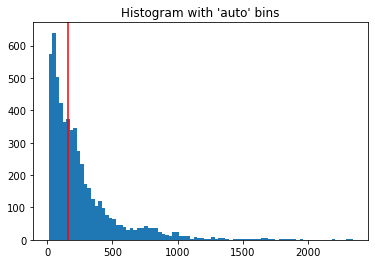

In [7]:
import numpy as np
import matplotlib.pyplot as plt
DB = GenerateFaces(None, plot=False)
db = DB.get_database()
# print(db["1"]["recentered_rectangle"])
# np.diff(db["1"]["recentered_rectangle"])[0]
size = [np.diff(v["recentered_rectangle"])[0] for k,v in db.items()]

_ = plt.hist(size, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.axvline(x=160, color='r')
plt.show()

In [9]:
len(db)

5758

In [80]:
import re
import os

path = "/mnt/golem/Photos/IPhone/"
pictures = [path + IMG  for IMG in os.listdir(path)]


r = re.compile(".*(jpg|heic|PNG|JPG|HEIC)")
pictures = list(filter(r.match, pictures))

np.unique([p.split(".")[-1] for p in pictures], return_counts=True)

(array(['HEIC', 'JPG', 'PNG', 'heic', 'jpg'], dtype='<U4'),
 array([ 802, 1793,  123,    7,  791]))

In [33]:
from collections import Counter
Counter(np.array(size) >= 160)

Counter({False: 1056, True: 1112})

In [74]:
df = np.vstack([np.array(v["encodings"]) for k,v in db.items() if k in np.array(list(db.keys()))[np.array([w for w in np.where(np.array(size) >= 160)[0].tolist()])].tolist()])
df.shape

(1112, 128)

/home/brunosa3/anaconda3/envs/capstone/lib/python3.7/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


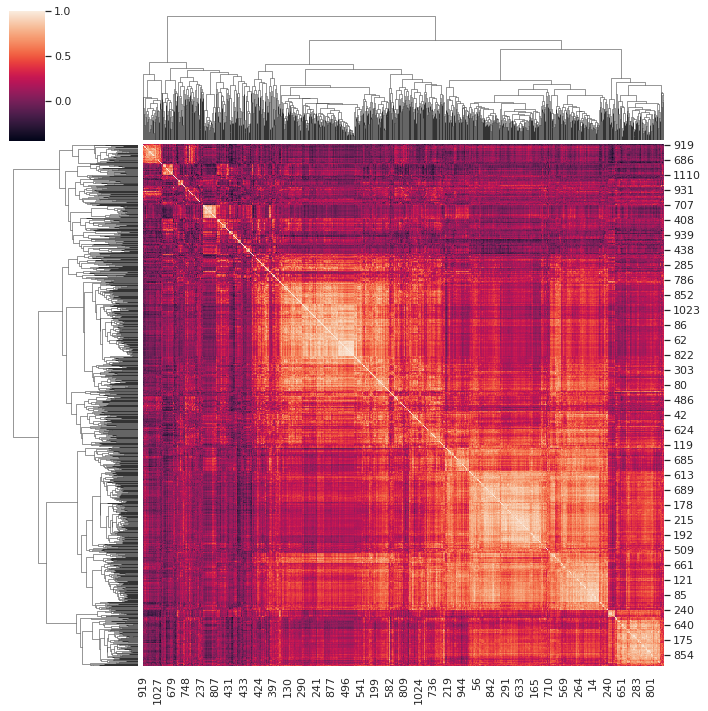

In [80]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns; sns.set_theme(color_codes=True)
cos = cosine_similarity(df)

g = sns.clustermap(cos)
g

In [41]:
test["1240"]

{'path_pic_orig': '/mnt/golem/Photos/IPhone/IMG_0015.HEIC',
 'path_croped_pic': '/mnt/golem/frodo/cropped_faces/1240_cropped_face.png',
 'encodings': [[-0.09927587956190109,
   -0.05503472313284874,
   0.09792857617139816,
   -0.06935013830661774,
   0.04397497698664665,
   -0.04904124513268471,
   0.02367469109594822,
   -0.19739292562007904,
   -0.02126423455774784,
   0.05667436122894287,
   -0.0988524928689003,
   0.16295835375785828,
   -0.013590309768915176,
   -0.13192714750766754,
   0.09731803089380264,
   0.10410494357347488,
   -0.013388143852353096,
   -0.08182782679796219,
   -0.05190956965088844,
   0.008156592026352882,
   -0.04389658197760582,
   0.0825248509645462,
   -0.0021796831861138344,
   -0.03719744458794594,
   0.0038428325206041336,
   0.011757963337004185,
   0.06874523311853409,
   -0.039819326251745224,
   0.0659543126821518,
   0.0810723751783371,
   -0.022573191672563553,
   -0.21987591683864594,
   -0.06510816514492035,
   -0.07142864167690277,
   0.1325

In [ ]:
DB

In [ ]:
import matplotlib.pyplot as plt

for p in list(set(v["path"] for k,v in DB.items())):
    fig, ax = plt.subplots()
    ax.imshow(plt.imread(p))

    ax.axis('off')

    plt.title('matplotlib.pyplot.imread() function Example', 
                                         fontweight ="bold")
    # plt.show()


In [ ]:
import re
path = "/mnt/golem/frodo/"
path = "/mnt/golem/Photos/IPhone/"
pictures = os.listdir(path)

r = re.compile(".*jpg")
pictures = list(filter(r.match, pictures))

import_FaceNet()
    
for pics in pictures:
    # load the photograph
    filename = path + pics

    # load image from file
    pixels = pyplot.imread(filename)
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    faces = detector.detect_faces(pixels)
        
    # display faces on the original image
    crop = crop_faces_centered_boxes(filename, faces)
    
    
#     output_dir = "/mnt/golem/frodo/cropped_faces/" + pics + "cropped_face" + ".png"
#     cv2.imwrite(output_dir, cv2.cvtColor(crop, cv2.COLOR_RGB2BGR))

In [ ]:
filename = path + pictures[0]
# load image from file
pixels = pyplot.imread(filename)
# create the detector, using default weights
detector = MTCNN()
# detect faces in the image
faces = detector.detect_faces(pixels)
faces

In [ ]:

#     path = "/mnt/golem/frodo/"
path = "/mnt/golem/Photos/IPhone/"
pictures = os.listdir(path)
filenames = path + pictures

r = re.compile(".*jpg")
pictures = list(filter(r.match, pictures))

def encode_faces(filenames):
    import re
    import uuid
 

    for pics in pictures:
        # generate unique identifier for this picture
        ID = uuid.uuid4().int
        # load image from file
        pixels = pyplot.imread(filename)
        # create the detector, using default weights
        detector = MTCNN()
        # detect faces in the image
        faces = detector.detect_faces(pixels)
        # display faces on the original image
        crop = crop_faces_centered_boxes(faces, filenames, thr=0.95)
    #     output_dir = "/mnt/golem/frodo/cropped_faces/" + pics + "cropped_face" + ".png"
    #     cv2.imwrite(output_dir, cv2.cvtColor(crop, cv2.COLOR_RGB2BGR))

encode the images using FaceNet

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
K.set_image_data_format('channels_last')
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
import PIL

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
ls ../dat/models/


<a name='3'></a>
## 3 - Encoding Face Images into a 128-Dimensional Vector

<a name='3-1'></a>
### 3.1 - Using a ConvNet to Compute Encodings

The FaceNet model takes a lot of data and a long time to train. So following the common practice in applied deep learning, you'll load weights that someone else has already trained. The network architecture follows the Inception model from [Szegedy *et al*..](https://arxiv.org/abs/1409.4842) An Inception network implementation has been provided for you, and you can find it in the file `inception_blocks_v2.py` to get a closer look at how it is implemented.  

*Hot tip:* Go to "File->Open..." at the top of this notebook. This opens the file directory that contains the `.py` file).

The key things to be aware of are:

- This network uses 160x160 dimensional RGB images as its input. Specifically, a face image (or batch of $m$ face images) as a tensor of shape $(m, n_H, n_W, n_C) = (m, 160, 160, 3)$
- The input images are originally of shape 96x96, thus, you need to scale them to 160x160. This is done in the `img_to_encoding()` function.
- The output is a matrix of shape $(m, 128)$ that encodes each input face image into a 128-dimensional vector

Run the cell below to create the model for face images!

In [ ]:
from tensorflow.keras.models import model_from_json

json_file = open('../dat/models/keras-facenet-h5/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights('../dat/models/keras-facenet-h5/model.h5')

Now summarize the input and output shapes: 

In [ ]:
print(model.inputs)
print(model.outputs)

In [ ]:
FRmodel = model

In [ ]:
#tf.keras.backend.set_image_data_format('channels_last')
def img_to_encoding(image_path, model):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(160, 160))
    img = np.around(np.array(img) / 255.0, decimals=12)
    x_train = np.expand_dims(img, axis=0)
    embedding = model.predict_on_batch(x_train)
    return embedding / np.linalg.norm(embedding, ord=2)

In [ ]:
import re
pics = [ "/mnt/golem/frodo/cropped_faces/" + f for f in os.listdir("/mnt/golem/frodo/cropped_faces/")]
# print(pics)
# r = re.compile(".*(.gif|.jpg|.jpeg|.tiff|.png)")
# pics = list(filter(r.match, pictures))
# pics

r = re.compile(".*(.png)")
pics = list(filter(r.match, pics))
pics

In [ ]:
encodings = np.zeros((1,128))
for face in pics:
    encodings = np.vstack((encodings, img_to_encoding(face, FRmodel)))

encodings = np.delete(encodings, (0), axis=0)
encodings.shape

In [ ]:
encodings

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca.fit(encodings)

print(pca.components_)

print(pca.explained_variance_)




In [ ]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

    
# plot data
plt.scatter(encodings[:, 0], encodings[:, 1], alpha=0.2)

zipped = [(l, v) for l,v in zip(pca.explained_variance_, pca.components_)]
for z in zipped:
    v = z[1] * 3 * np.sqrt(z[0])
    print(pca.mean_)
    draw_vector(pca.mean_[0], pca.mean_[0] + v)
plt.axis('equal');

https://www.geeksforgeeks.org/ml-unsupervised-face-clustering-pipeline/

In [ ]:
from sklearn.cluster import DBSCAN

clt = DBSCAN(eps = 0.5, metric ="euclidean")
                       
clt.fit(encodings)

# determine the total number of
# unique faces found in the dataset
labelIDs = np.unique(clt.labels_)
numUniqueFaces = len(np.where(labelIDs > -1)[0])

In [ ]:
u, c = np.unique(clt.labels_, return_counts=True)

import pandas as pd

pd.DataFrame({"unique": u, "freq": c})

In [ ]:
examples = {}
for k in labelIDs:
    examples[k] = np.array(pics)[np.where(clt.labels_ == k)[0]]

In [ ]:
n = 5
k = 12
for i in range(n):
    pixels = pyplot.imread(examples[k][i])

    pyplot.subplot(1, n, i+1)
    pyplot.axis('off')
    # plot face
    pyplot.imshow(pixels)

In [ ]:
# Encode the face embedding, reference path
# and location and emit to pipeline
class FaceEncoder(Node):
    def setup(self, detection_method = 'cnn'):
        self.detection_method = detection_method
        # detection_method can be cnn or hog
 
    def run(self, data):
        id = data['id']
        imagePath = data['imagePath']
        image = cv2.imread(imagePath)
        rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
 
        boxes = face_recognition.face_locations(
               rgb, model = self.detection_method)
 
        encodings = face_recognition.face_encodings(rgb, boxes)
        d = [{"imagePath": imagePath, "loc": box, "encoding": enc}
                         for (box, enc) in zip(boxes, encodings)]
 
        self.emit({'id': id, 'encodings': d})